# v2.1 run RNN with Spatial Training

This notebook is intended to set up a test where the RNN is run serial by location and compared to the spatial training scheme. Additionally, the ODE model with the augmented KF will be run as a comparison, but note that the RNN models will be predicting entirely without knowledge of the heldout locations, while the augmented KF will be run directly on the test locations.


## Environment Setup

In [1]:
import numpy as np
from utils import print_dict_summary, print_first, str2time, logging_setup
import pickle
import logging
import os.path as osp
from moisture_rnn_pkl import pkl2train
from moisture_rnn import RNNParams, RNNData, RNN 
from utils import hash2, read_yml, read_pkl, retrieve_url, Dict
from moisture_rnn import RNN
import reproducibility
from data_funcs import rmse, to_json, combine_nested, process_train_dict
from moisture_models import run_augmented_kf
import copy
import pandas as pd
import matplotlib.pyplot as plt
import yaml
import time

In [2]:
logging_setup()

In [3]:
retrieve_url(
    url = "https://demo.openwfm.org/web/data/fmda/dicts/fmda_nw_202401-05_f05.pkl", 
    dest_path = "data/fmda_nw_202401-05_f05.pkl")

Target data already exists at data/fmda_nw_202401-05_f05.pkl


In [4]:
file_paths = ['data/fmda_nw_202401-05_f05.pkl']

In [5]:
# read/write control
train_file='data/train.pkl'
train_create=True   # if false, read
train_write=True
train_read=True

In [6]:
# Params used for data filtering
params_data = read_yml("params_data.yaml") 
params_data

{'max_intp_time': 10,
 'zero_lag_threshold': 10,
 'hours': 720,
 'min_fm': 1,
 'max_fm': 90,
 'min_rain': 0,
 'max_rain': 100,
 'min_wind': 0,
 'max_wind': 35,
 'min_solar': 0,
 'max_solar': 1400,
 'min_soilm': 0,
 'features_all': ['Ed',
  'Ew',
  'solar',
  'wind',
  'elev',
  'lon',
  'lat',
  'soilm',
  'canopyw',
  'groundflux',
  'rain']}

In [7]:
# Params used for setting up RNN
params = read_yml("params.yaml", subkey='rnn') 
params

{'batch_size': 32,
 'timesteps': 5,
 'optimizer': 'adam',
 'rnn_layers': 1,
 'rnn_units': 20,
 'dense_layers': 1,
 'dense_units': 5,
 'activation': ['relu', 'relu'],
 'dropout': [0.2, 0.2],
 'recurrent_dropout': 0.2,
 'reset_states': True,
 'batch_schedule_type': 'exp',
 'bmin': 20,
 'bmax': 200,
 'epochs': 20,
 'learning_rate': 0.001,
 'clipvalue': 10.0,
 'phys_initialize': False,
 'stateful': True,
 'verbose_weights': True,
 'verbose_fit': False,
 'features_list': ['Ed', 'Ew', 'rain'],
 'scale': True,
 'scaler': 'standard',
 'time_fracs': [0.9, 0.05, 0.05],
 'early_stopping_patience': 5,
 'predict_spinup_hours': 5}

In [8]:
if train_create:
    logging.info('creating the training cases from files %s',file_paths)
    # osp.join works on windows too, joins paths using \ or /
    train = process_train_dict(file_paths, params_data = params_data, verbose=True)
if train_write:
    with open(train_file, 'wb') as file:
        logging.info('Writing the rain cases into file %s',train_file)
        pickle.dump(train, file)
if train_read:
    logging.info('Reading the train cases from file %s',train_file)
    train = read_pkl(train_file)

2024-09-18 13:49:41,232 - INFO - creating the training cases from files ['data/fmda_nw_202401-05_f05.pkl']
2024-09-18 13:49:42,945 - INFO - PLFI1_202401 HRRR.time time array increments are 1.0 hours
2024-09-18 13:49:42,997 - INFO - PLFI1_202401 RAWS.time_raws time array increments are min 1.0 max 2.0
2024-09-18 13:49:43,056 - INFO - SADI1_202401 HRRR.time time array increments are 1.0 hours
2024-09-18 13:49:43,105 - INFO - SADI1_202401 RAWS.time_raws time array increments are min 1.0 max 3.0
2024-09-18 13:49:43,164 - INFO - SRFI1_202401 HRRR.time time array increments are 1.0 hours
2024-09-18 13:49:43,211 - INFO - SRFI1_202401 RAWS.time_raws time array increments are min 1.0 max 2.0
2024-09-18 13:49:43,260 - INFO - WEFI1_202401 HRRR.time time array increments are 1.0 hours
2024-09-18 13:49:43,305 - INFO - WEFI1_202401 RAWS.time_raws time array increments are min 1.0 max 2.0
2024-09-18 13:49:43,358 - INFO - AGFO3_202401 HRRR.time time array increments are 1.0 hours
2024-09-18 13:49:43,4

In [9]:
from itertools import islice
train = {k: train[k] for k in islice(train, 200)}

## Setup Validation Runs

In [10]:
params = RNNParams(params)
params.update({'epochs': 200, 
               'learning_rate': 0.001,
               'activation': ['tanh', 'tanh'], # Activation for RNN Layers, Dense layers respectively.
               'recurrent_layers': 2, 'recurrent_units': 30, 
               'dense_layers': 2, 'dense_units': 30,
               'early_stopping_patience': 30, # how many epochs of no validation accuracy gain to wait before stopping
               'batch_schedule_type': 'exp', # Hidden state batch reset schedule
               'bmin': 20, # Lower bound of hidden state batch reset, 
               'bmax': params_data['hours'], # Upper bound of hidden state batch reset, using max hours
               'features_list': ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
              })

Checking params...
Input dictionary passed all checks.
Calculating shape params based on features list, timesteps, and batch size
Input Feature List: ['Ed', 'Ew', 'rain']
Input Timesteps: 5
Input Batch Size: 32
Calculated params:
Number of features: 3
Batch Shape: (32, 5, 3)
{'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 1, 'dense_units': 5, 'activation': ['relu', 'relu'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type': 'exp', 'bmin': 20, 'bmax': 200, 'epochs': 20, 'learning_rate': 0.001, 'clipvalue': 10.0, 'phys_initialize': False, 'stateful': True, 'verbose_weights': True, 'verbose_fit': False, 'features_list': ['Ed', 'Ew', 'rain'], 'scale': True, 'scaler': 'standard', 'time_fracs': [0.9, 0.05, 0.05], 'early_stopping_patience': 5, 'predict_spinup_hours': 5, 'n_features': 3, 'batch_shape': (32, 5, 3)}
Calculating shape params based on features list, timesteps, and batch size
Input 

In [11]:
reproducibility.set_seed(123)

resetting random seeds to 123


## Spatial Data Training

In [12]:
# Start timer for code 
start_time = time.time()

In [13]:
# Combine Nested Dictionary into Spatial Data
train_sp = Dict(combine_nested(train))

In [14]:
rnn_dat_sp = RNNData(
    train_sp, # input dictionary
    scaler="standard",  # data scaling type
    features_list = params['features_list'] # features for predicting outcome
)


rnn_dat_sp.train_test_split(   
    time_fracs = [.8, .1, .1], # Percent of total time steps used for train/val/test
    space_fracs = [.8, .1, .1] # Percent of total timeseries used for train/val/test
)
rnn_dat_sp.scale_data()

rnn_dat_sp.batch_reshape(
    timesteps = params['timesteps'], # Timesteps aka sequence length for RNN input data. 
    batch_size = params['batch_size'] # Number of samples of length timesteps for a single round of grad. descent
)

Input data from multiple timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
Subsetting locations into train/val/test
Total Locations: 200
Train Locations: 160
Val. Locations: 20
Test Locations: 20
X_train[0] shape: (576, 8), y_train[0] shape: (576, 1)
X_val[0] shape: (72, 8), y_val[0] shape: (72, 1)
X_test[0] shape: (72, 8), y_test[0] shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping spatial training data using batch size: 32 and timesteps: 5
Setting total hours to minimum length of y in provided dictionary
Setting Start times to offset by 1 hour by location
Reshaping validation data using batch size: 32 and timesteps: 5
Setting total hours to minimum length of y in provided dictionary
Setting Start times to offset by 1 hour by location


In [15]:
# Update Params specific to spatial training
params.update({
    'loc_batch_reset': rnn_dat_sp.n_seqs # Used to reset hidden state when location changes for a given batch
})

Initial Weights Hash: dda4be07cbfe7cf2b291f3f134d2bca4
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type': 'exp', 'bmin': 20, 'bmax': 720, 'epochs': 200, 'learning_rate': 0.001, 'clipvalue': 10.0, 'phys_initialize': False, 'stateful': True, 'verbose_weights': True, 'verbose_fit': False, 'features_list': ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind'], 'scale': True, 'scaler': 'standard', 'time_fracs': [0.9, 0.05, 0.05], 'early_stopping_patience': 30, 'predict_spinup_hours': 5, 'n_features': 8, 'batch_shape': (32, 5, 8), 'recurrent_layers': 2, 'recurrent_units': 30, 'loc_batch_reset': 83}
Using ResetStatesCallback with Batch Reset Schedule: exp
batch_reset_intervals: [ 20  20  20  21  21  21  22  22  23  23  23  24  24  25  25  26  26  27
  27 

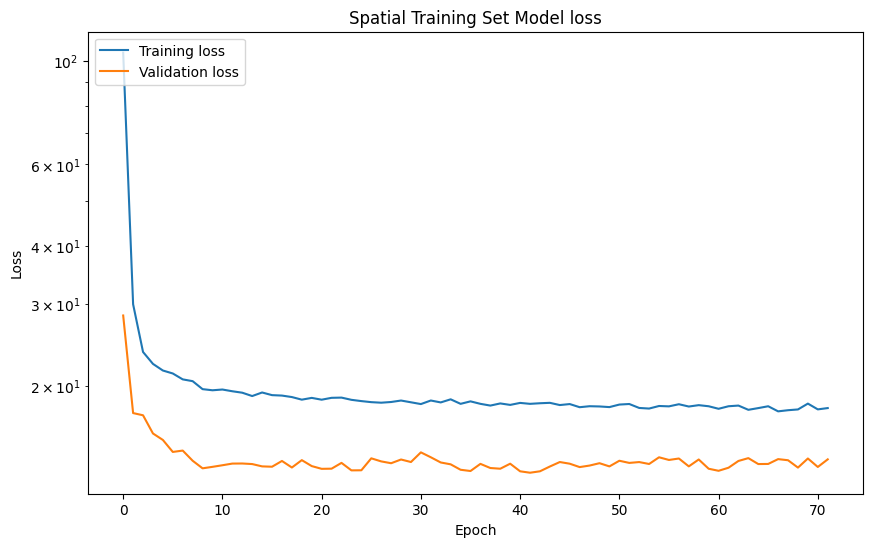

Fitted Weights Hash: d07634ceeccc0273fe2cca502c4f6c3e
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


In [16]:
rnn_sp = RNN(params)
m, errs = rnn_sp.run_model(rnn_dat_sp)

In [17]:
errs.mean()

3.976586029870589

In [18]:
# End Timer
end_time = time.time()

# Calculate Code Runtime
elapsed_time_sp = end_time - start_time
print(f"Spatial Training Elapsed time: {elapsed_time_sp:.4f} seconds")

Spatial Training Elapsed time: 63.2867 seconds


## Run ODE + KF and Compare

In [19]:
# Get timeseries IDs from previous RNNData object
test_cases = rnn_dat_sp.loc['test_locs']
print(len(test_cases))

20


In [20]:
test_ind = rnn_dat_sp.test_ind # Time index for test period start
print(test_ind)

648


In [21]:
outputs_kf = {}
for case in test_cases:
    print("~"*50)
    print(case)
    # Run Augmented KF
    print('Running Augmented KF')
    train[case]['h2'] = test_ind
    train[case]['scale_fm'] = 1
    m, Ec = run_augmented_kf(train[case])
    y = train[case]['y']        
    train[case]['m_kf'] = m
    print(f"KF RMSE: {rmse(m[test_ind:],y[test_ind:])}")
    outputs_kf[case] = {'case':case, 'errs': rmse(m[test_ind:],y[test_ind:])}

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
PEOW1_202401_set_3
Running Augmented KF
KF RMSE: 3.5850922800446057
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
MEFW1_202401_set_5
Running Augmented KF
KF RMSE: 4.8347412197800885
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
FWFW1_202401_set_2
Running Augmented KF
KF RMSE: 4.745857062709144
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
KEEO3_202401_set_5
Running Augmented KF
KF RMSE: 4.382243881810233
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
IRFO3_202401_set_4
Running Augmented KF
KF RMSE: 2.6416972287172458
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
CAFO3_202401_set_2
Running Augmented KF
KF RMSE: 1.990823258778872
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
BKRW1_202401_set_4
Running Augmented KF
KF RMSE: 4.7942856252895165
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
LBFO3_202401_set_2
Running Augmented KF
KF RMSE: 5.470011192754223
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
K

In [22]:
df_kf = pd.DataFrame.from_dict(outputs_kf).transpose()
df_kf.head()

case      errs
PEOW1_202401_set_3  PEOW1_202401_set_3  3.585092
MEFW1_202401_set_5  MEFW1_202401_set_5  4.834741
FWFW1_202401_set_2  FWFW1_202401_set_2  4.745857
KEEO3_202401_set_5  KEEO3_202401_set_5  4.382244
IRFO3_202401_set_4  IRFO3_202401_set_4  2.641697

In [23]:
df_kf.errs.mean()

4.271973638021123

## Serial Training

In [24]:
# Start timer for code 
start_time = time.time()

In [25]:
# Update Params specific to Serial training
params.update({
    'loc_batch_reset': None, # Used to reset hidden state when location changes for a given batch
    'epochs': 1 # less epochs since fit will be run multiple times over locations
})

In [26]:
train_cases = rnn_dat_sp.loc['train_locs']
test_cases = rnn_dat_sp.loc['test_locs']

In [27]:
# Initialize Model with first train case
rnn_dat = RNNData(train[train_cases[0]], params['scaler'], params['features_list'])
rnn_dat.train_test_split(
    time_fracs = [.8, .1, .1]
)
rnn_dat.scale_data()
rnn_dat.batch_reshape(timesteps = params['timesteps'], batch_size = params['batch_size'])

Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5


In [28]:
reproducibility.set_seed()
rnn = RNN(params)

resetting random seeds to 123
Initial Weights Hash: 64405e1bb02cb80e334345495631f4cb


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case BMFW1_202401_set_5
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type': 'exp', 'bmin': 20, 'bmax': 720, 'epochs': 1, 'learnin

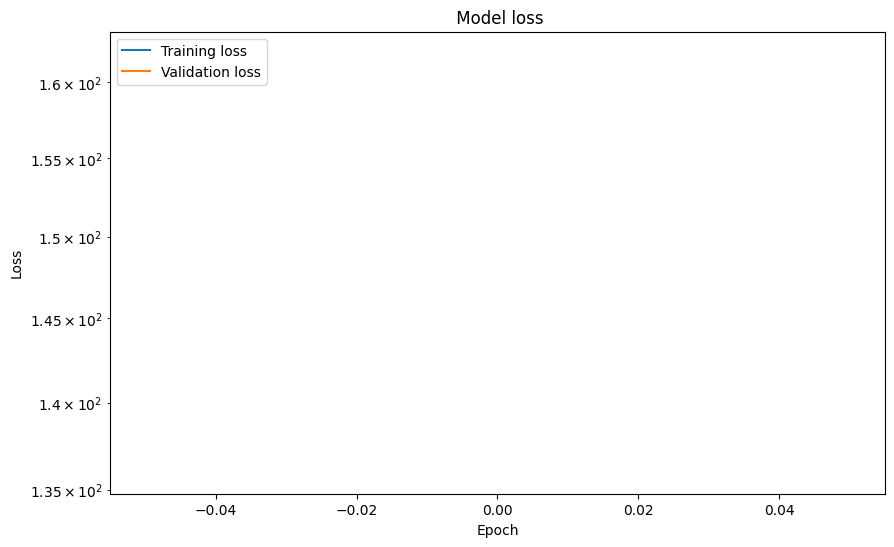

Fitted Weights Hash: f83b638304ed372810af82d7e2e73183
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case SDFO3_202401_set_4
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

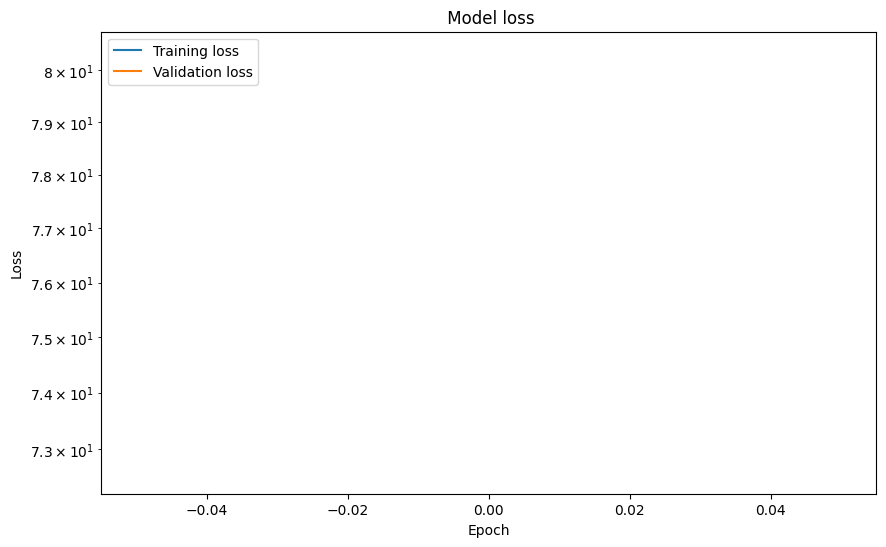

Fitted Weights Hash: c8edb71b7541c0b2174dd071dbb1fa0a
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case ALFO3_202401_set_2
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

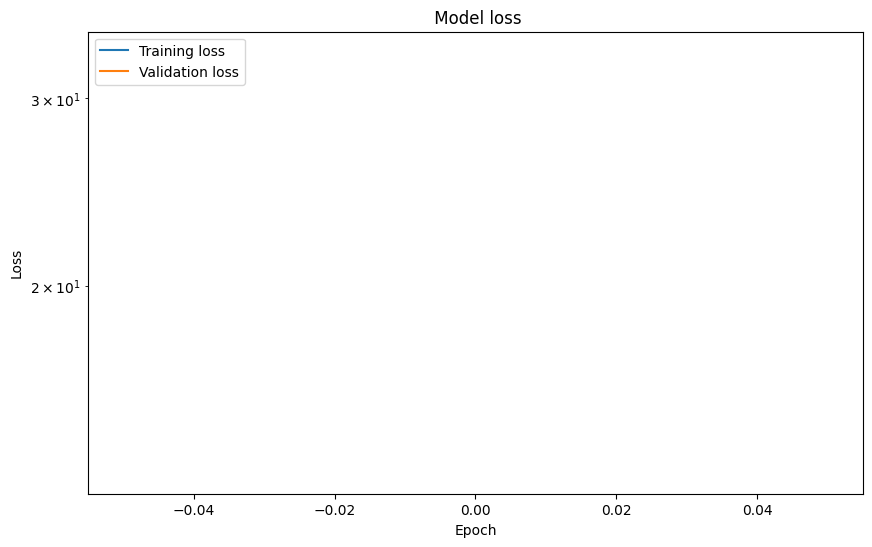

Fitted Weights Hash: 5796120f2eb7972131b54da10937c7fe
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case SRFI1_202401_set_2
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

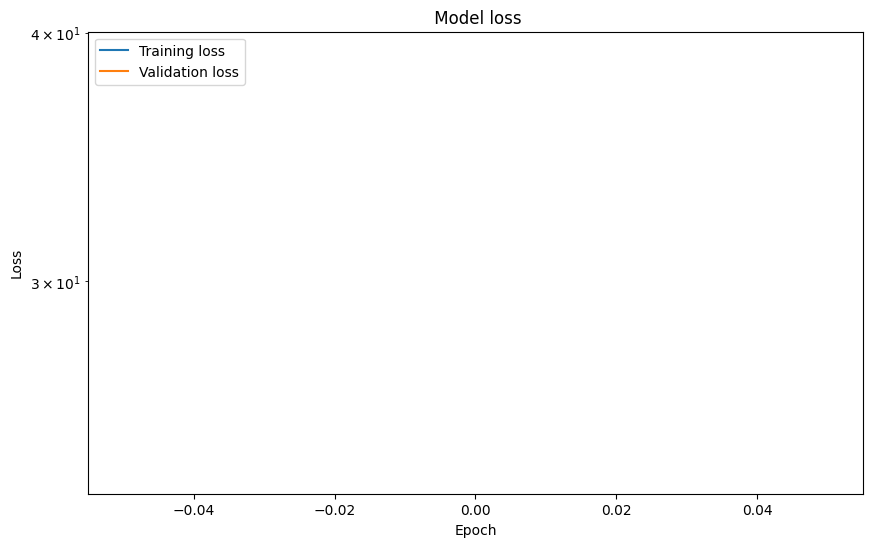

Fitted Weights Hash: 5b8eae2263cbb3e3aad1815d769ba19a
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case CEFO3_202401_set_3
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

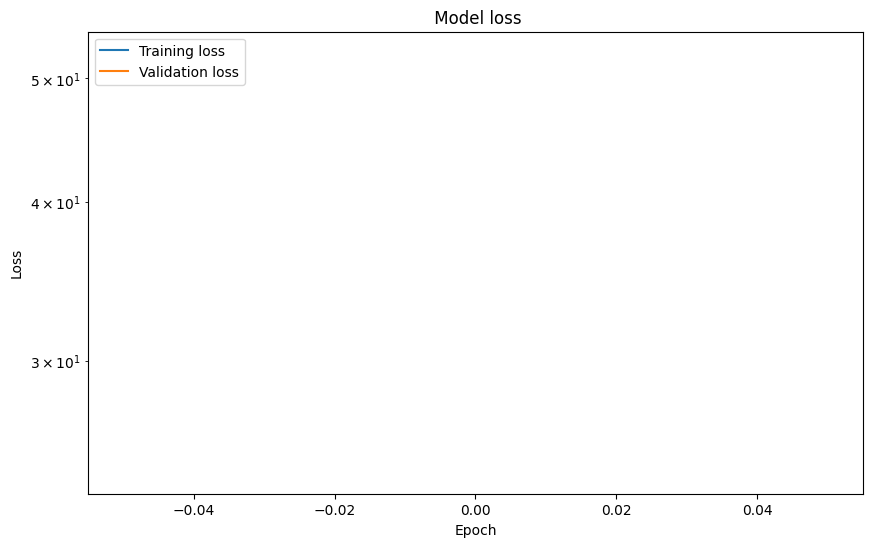

Fitted Weights Hash: 6a89c9bd7865253a3c0d586fb2b1d357
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case CSFO3_202401_set_4
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

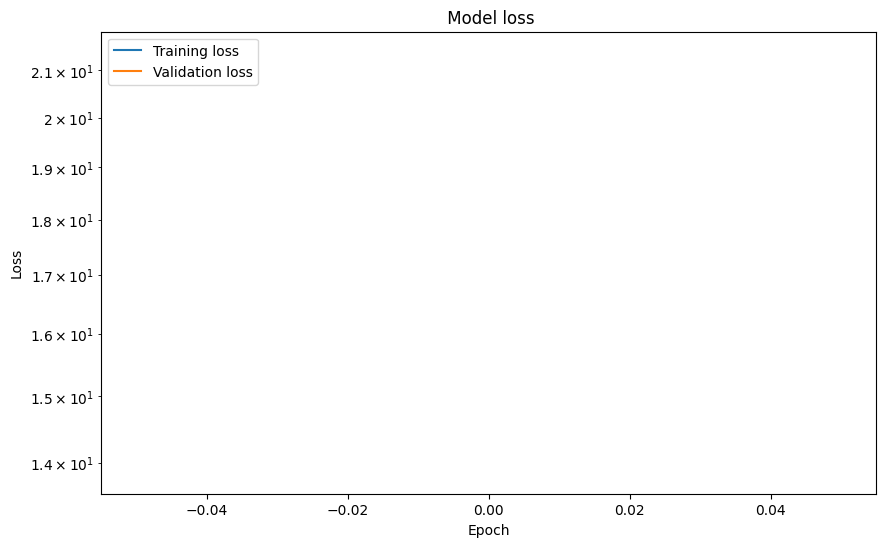

Fitted Weights Hash: a129746a78fd93213c0cb6a97ee4ecf3
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case BCFO3_202401_set_3
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

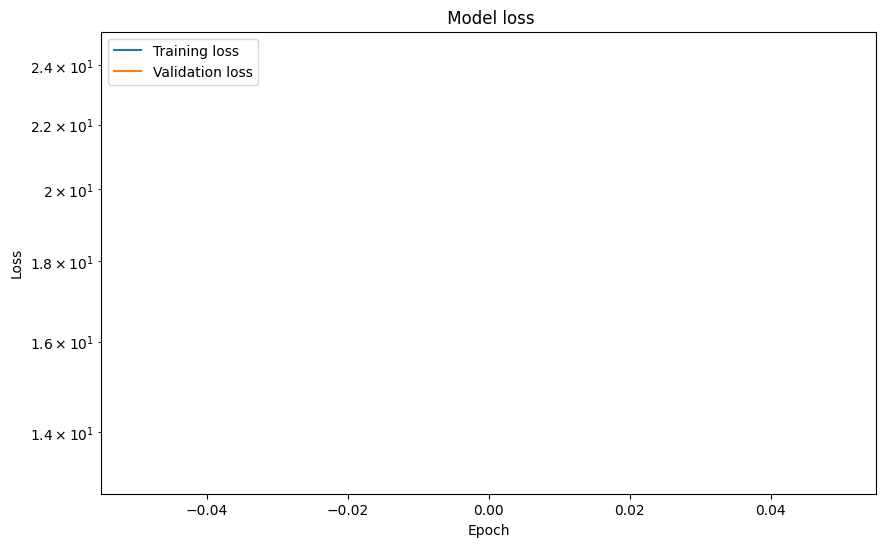

Fitted Weights Hash: 04fc844d05a5aa4bc2f31eca964c771d
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case PKFO3_202401_set_5
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

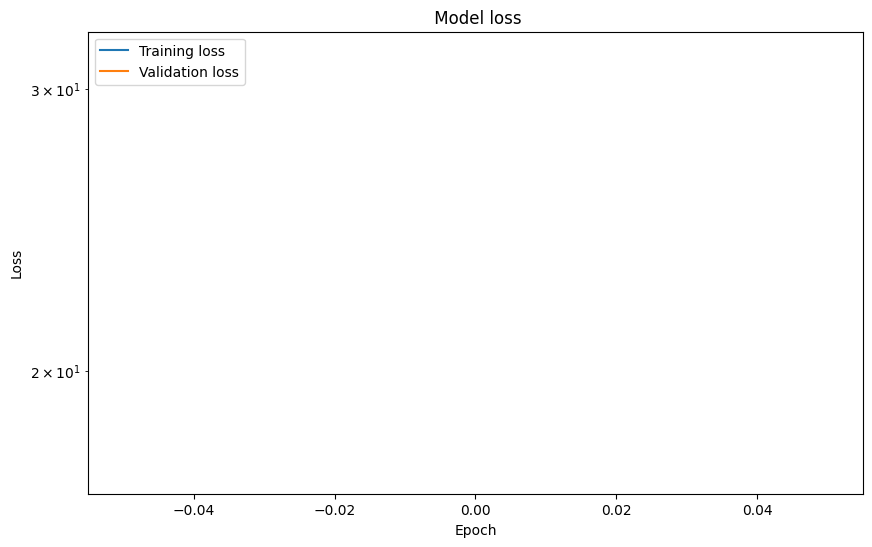

Fitted Weights Hash: fd7bb3f065e464792492a89ef4071789
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case LCFW1_202401_set_4
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

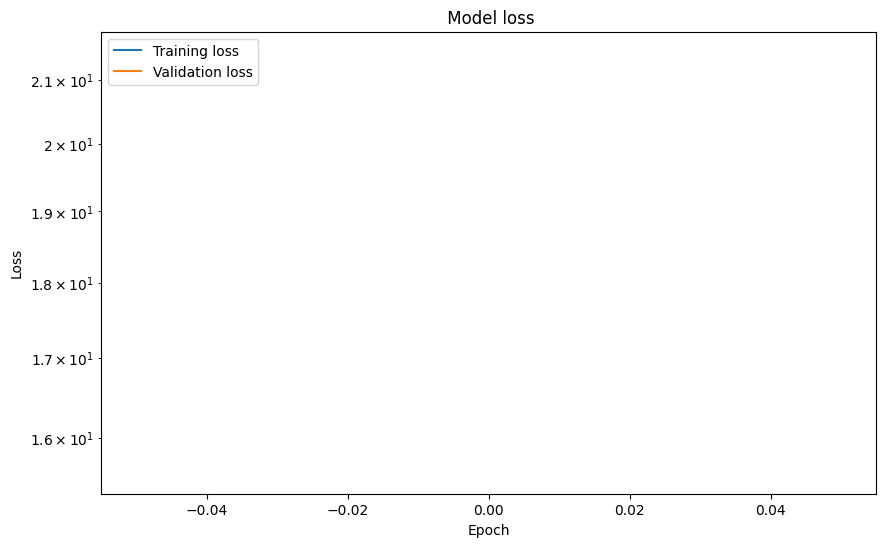

Fitted Weights Hash: 1fd7da7557f75f1027f725e8990cc299
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case GHFW1_202401_set_4
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

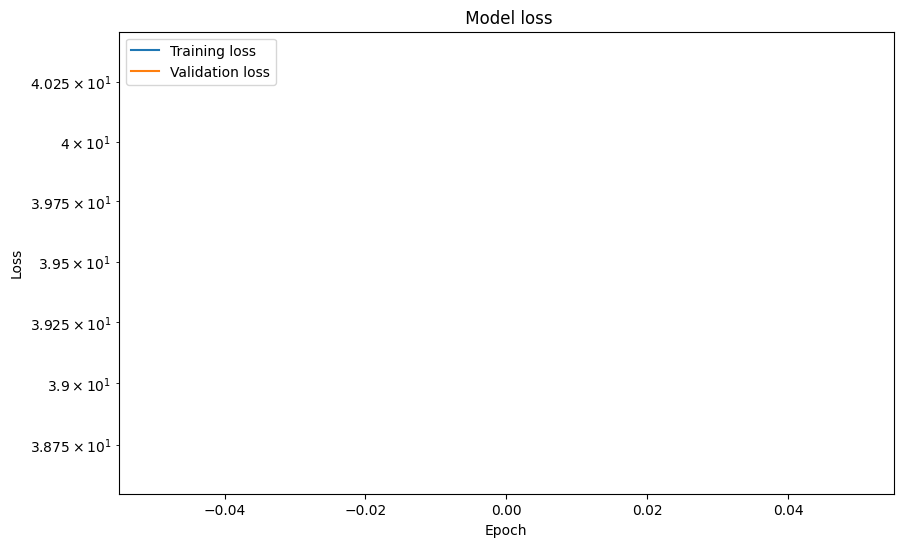

Fitted Weights Hash: 451a58c0046e50e5faf7ccc5f08d2b60
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case EMFO3_202401_set_5
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

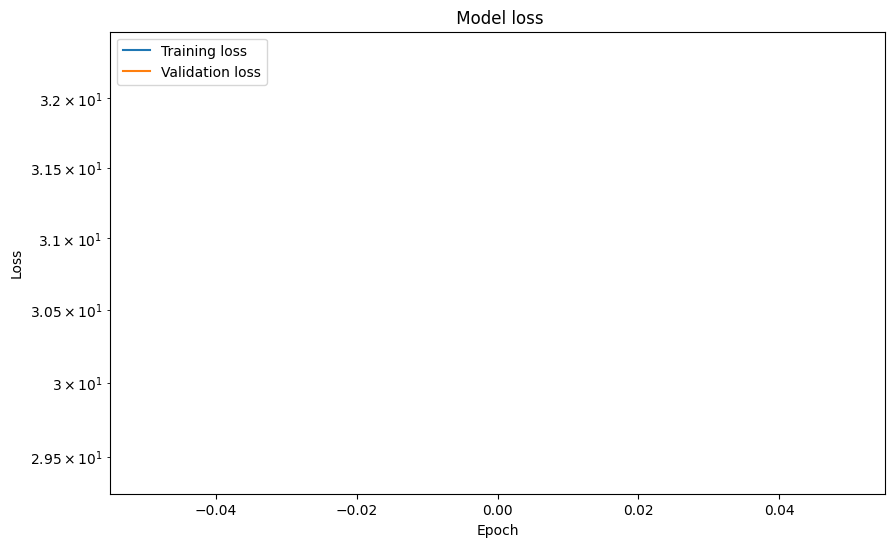

Fitted Weights Hash: 184010ecb466f13a9abfb6662f7ba1a4
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case PEOW1_202401_set_4
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

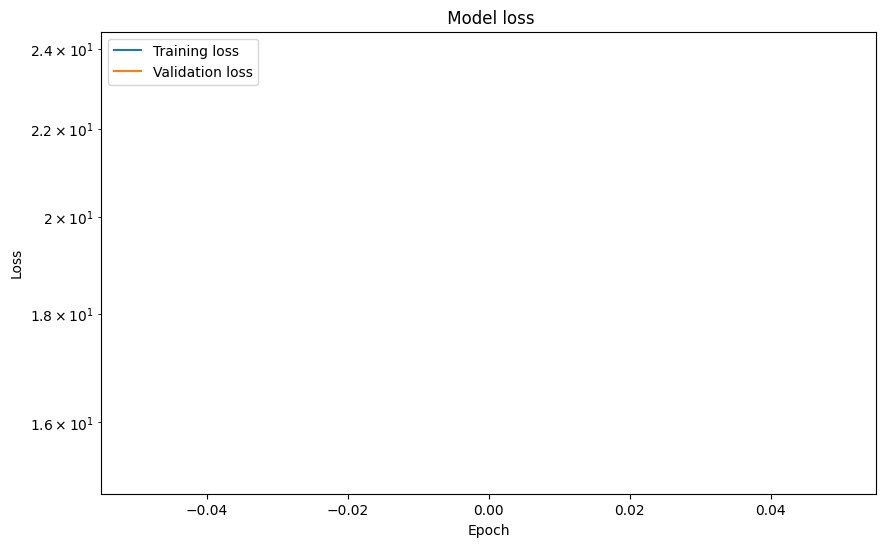

Fitted Weights Hash: 1fba9be9c508d616ddf4a8b057a419f1
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case BCFO3_202401_set_2
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

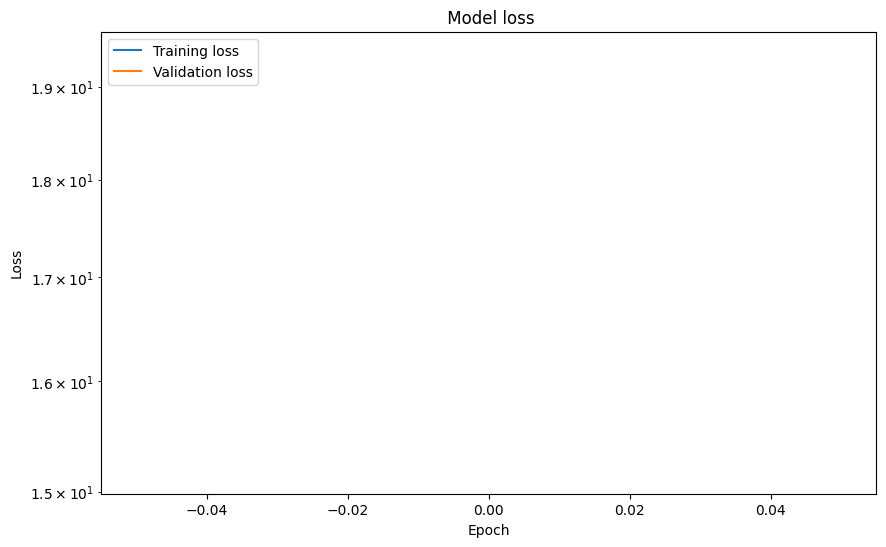

Fitted Weights Hash: b9922ba7fabd886cc3a340d69e90583f
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case LBFO3_202401_set_3
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

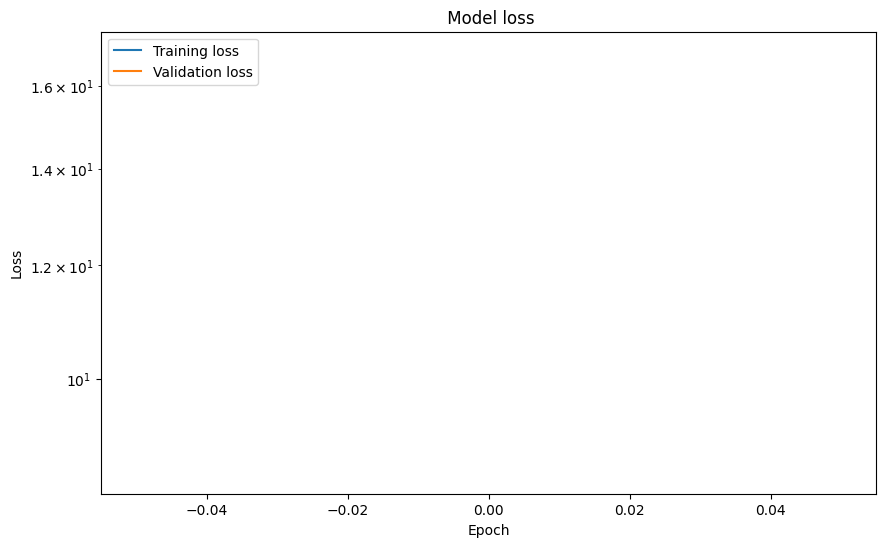

Fitted Weights Hash: 2e103e54576d5ea951df267791386157
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case GHFW1_202401_set_5
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

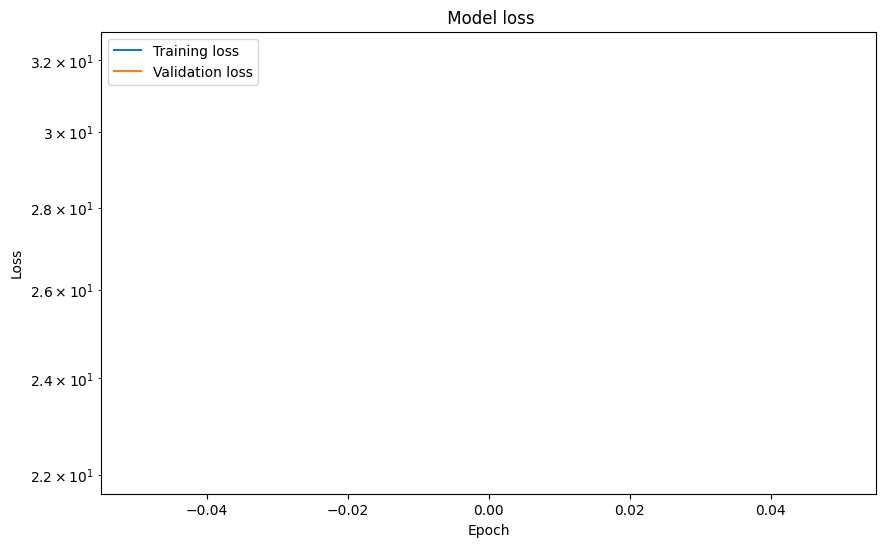

Fitted Weights Hash: d2fdb13a7c6b9b954b36d855ff2bc9e4
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case BKFO3_202401_set_5
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

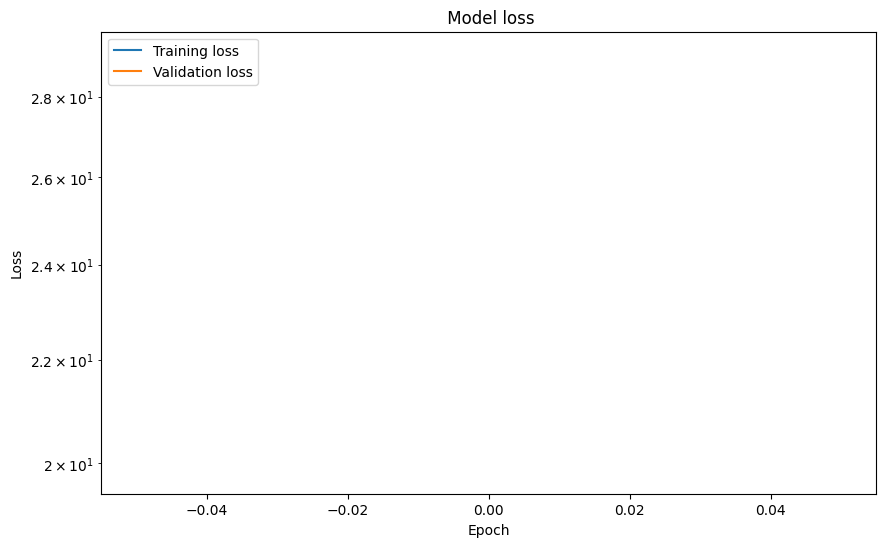

Fitted Weights Hash: fc374f4363472e66b8e2024ac60b6f54
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case PKFO3_202401_set_4
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

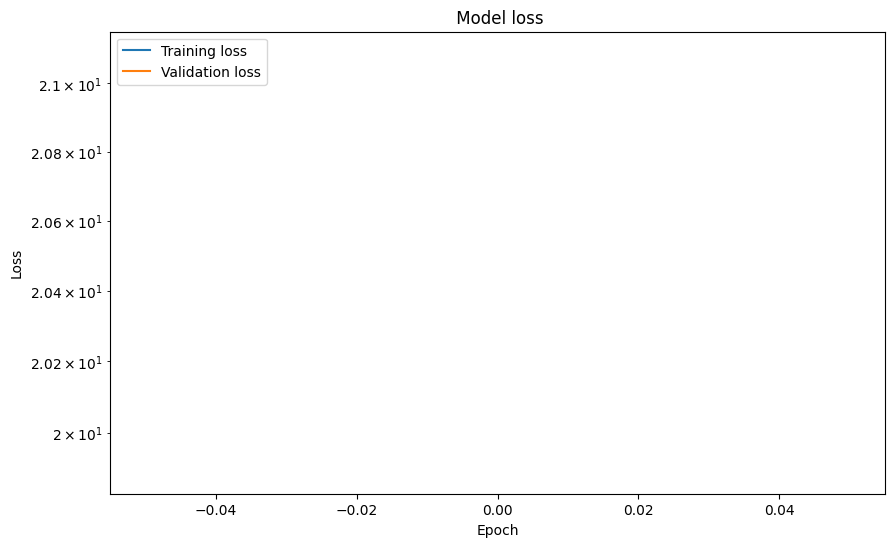

Fitted Weights Hash: eda8f41a1b2cfb52527dbfdf9242df38
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case TCFW1_202401_set_4
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

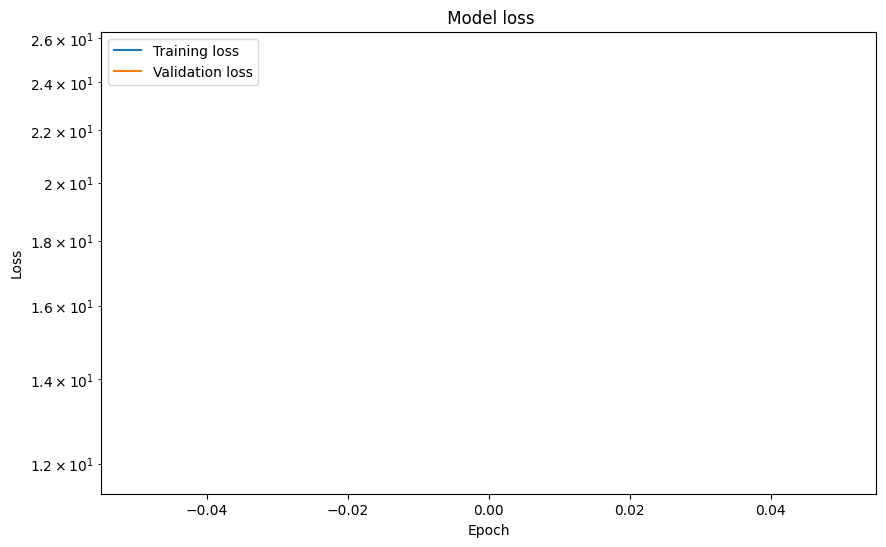

Fitted Weights Hash: 3c83f9af51b2c59f2b0afbb9ed209c77
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case HYFO3_202401_set_5
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

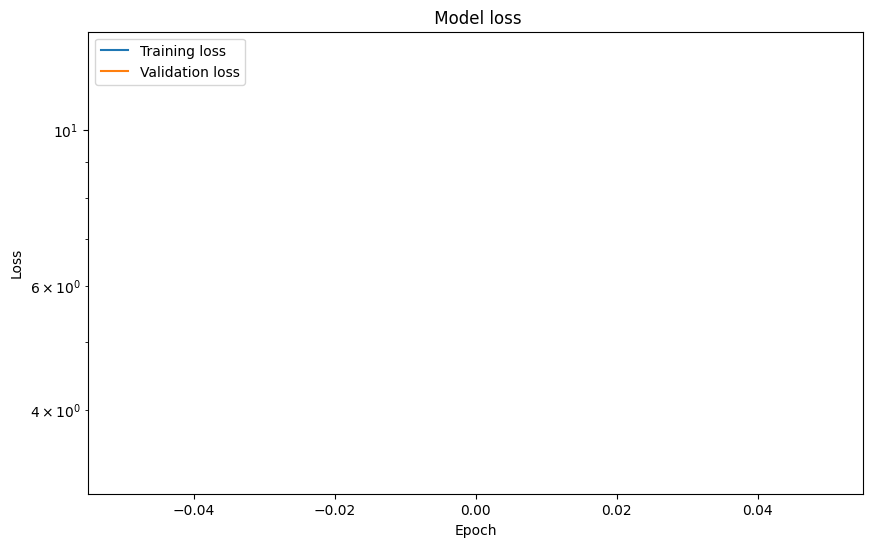

Fitted Weights Hash: af018b734f5d3850a93712803c9f6831
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case LEFW1_202401_set_3
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

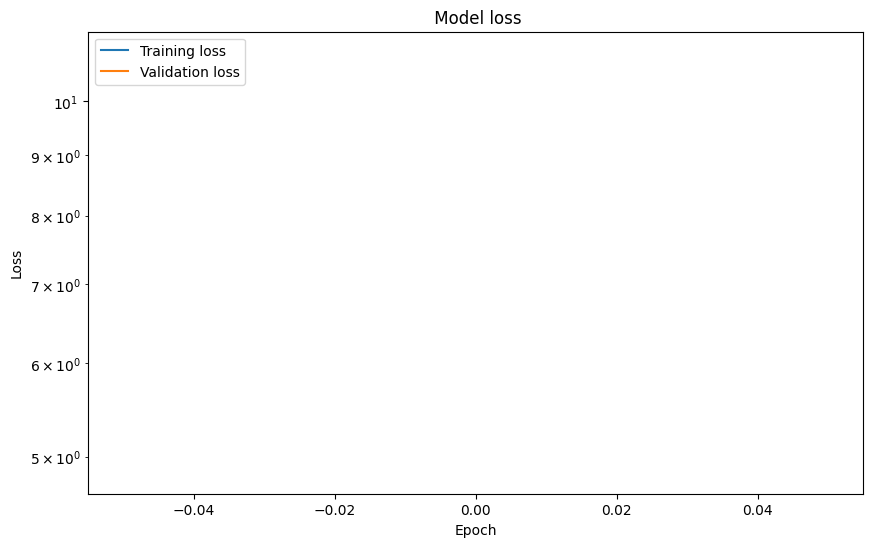

Fitted Weights Hash: 4b57f59aceff1b04d79568799fe8ddb5
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case GDFO3_202401_set_5
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

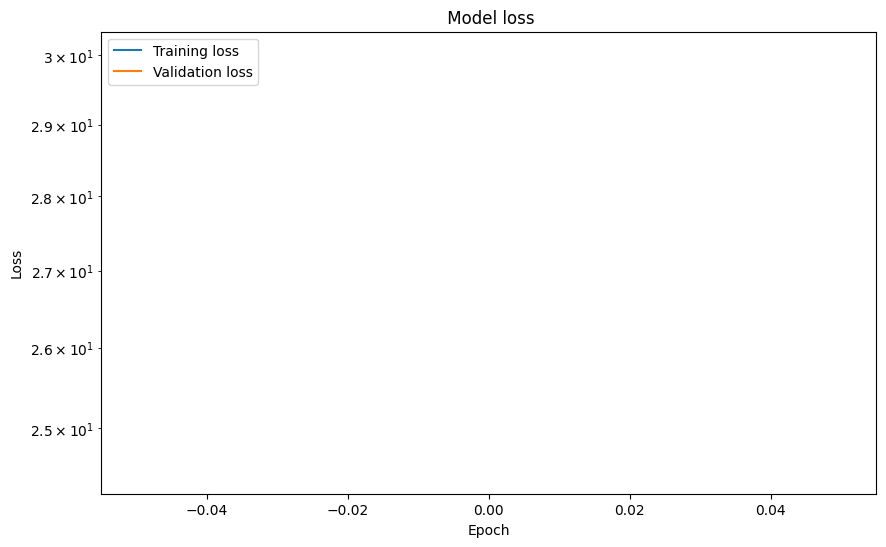

Fitted Weights Hash: 9cf03f9a2b3a64aa0726d4503d07402c
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case AGFO3_202401_set_4
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

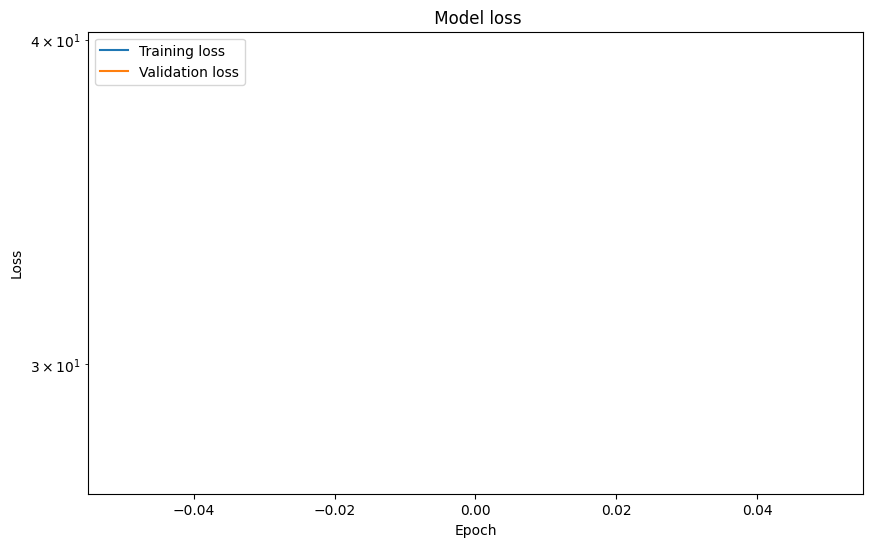

Fitted Weights Hash: 7eb718d1c9ef037a1b84d4fd0624f828
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case DIFW1_202401_set_5
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

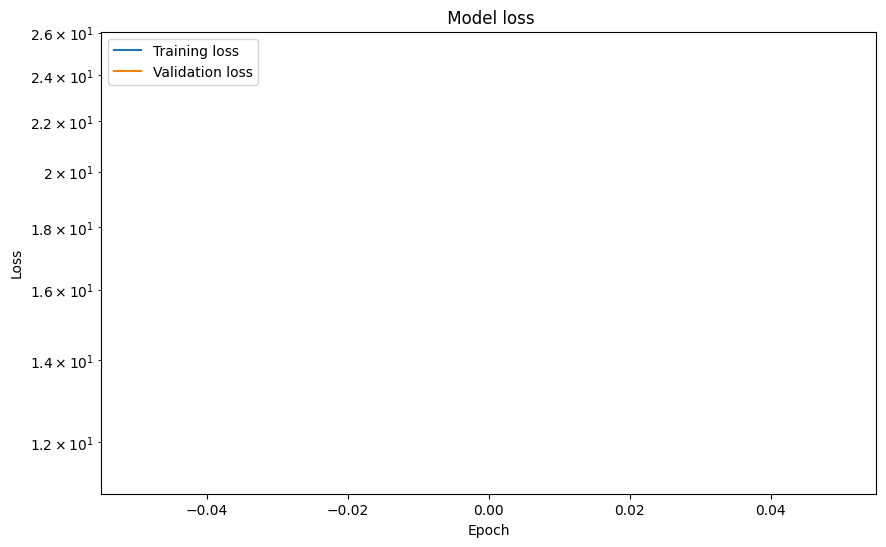

Fitted Weights Hash: 697cabc77712be42ce4e23b721efbaa5
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case CAFO3_202401
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type': 'exp'

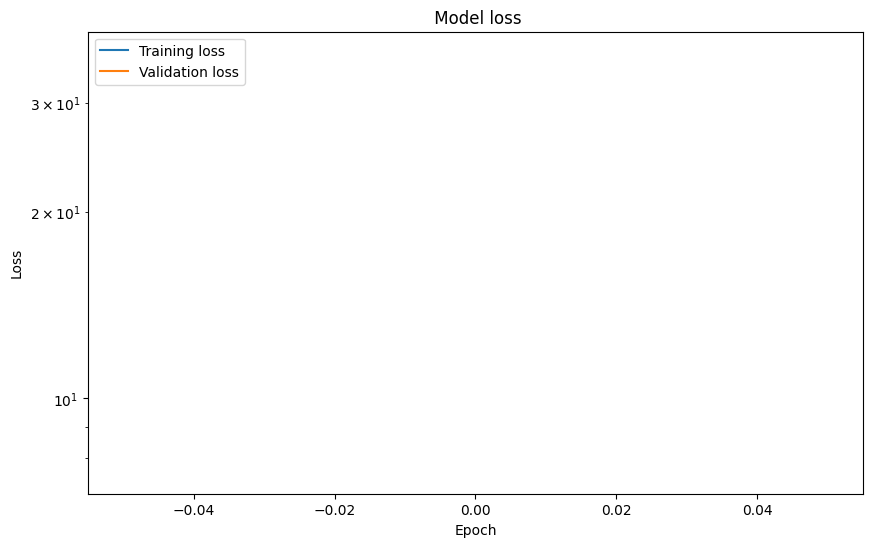

Fitted Weights Hash: 0e50525230acdf6a26630c5ab6449e15
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case OMFO3_202401_set_4
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

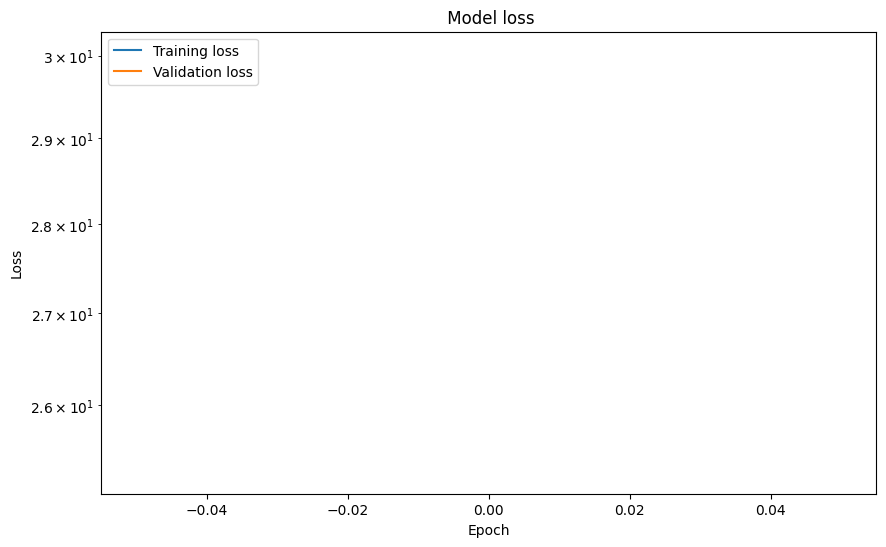

Fitted Weights Hash: 155b72c8d528566dfa2ddb73c7a79be4
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case KTLW1_202401_set_3
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

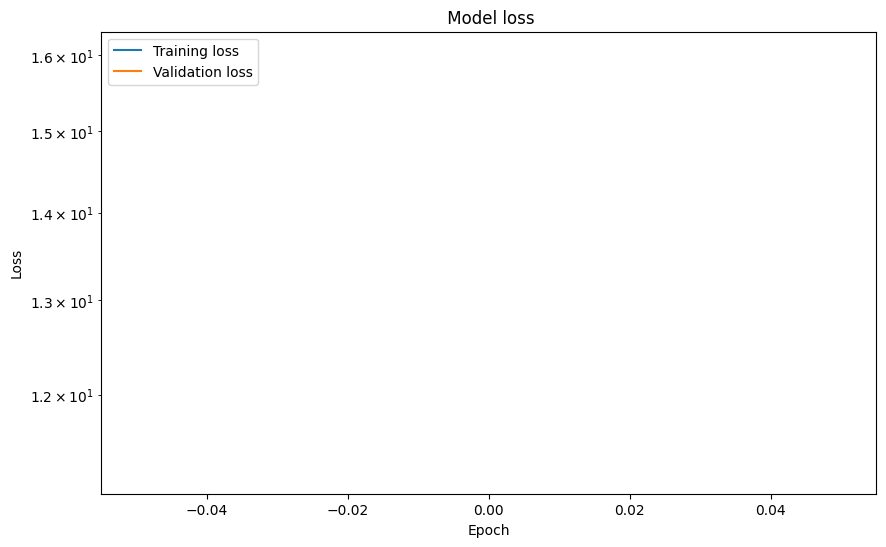

Fitted Weights Hash: 4b965cfdc11bed055b7caf9c870daea4
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case WEFI1_202401_set_4
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

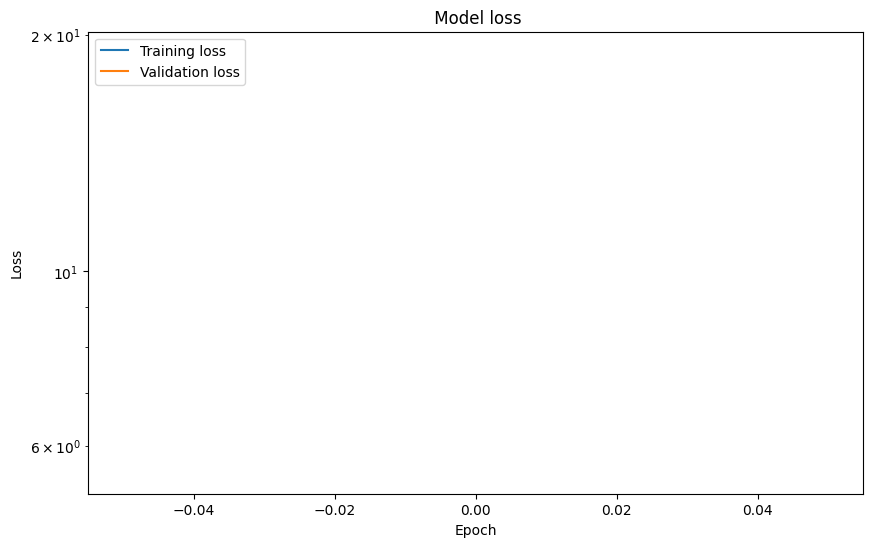

Fitted Weights Hash: 8dacf0a7037e8a5ebd5c2e99c5170937
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case FTAW1_202401_set_2
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

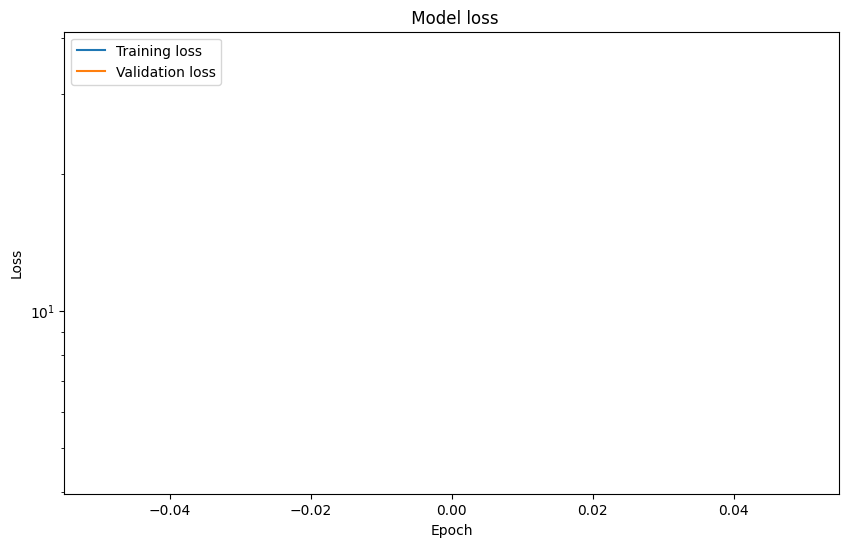

Fitted Weights Hash: 13dd8a812e04f4324d5e22c7f97c1877
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case BGFO3_202401_set_4
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

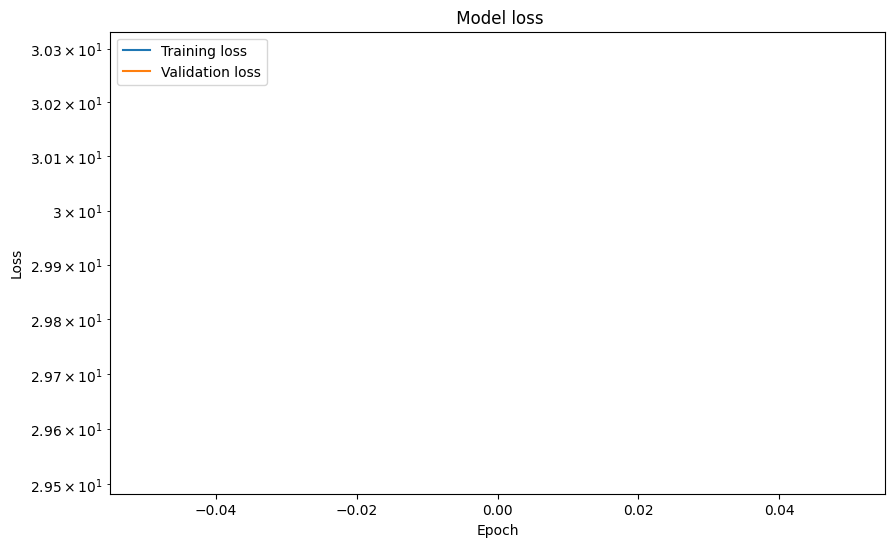

Fitted Weights Hash: 50fd7894074443a98941376794474774
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case TPEO3_202401
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type': 'exp'

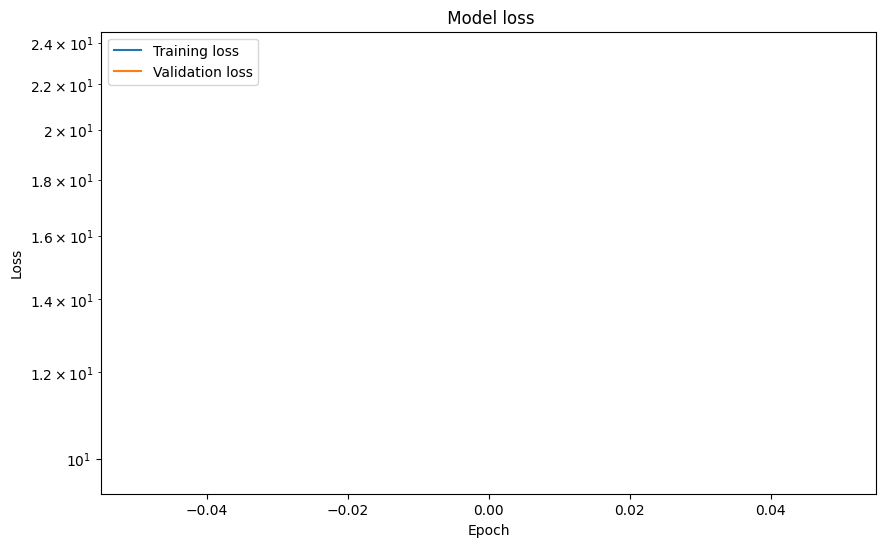

Fitted Weights Hash: a4eee1f63e4eaaaa9d416117a622eb5c
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case ATFO3_202401_set_4
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

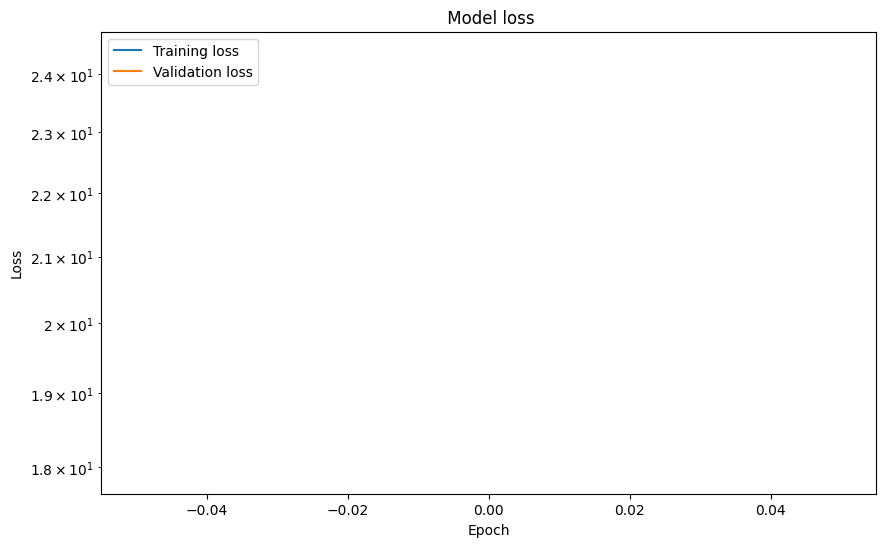

Fitted Weights Hash: 22b3769ecc0386205393ada695c9f50e
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case WMFO3_202401_set_5
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

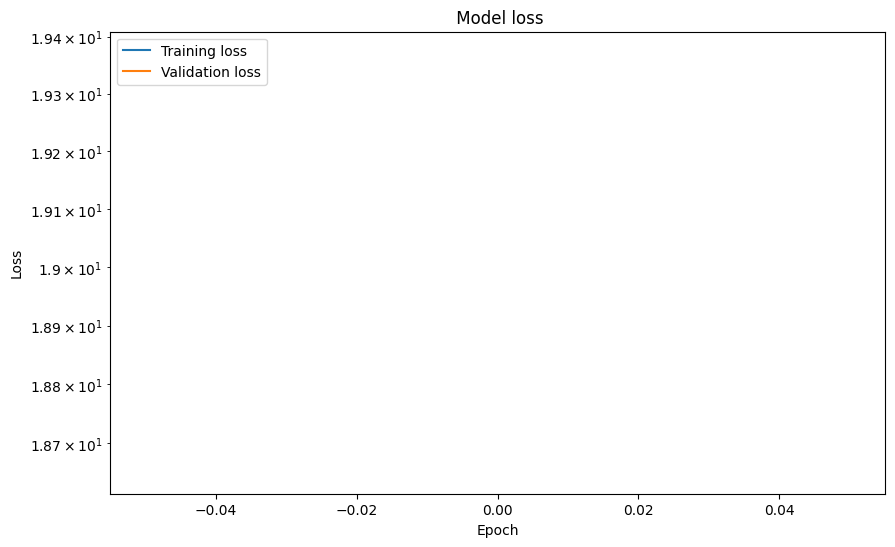

Fitted Weights Hash: d251671151eb431437176e970aa61fec
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case MSFO3_202401_set_4
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

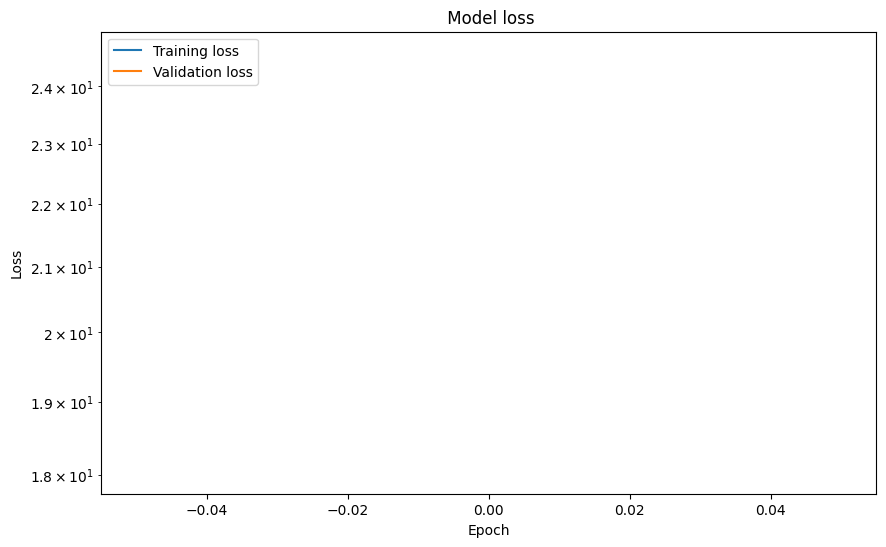

Fitted Weights Hash: bf7a76e93593462b0906060742a9ba33
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case FMFO3_202401_set_4
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

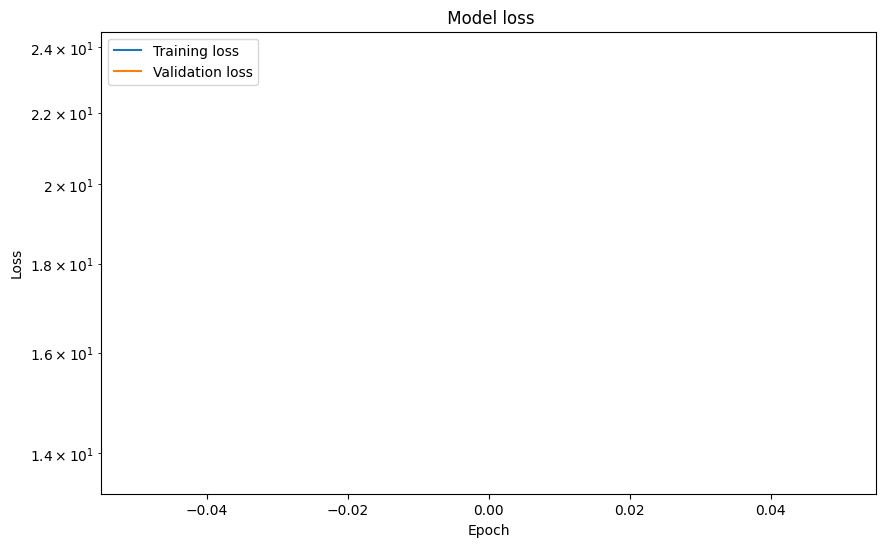

Fitted Weights Hash: c67e08df530ab48f569b982532b68b32
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case TPEO3_202401_set_4
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

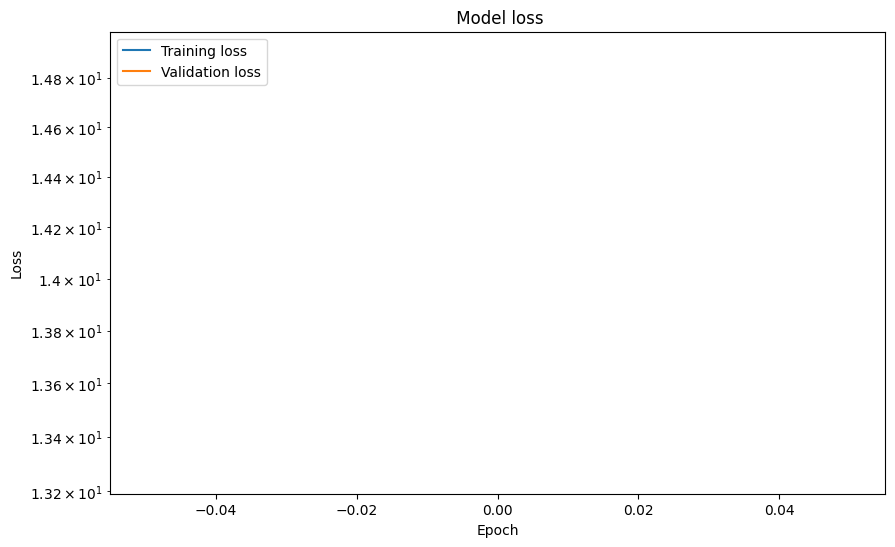

Fitted Weights Hash: a1a26a187e373ec58e757fa8e4001974
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case BMFW1_202401_set_4
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

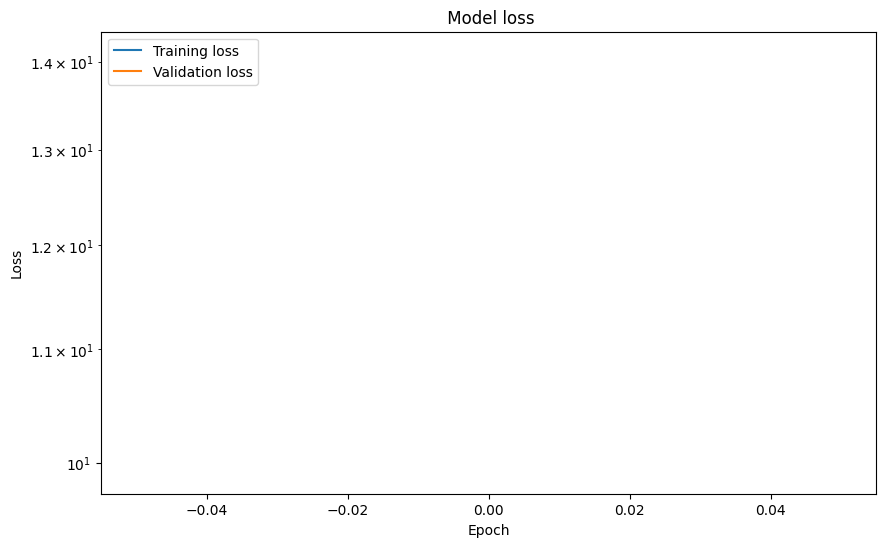

Fitted Weights Hash: 3687b92a3d9c73da5152a8f8159ddebc
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case CMFW1_202401_set_3
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

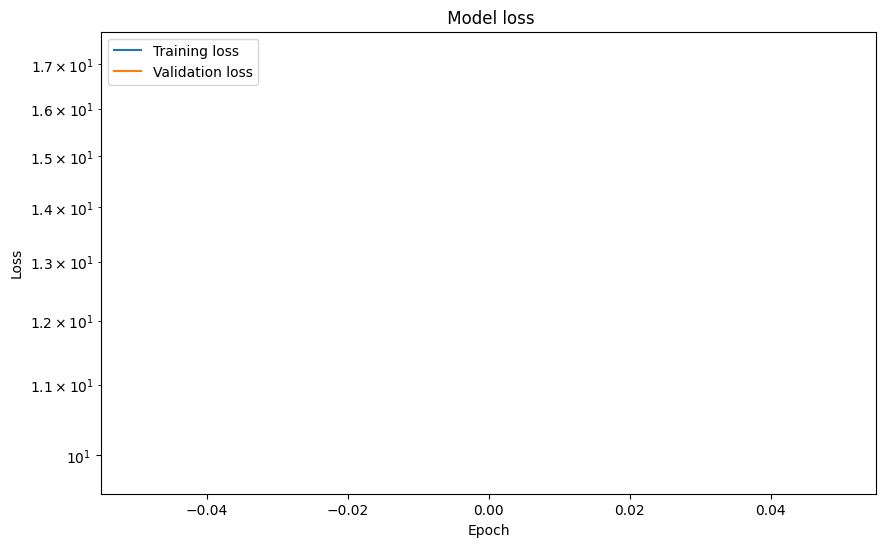

Fitted Weights Hash: c994135087713e0dcec9530dcb7ad22a
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case RNFO3_202401_set_5
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

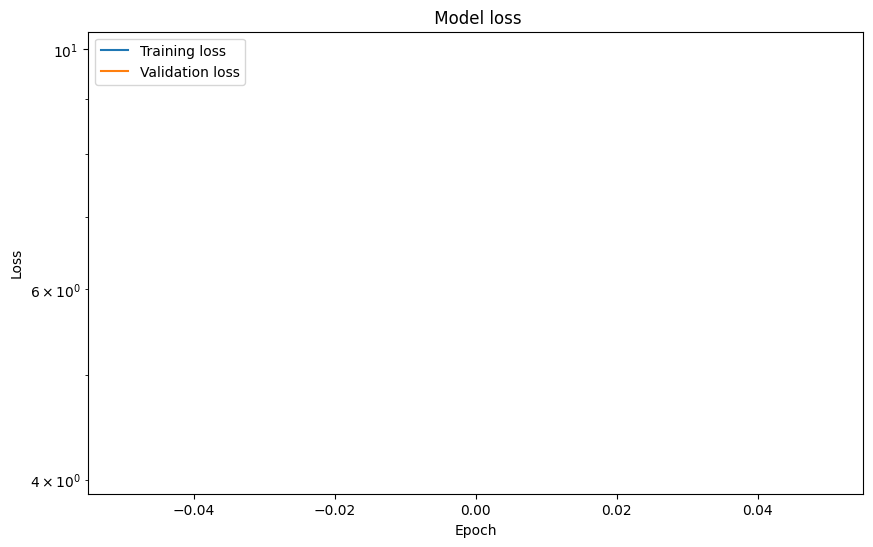

Fitted Weights Hash: 900699e95206f1aed8c48f59ff9bac28
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case DIFW1_202401_set_3
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

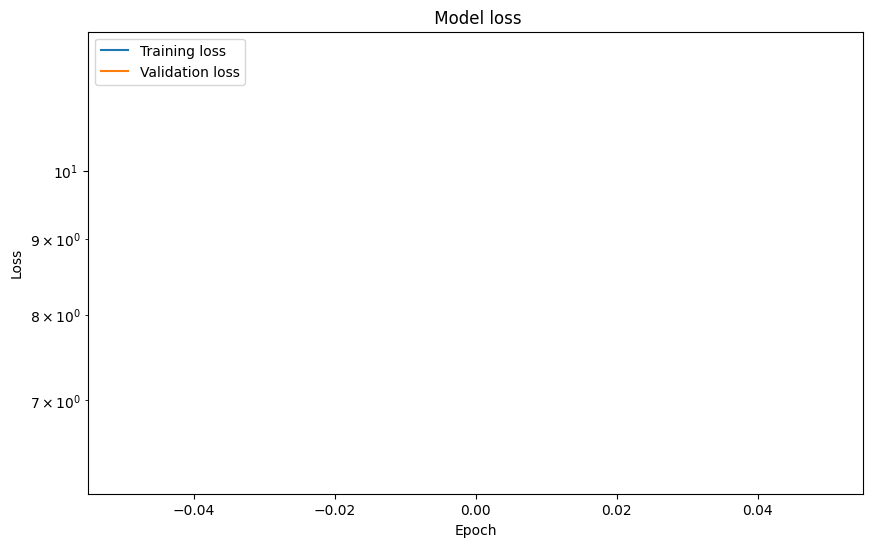

Fitted Weights Hash: 53440b40261d022983b56b18a15d18fb
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case HYFO3_202401_set_3
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

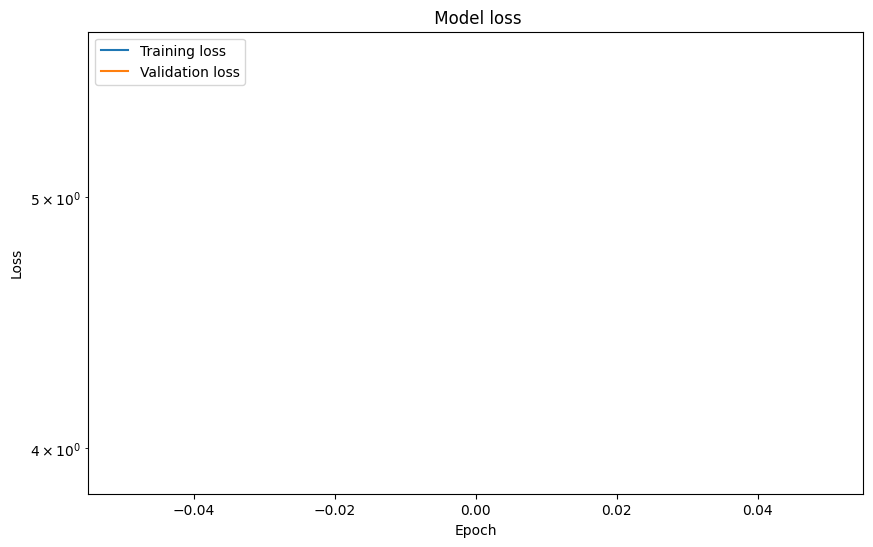

Fitted Weights Hash: 22e8d03186020a016779a41ed877d5e1
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case DMFW1_202401_set_5
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

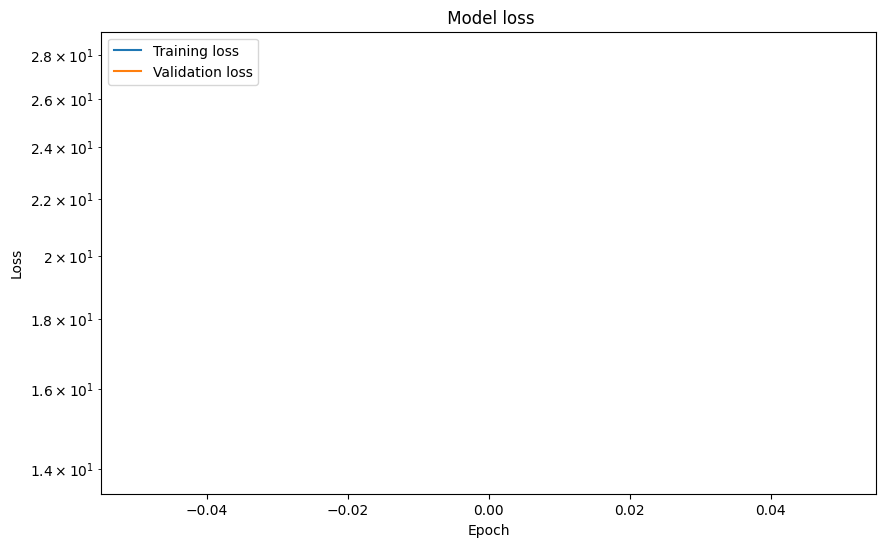

Fitted Weights Hash: e1d3939ac028a5ebde2a3affd4f36765
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case SQFO3_202401_set_5
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

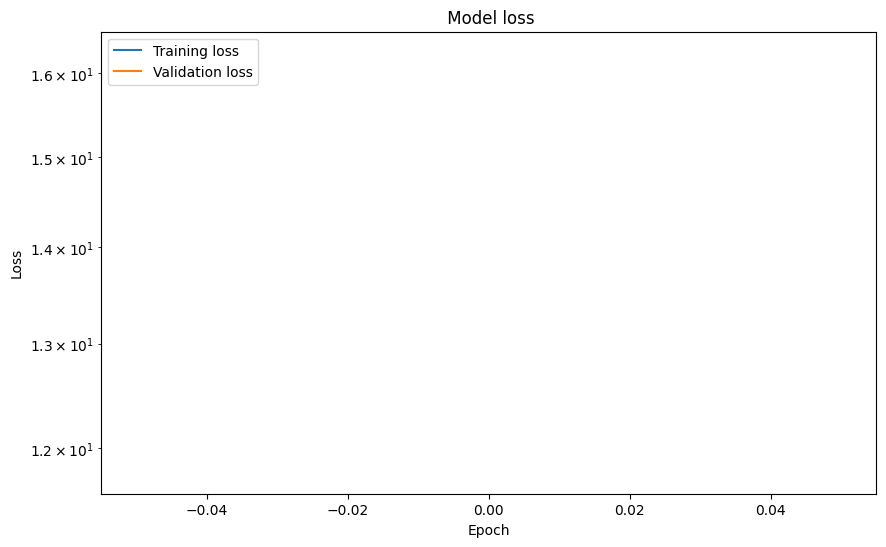

Fitted Weights Hash: 7f87c81b5d116bdfecf3691a23d6f47d
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case CWFO3_202401
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type': 'exp'

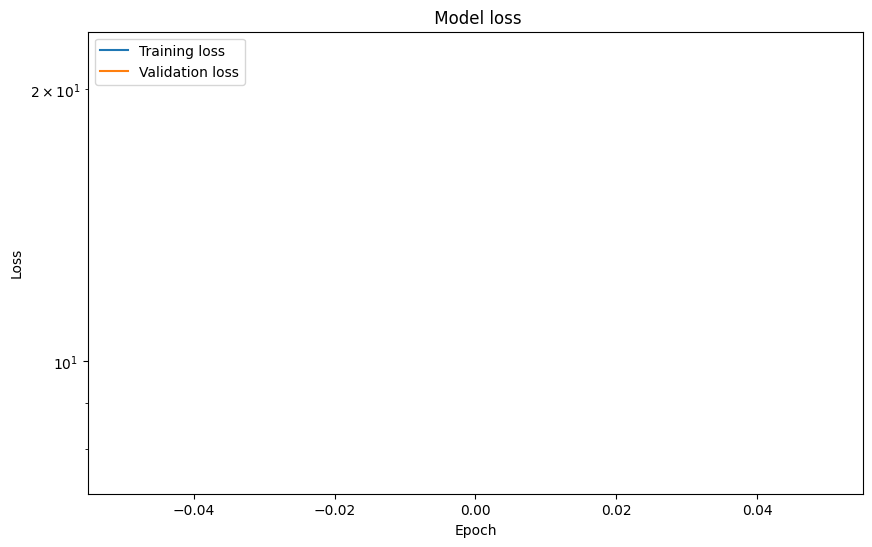

Fitted Weights Hash: 4e7dec8763bc732bfc226470ab8c9986
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case CIFO3_202401_set_5
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

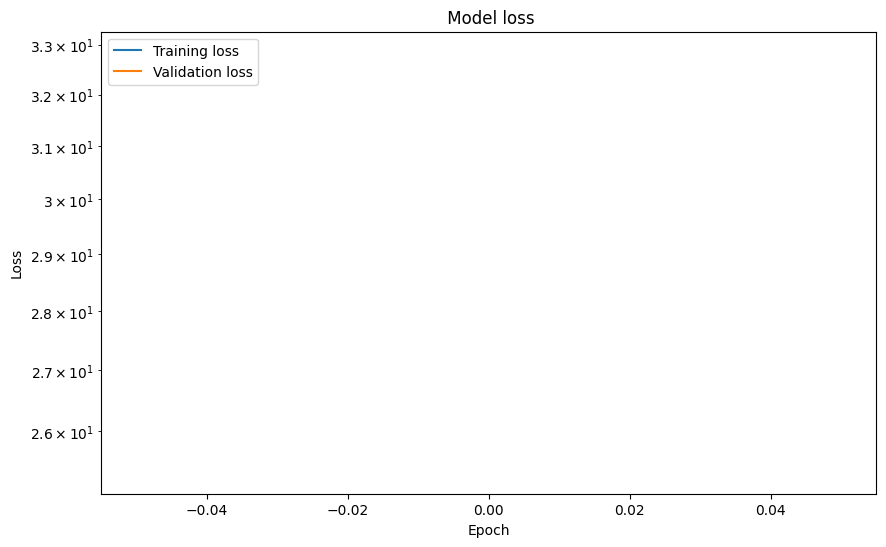

Fitted Weights Hash: d12255cbbf790795ed90c7caefe51a17
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case LBFO3_202401_set_5
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

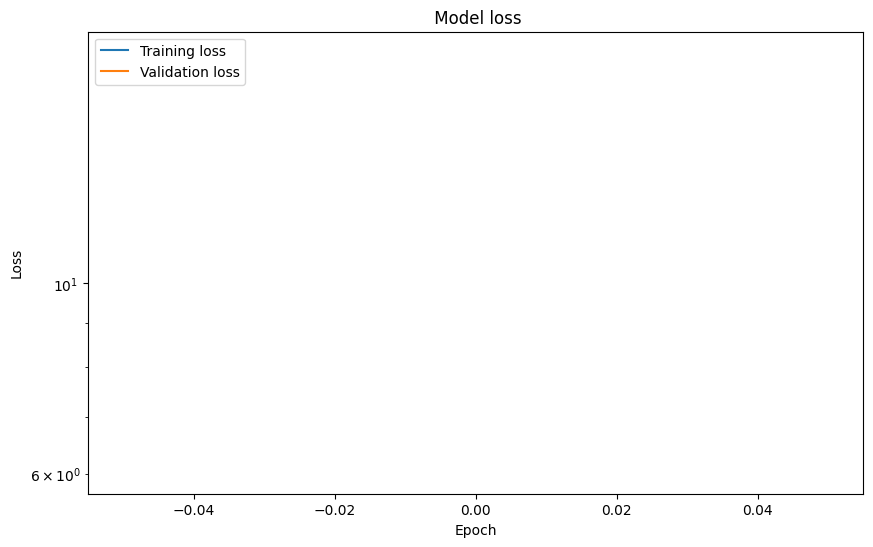

Fitted Weights Hash: b2464a21db685709232a67d47430ef50
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case AGFO3_202401_set_5
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

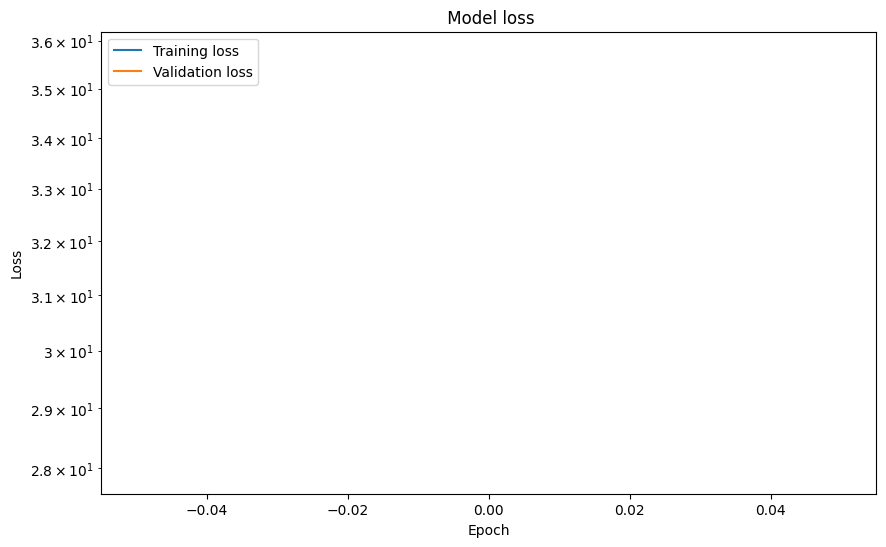

Fitted Weights Hash: ab705fc9ab1ce8579292c089a114f329
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case CAFO3_202401_set_4
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

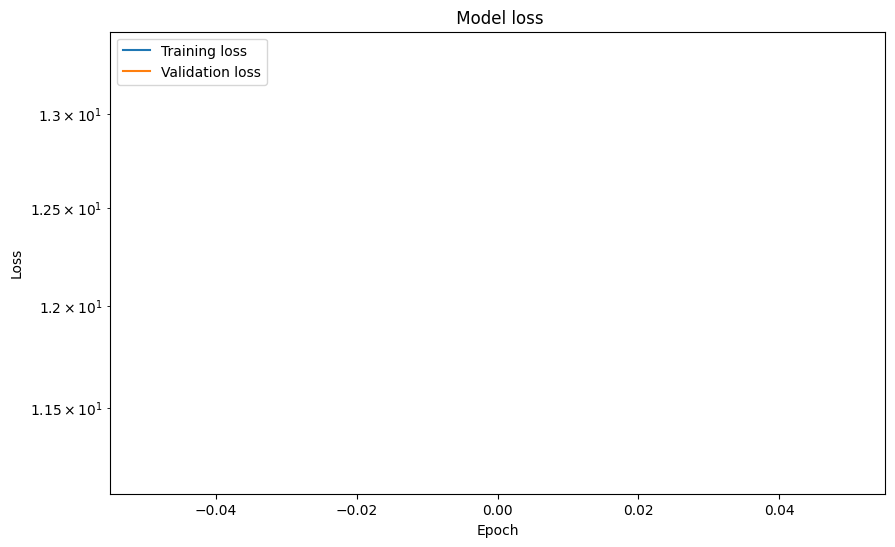

Fitted Weights Hash: 3062f38378bf3920ce1477141e1d6050
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case LSFW1_202401_set_5
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

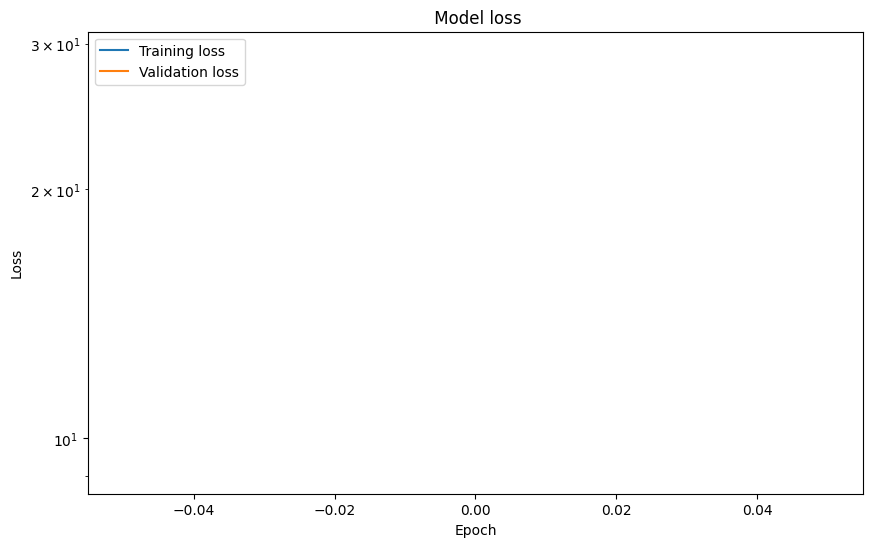

Fitted Weights Hash: 93dd01bf18f8d53285fdcc6cce7c9703
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case CWFO3_202401_set_5
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

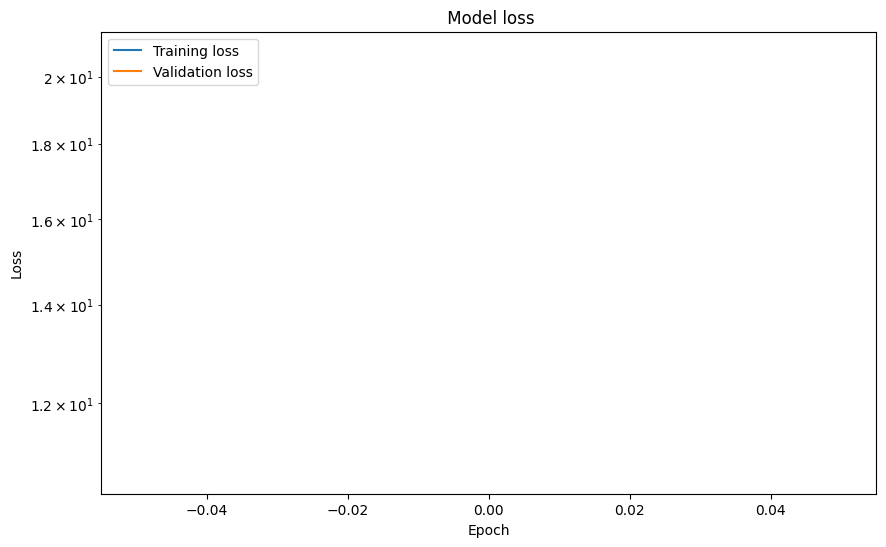

Fitted Weights Hash: e0e80c15ee655dff267aea98d3ec45ca
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case OMFW1_202401_set_4
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

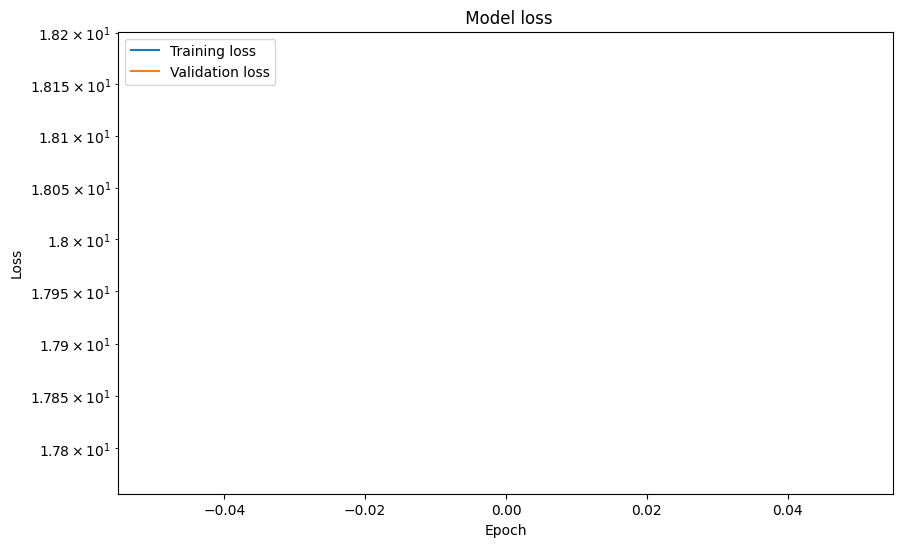

Fitted Weights Hash: 5ebb79dbe971c6226ac1f687223655cb
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case KTLW1_202401_set_5
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

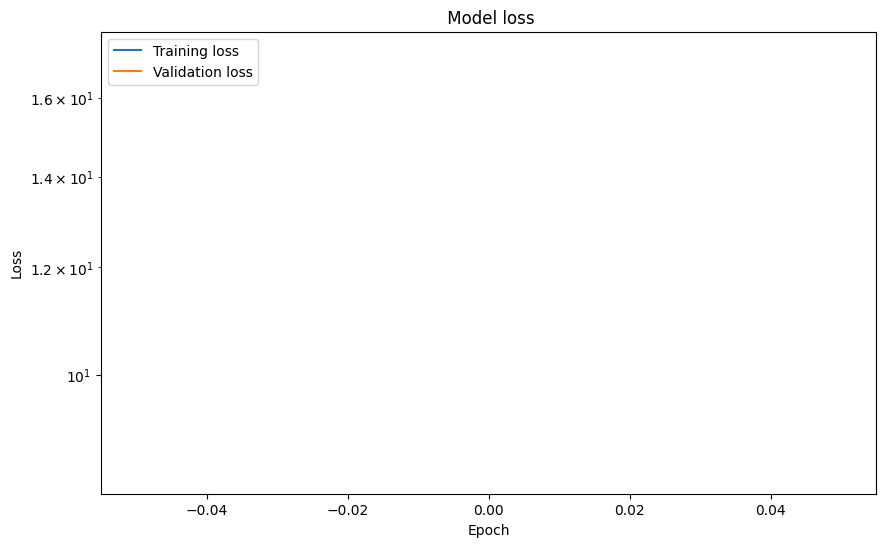

Fitted Weights Hash: d3f59d91eb7c3bcca78b18ceaf0e7396
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case PLFI1_202401_set_5
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

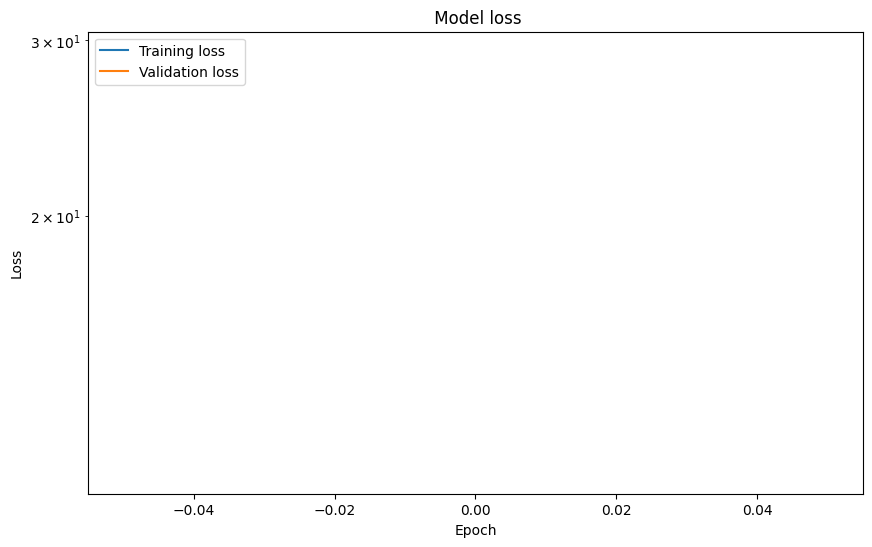

Fitted Weights Hash: 7d17feb7da6251f1149a6fe113ba63fa
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case SKKW1_202401_set_5
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

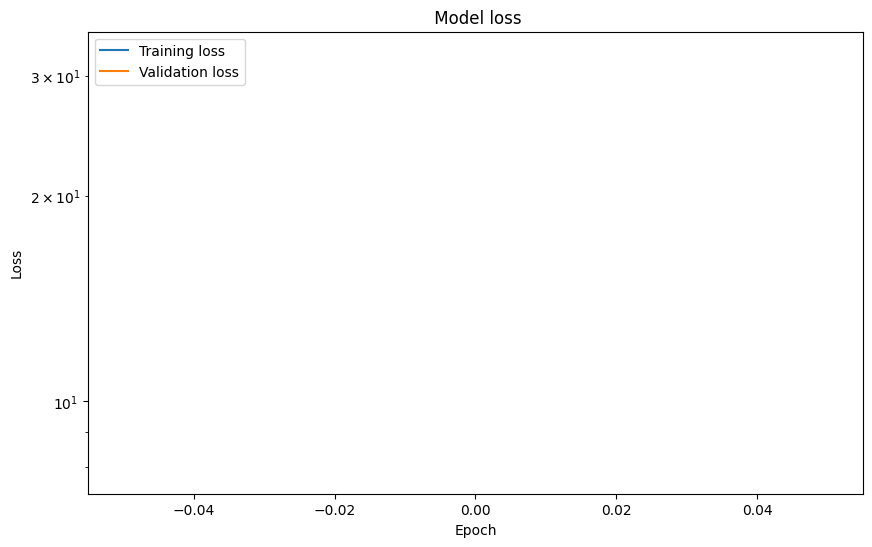

Fitted Weights Hash: 7c030d720f86559e2dfc6426d9eba842
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case BMFW1_202401_set_3
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

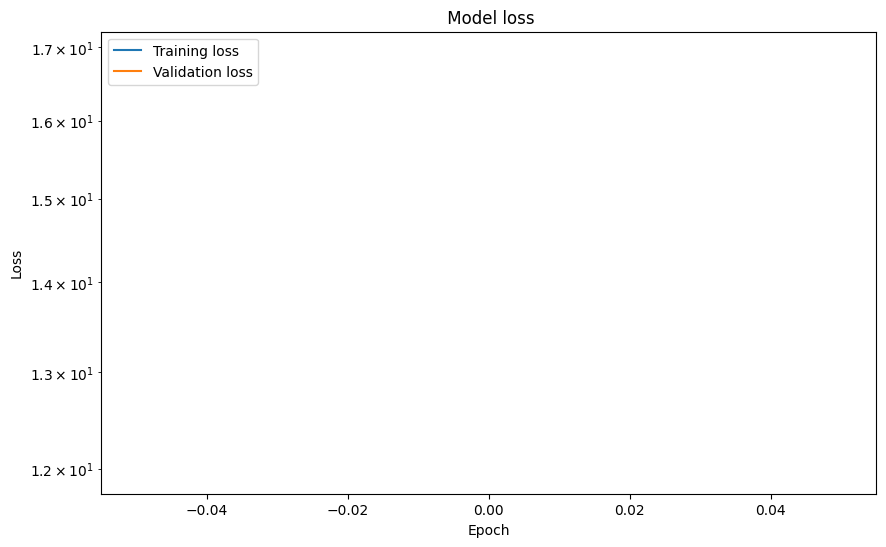

Fitted Weights Hash: 59c707850cadc49f33c670f9454ca8ff
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case ENFO3_202401_set_4
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

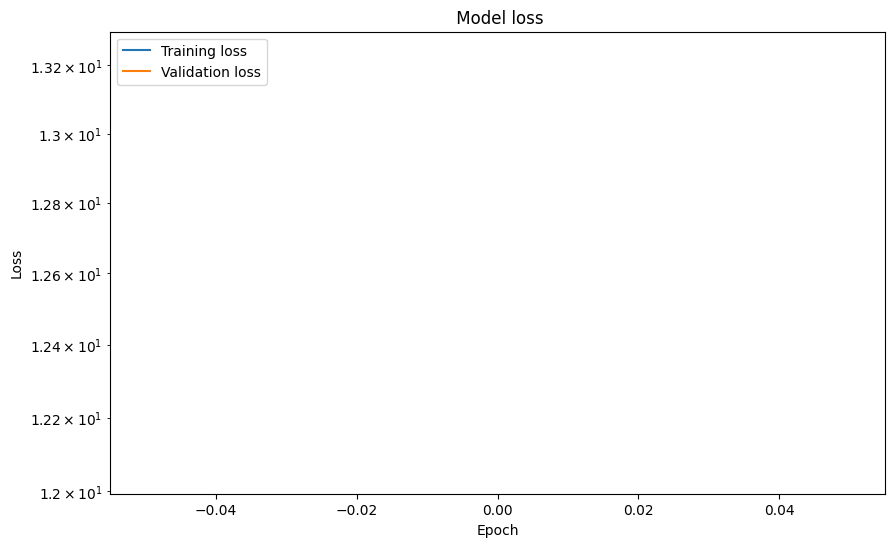

Fitted Weights Hash: d4afafbfb776eae35651448682b5b4f3
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case QCNW1_202401_set_4
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

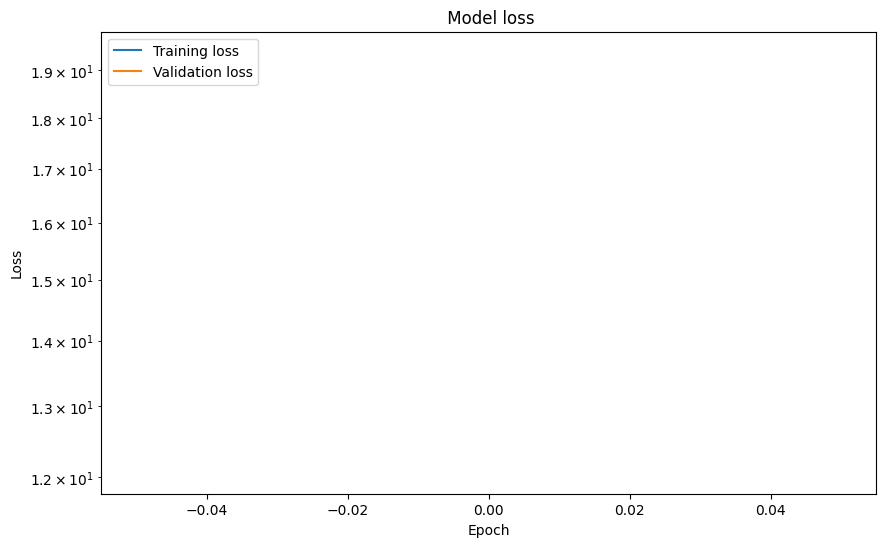

Fitted Weights Hash: a41637b27e8495e39c2f157a81492543
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case ENFO3_202401_set_3
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

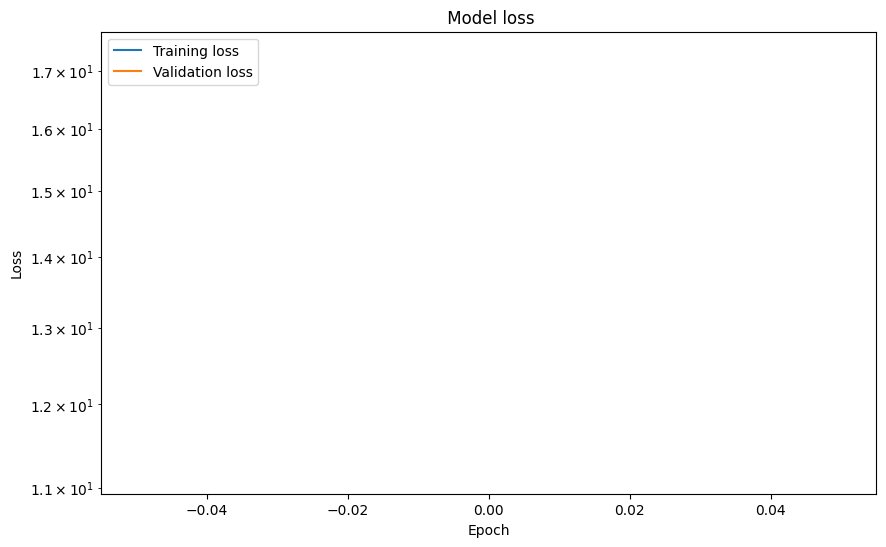

Fitted Weights Hash: 9c5a119c95f6ddd7704869ab6d9284db
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case NCSW1_202401_set_5
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

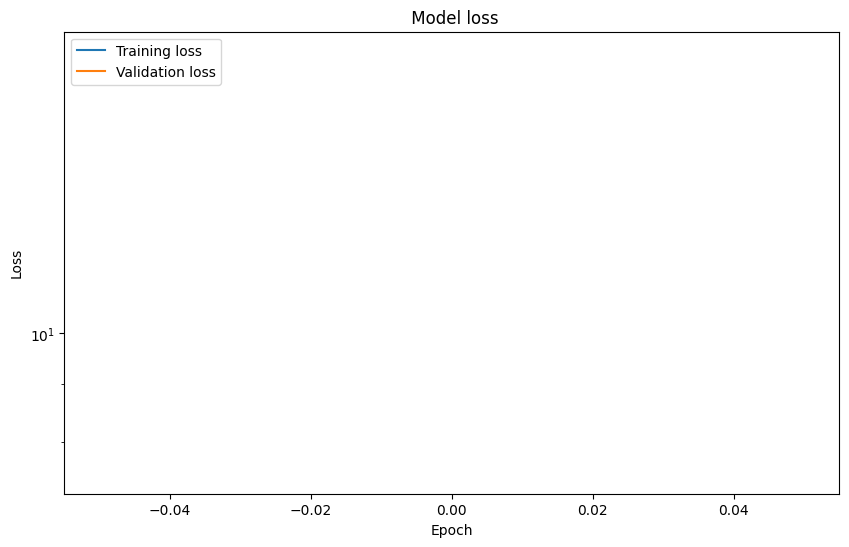

Fitted Weights Hash: 0b0dcad048c15ad6ce764e6240cd78ac
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case LLFW1_202401_set_3
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

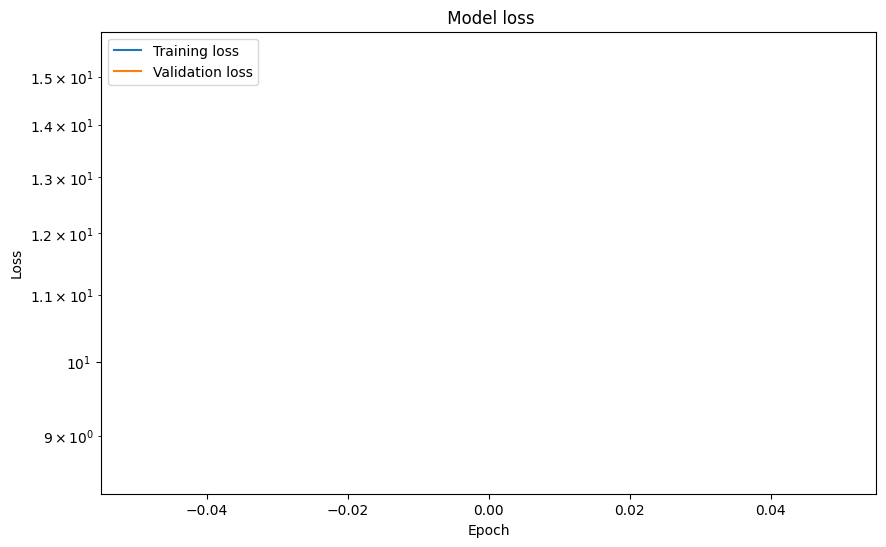

Fitted Weights Hash: 26b69ca6e2bef8c337a29dc115e6f82a
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case DMFW1_202401_set_2
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

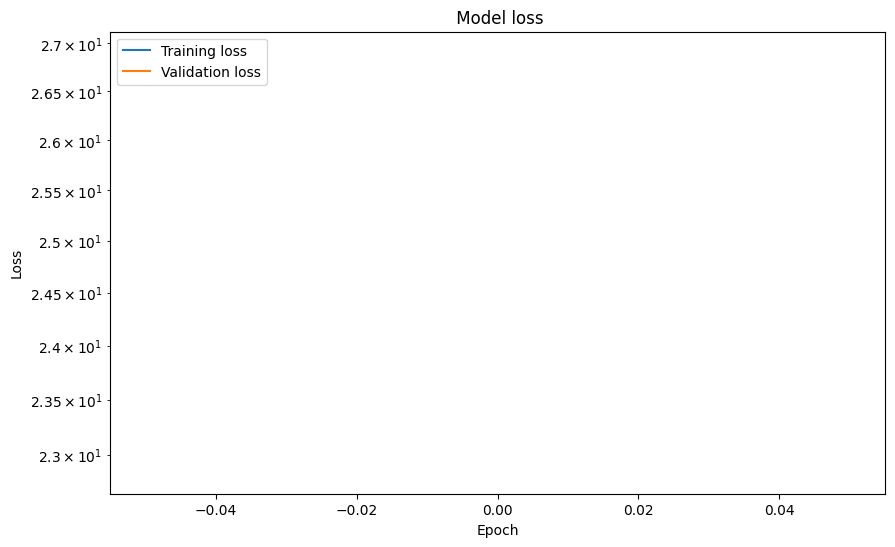

Fitted Weights Hash: f6b8c769b0e86d20f212e3ebbfb8451b
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case IRFO3_202401_set_5
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

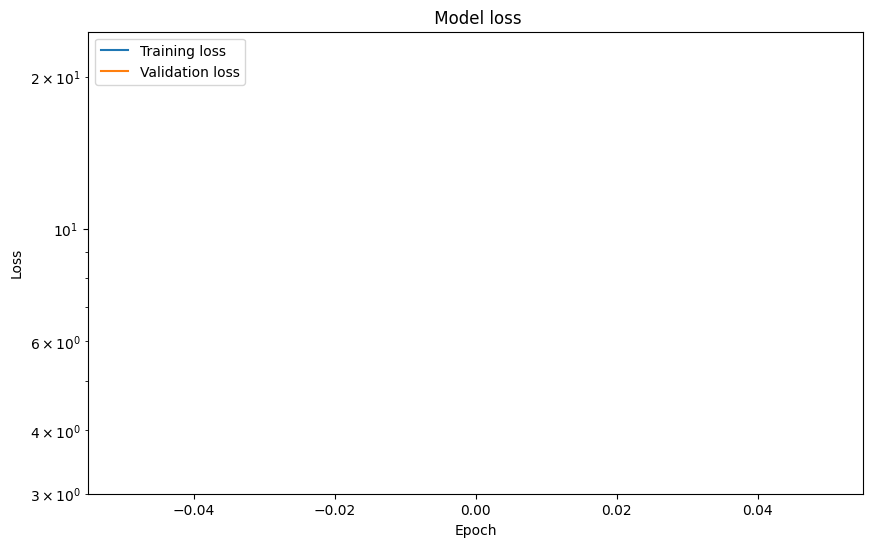

Fitted Weights Hash: 5b9df5dbb9423fac29b32b41671ead76
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case BTFO3_202401_set_3
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

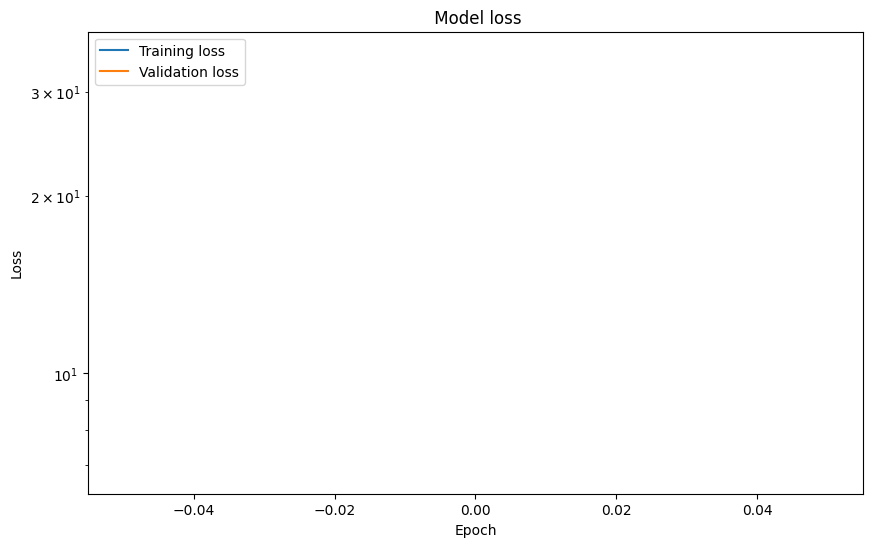

Fitted Weights Hash: e8afe72e20f1b713c82f81d296db902d
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case FBFW1_202401_set_4
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

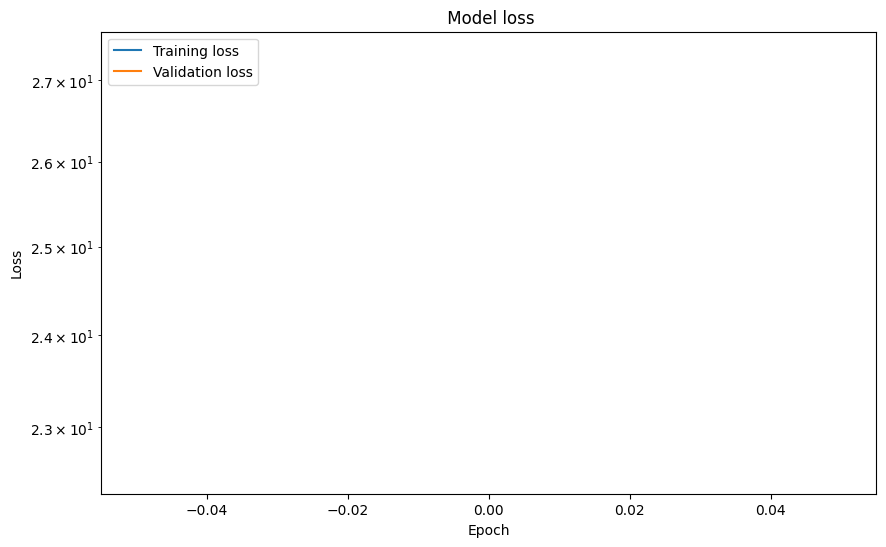

Fitted Weights Hash: f3818a93b3e4a9f70d295bcc05616d69
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case CGFO3_202401_set_2
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

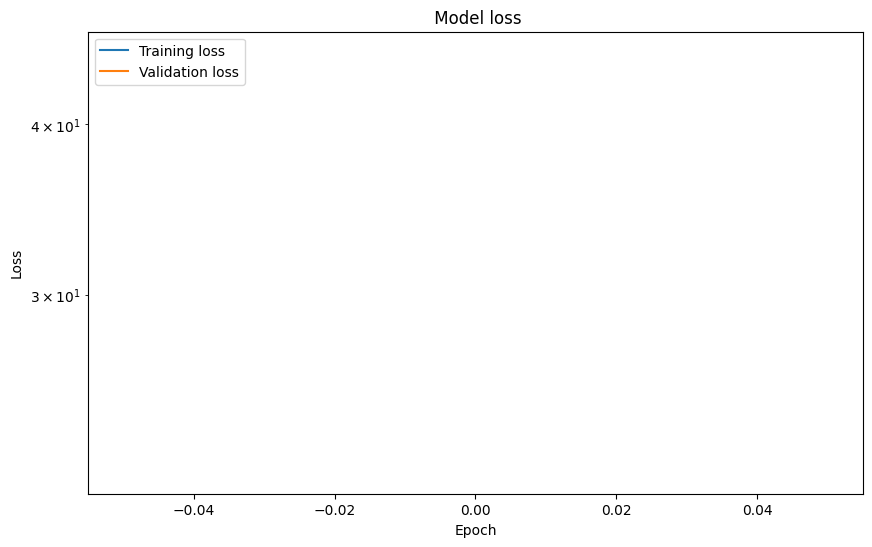

Fitted Weights Hash: ebbde91bbe7afc06752aa8e5ef866236
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case BCFO3_202401_set_5
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

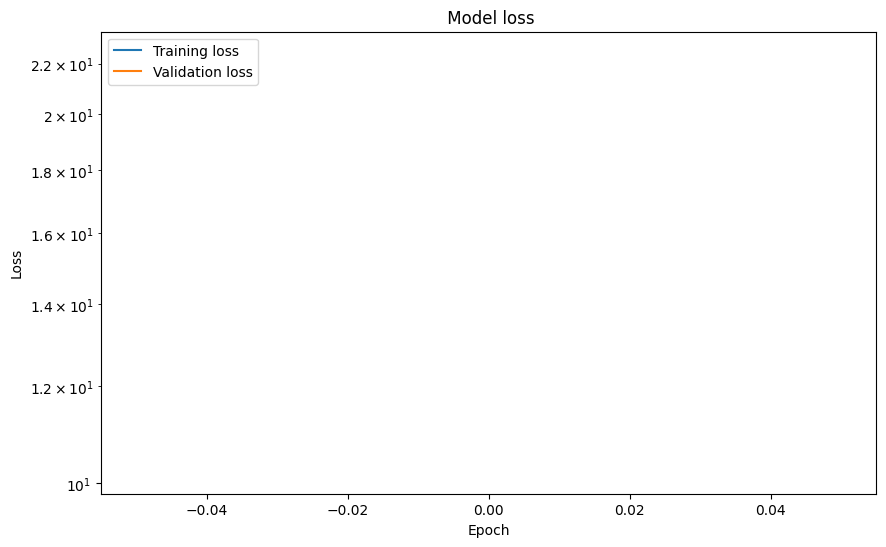

Fitted Weights Hash: 66b182f92c35a82fb2bf601fa5183c98
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case PMFW1_202401_set_5
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

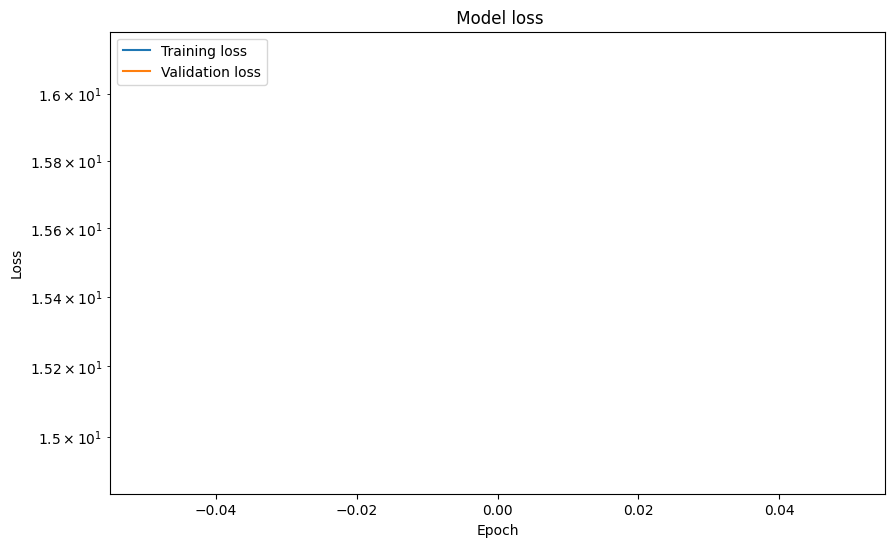

Fitted Weights Hash: 20f916d730746f0a20fa2241354ac0a6
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case FTFW1_202401_set_3
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

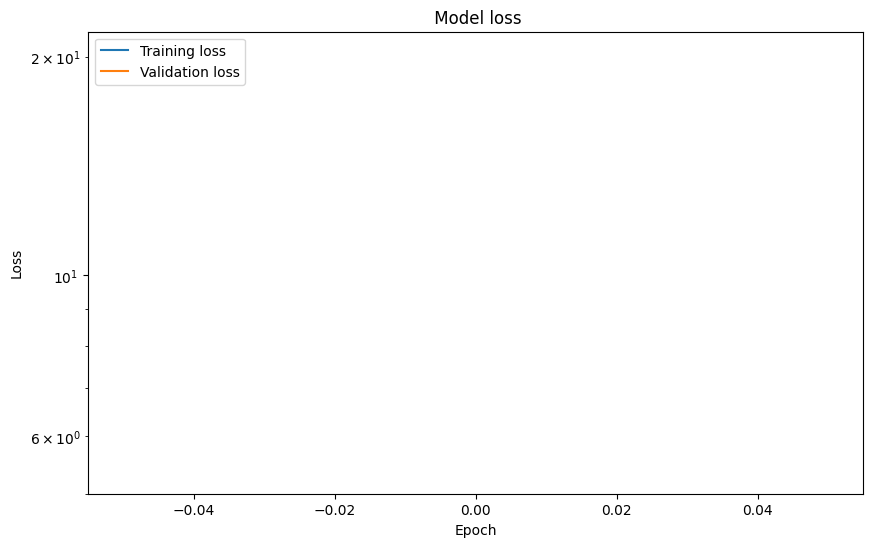

Fitted Weights Hash: a5e481ac6dd58fec688ca46d0a2626e6
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case FTFW1_202401_set_5
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

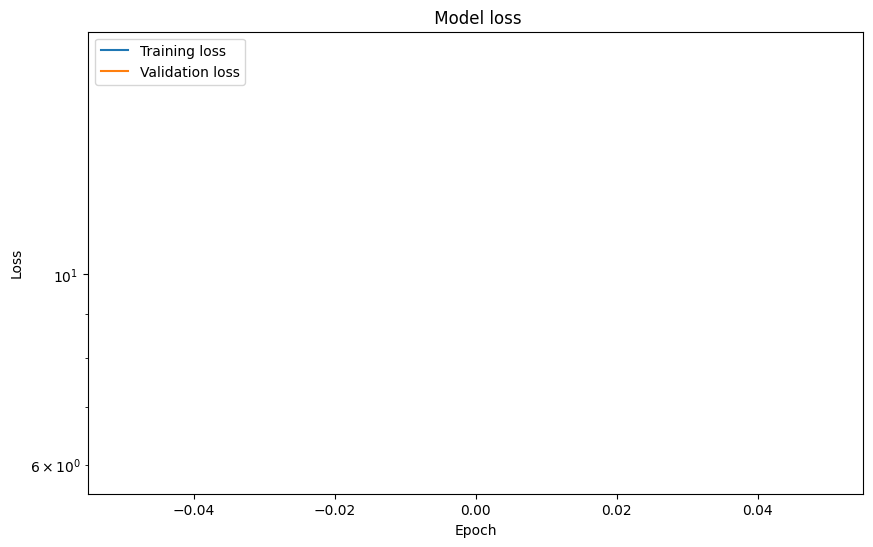

Fitted Weights Hash: bcd79f13627a7df796160758dee8a97e
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case KTLW1_202401_set_4
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

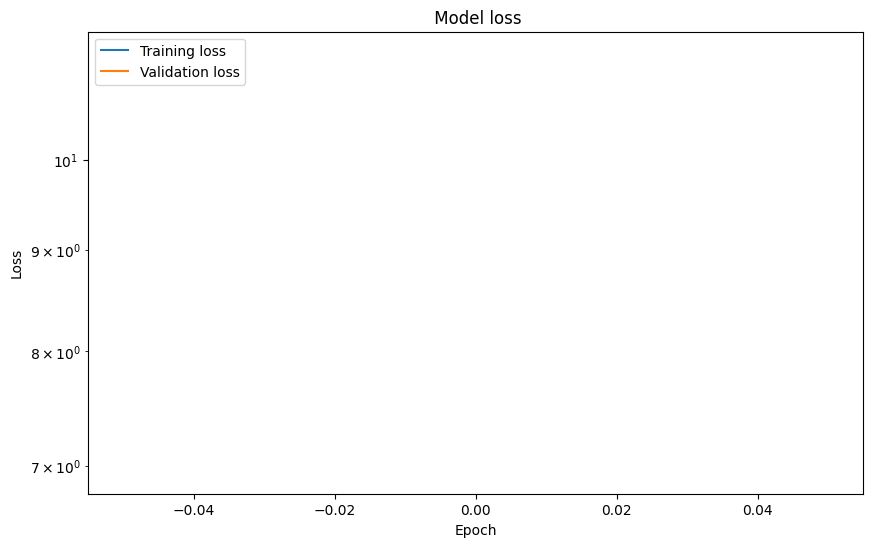

Fitted Weights Hash: 4d76b832083fe14685abc4eb665a3ad8
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case CMFW1_202401_set_4
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

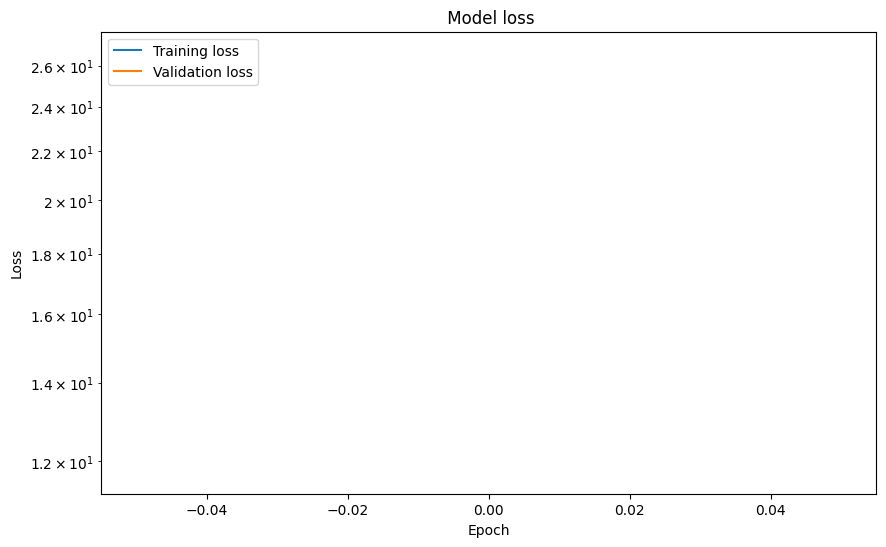

Fitted Weights Hash: a35878e736d6bc864ecb923390395478
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case OMFO3_202401_set_5
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

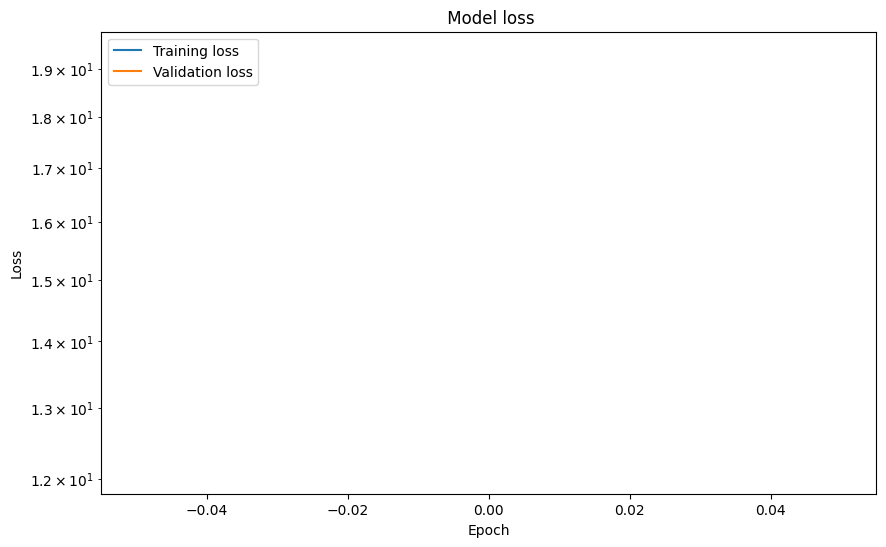

Fitted Weights Hash: e085d64be886845a171c2ad6257a4026
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case LBFO3_202401_set_4
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

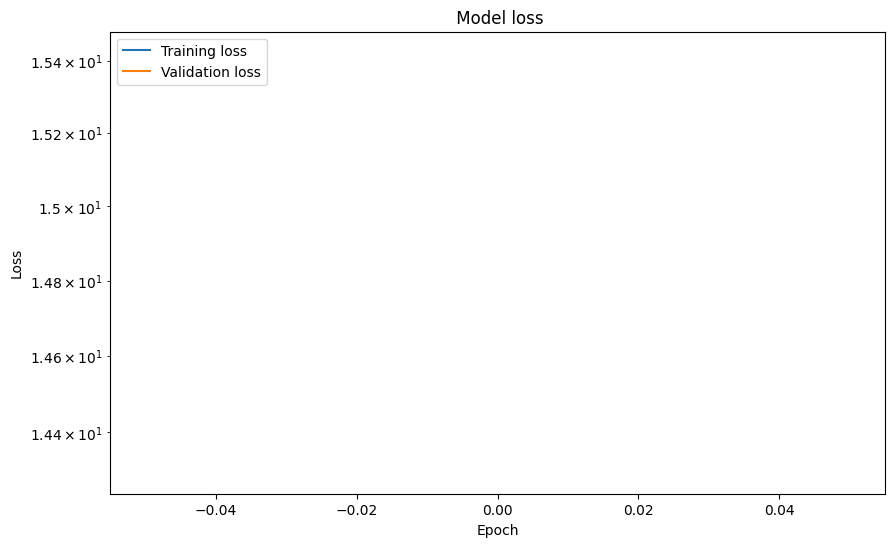

Fitted Weights Hash: b5cadeee4feb4c84d70d79356179c1c2
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case DIFW1_202401_set_4
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

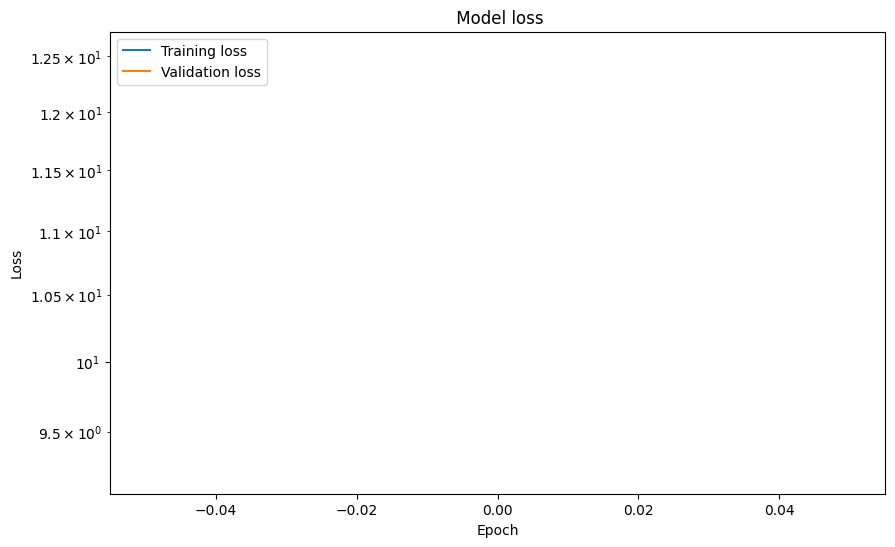

Fitted Weights Hash: d32ff0f91cd0ba9a2bdea6ba1445f574
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case WEFI1_202401_set_2
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

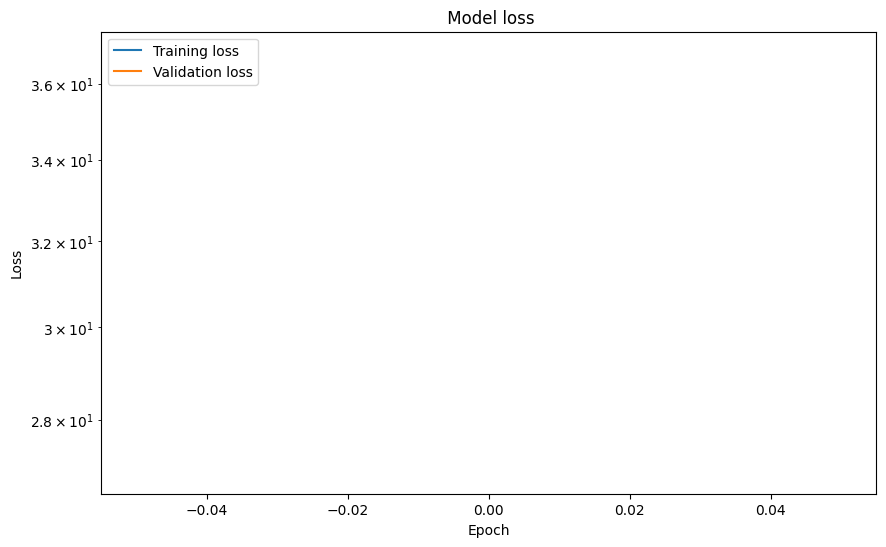

Fitted Weights Hash: 35bda0e8b7b2f07a2adb058101500adb
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case WKFO3_202401_set_4
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

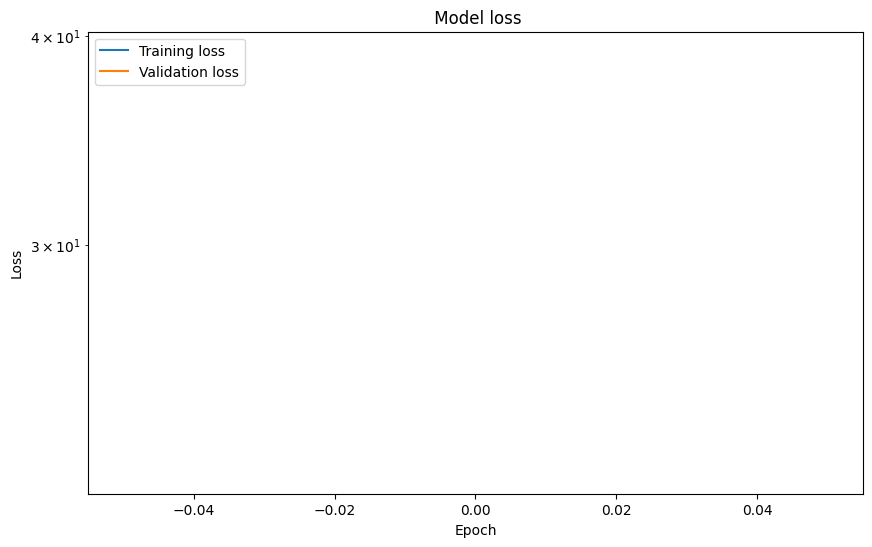

Fitted Weights Hash: 0378ab0c7b3632aa336770e259e58088
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case HYFO3_202401_set_4
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

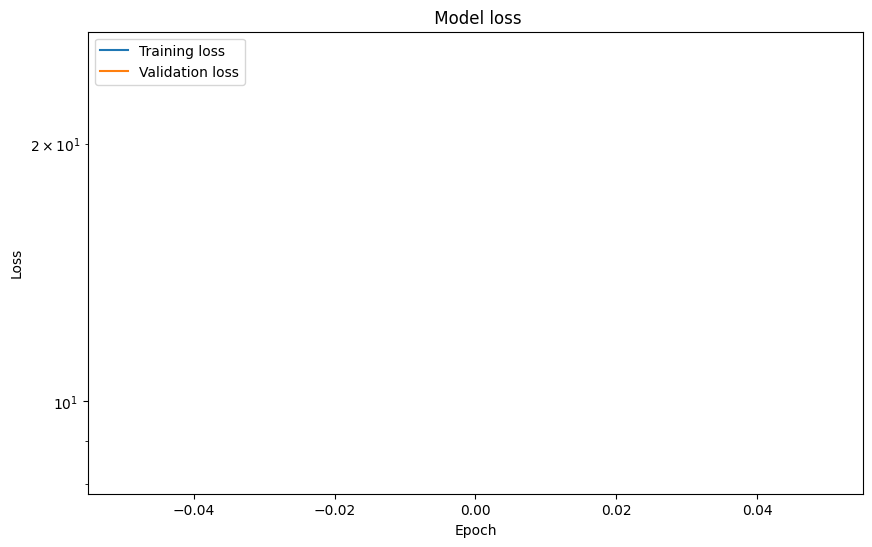

Fitted Weights Hash: 32b9dcf91836d8f2ed66d33fc7157383
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case CPFO3_202401_set_5
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

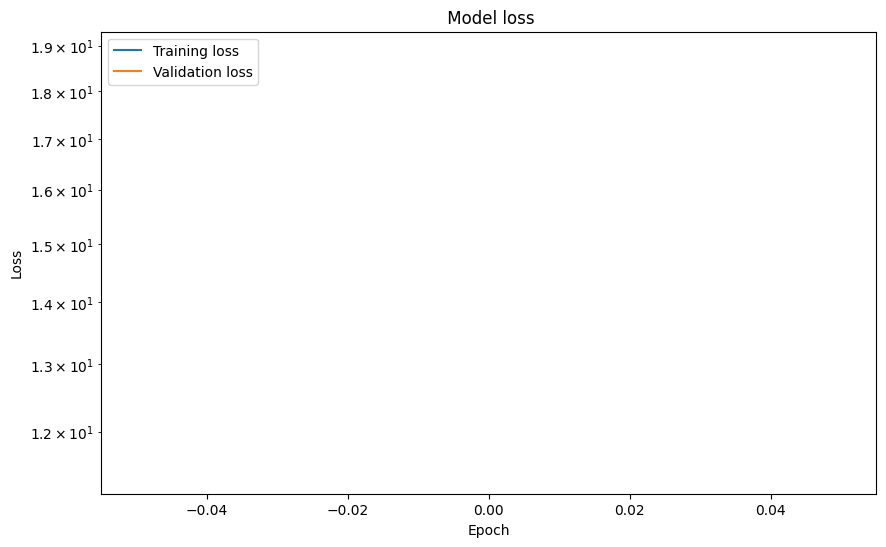

Fitted Weights Hash: 0e7fa92c5c95133d5a2e5c36c03741cc
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case QCNW1_202401
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type': 'exp'

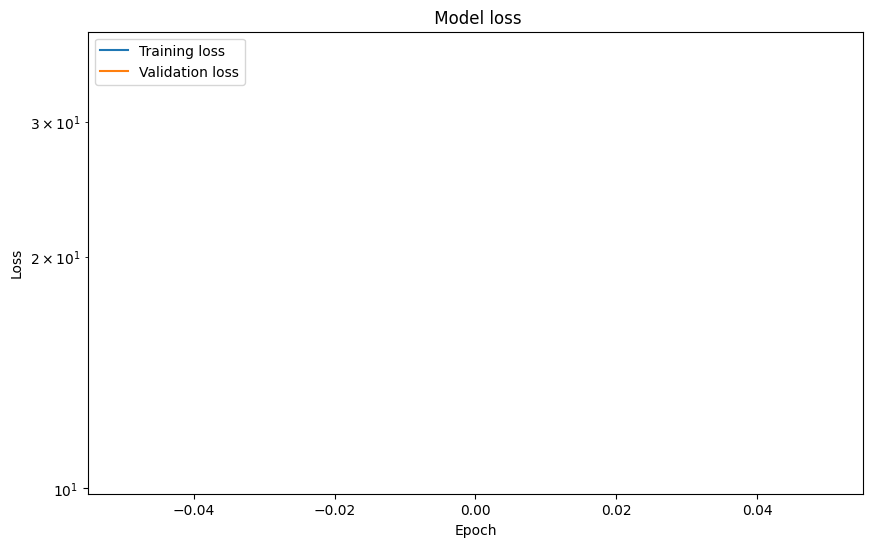

Fitted Weights Hash: 69432c83ef781afdcd059cf08f9c9aef
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case MEFW1_202401_set_3
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

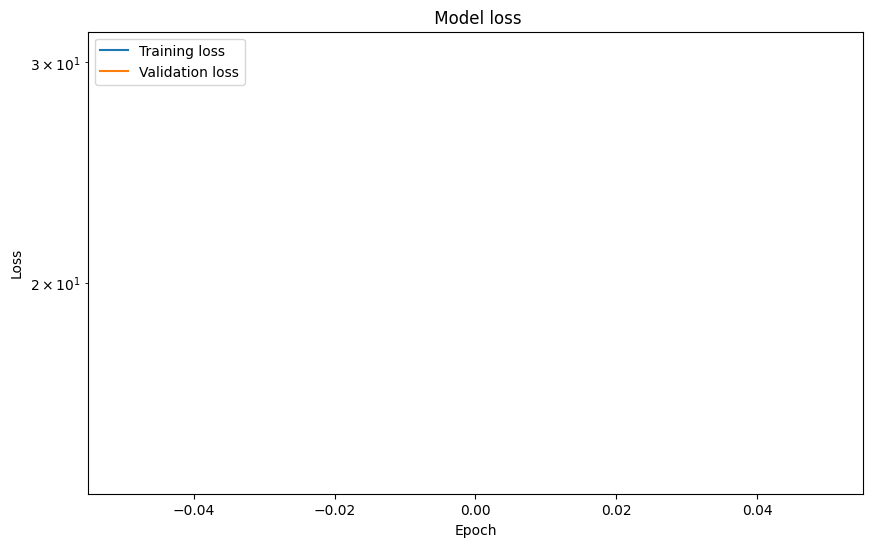

Fitted Weights Hash: 9b779d7f464c166dfb49385c08249aaf
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case PMFW1_202401_set_4
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

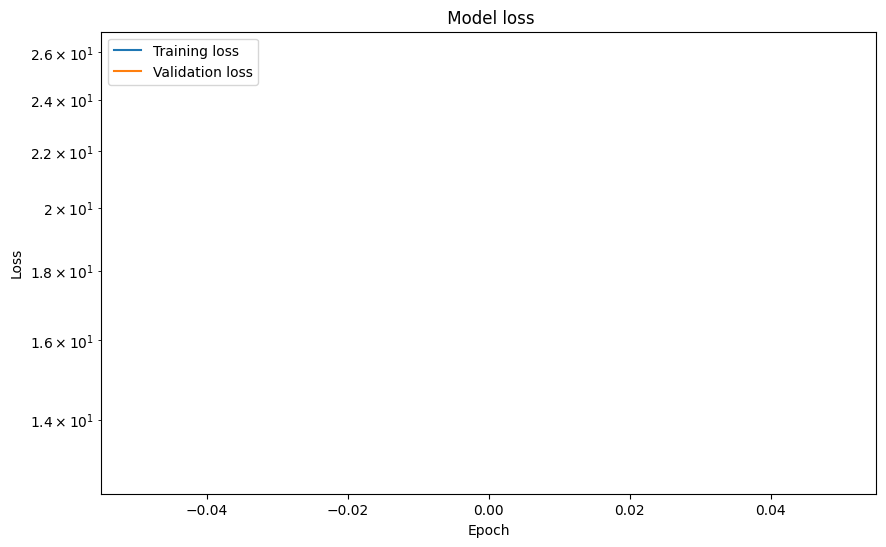

Fitted Weights Hash: 9e78bc6840344c2a43e0669bd977ee9a
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case CIFO3_202401_set_4
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

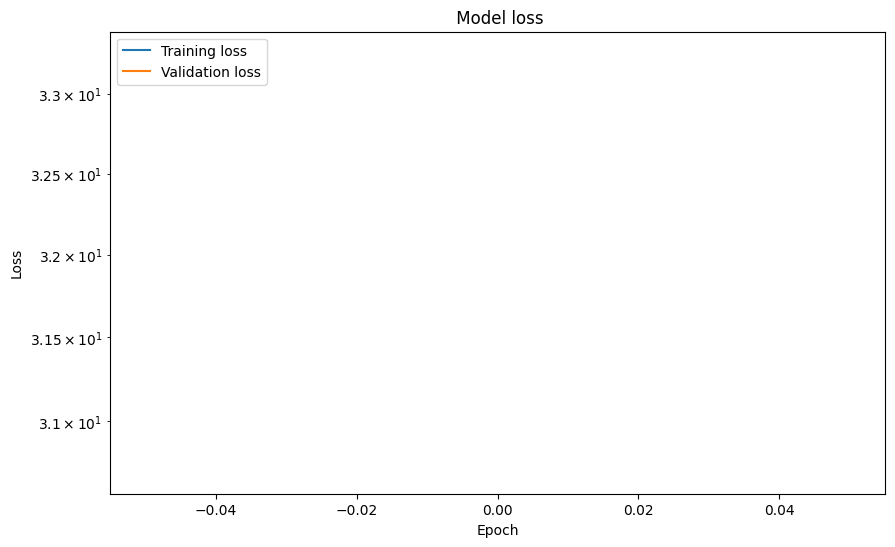

Fitted Weights Hash: 83d274b3ddb5160d13d454f20ffe7359
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case CSFO3_202401_set_2
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

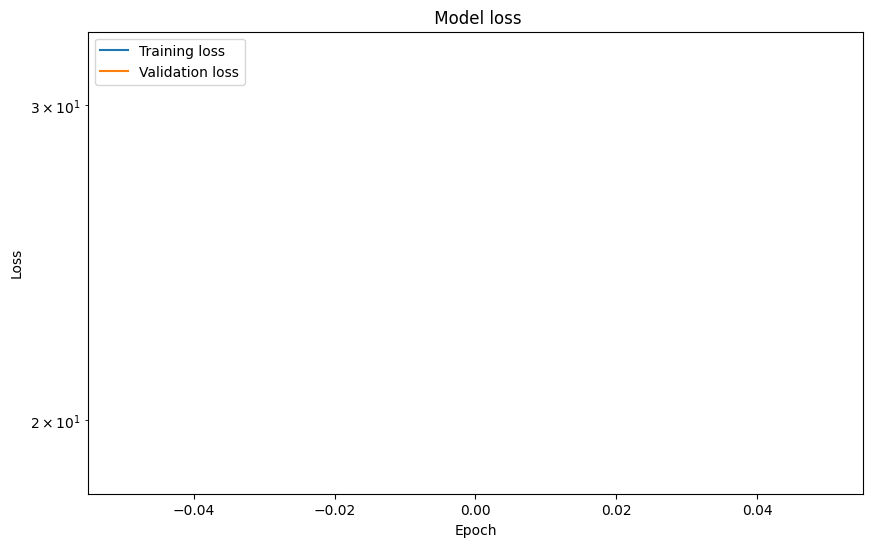

Fitted Weights Hash: 2493c95cf1df8d3ebb78623de86fd910
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case QCNW1_202401_set_3
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

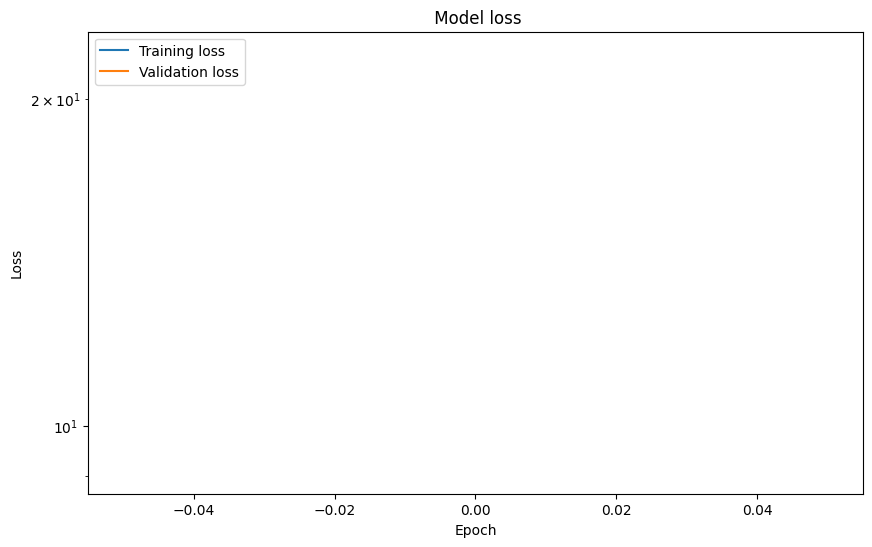

Fitted Weights Hash: 73f299a0528b9f15866aeb50d3a3e95e
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case TUFO3_202401_set_2
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

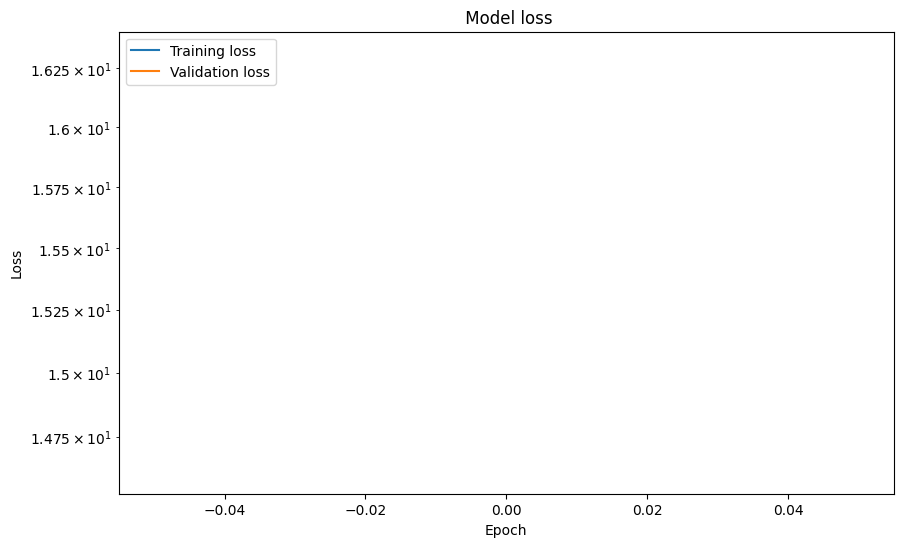

Fitted Weights Hash: 16c09c0f33e7314669b98a74ddc0de6a
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case LEFW1_202401_set_5
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

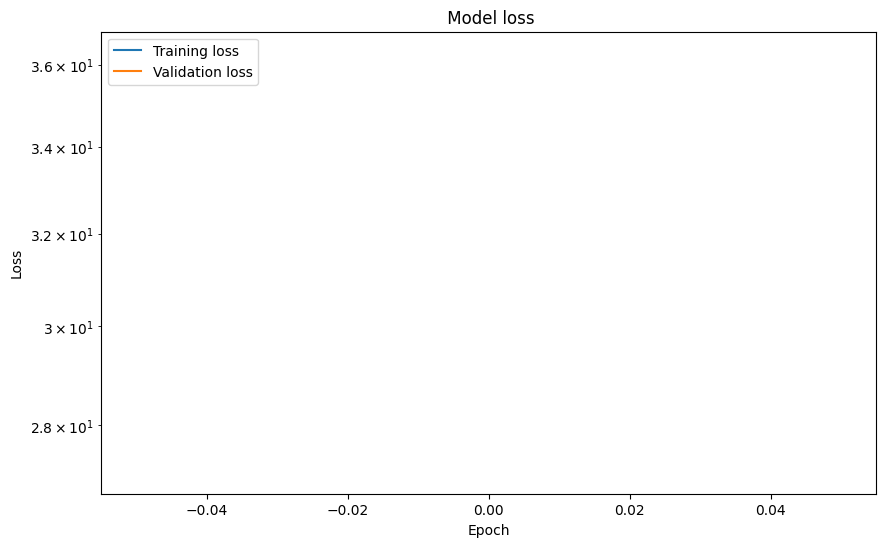

Fitted Weights Hash: 8806528ea492de2e13c1ac14ec431c86
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case KCFW1_202401_set_5
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

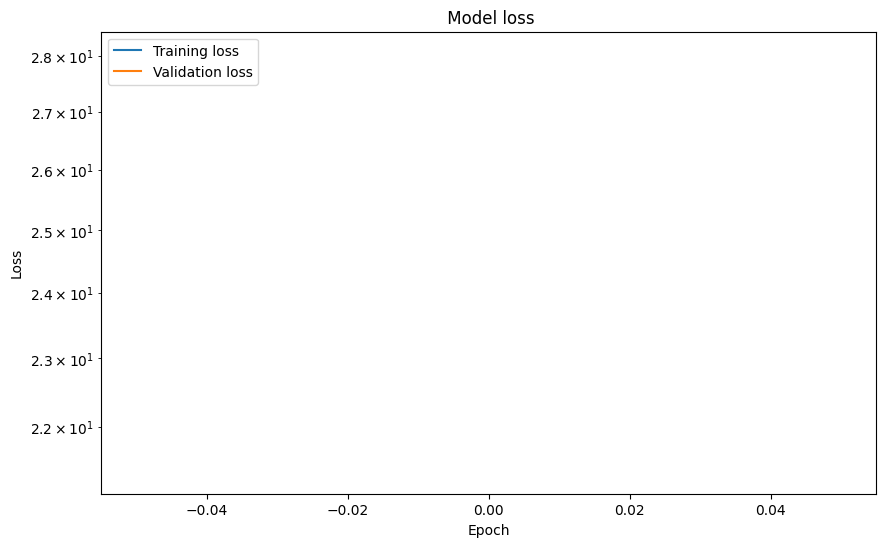

Fitted Weights Hash: 0a750692ba96a330b70fe63740ac56b9
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case BBFO3_202401_set_2
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

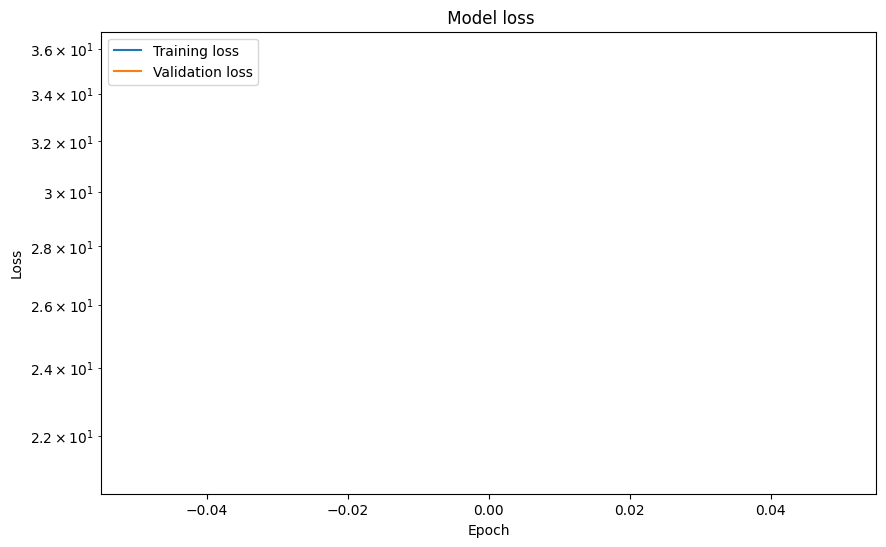

Fitted Weights Hash: ab68e6cc9f067cc1e290f572dab0ffc3
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case CSFO3_202401_set_5
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

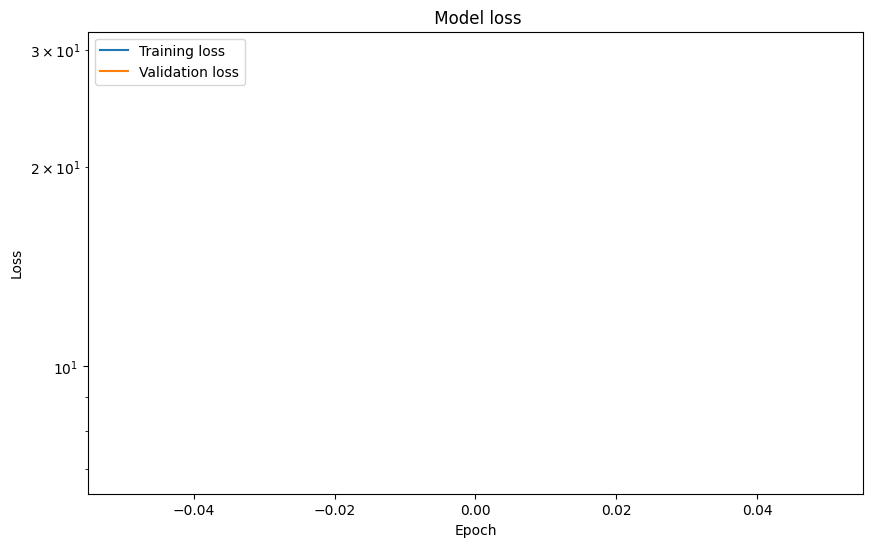

Fitted Weights Hash: e35fc2b9cbf9bdea959956cf36819d9c
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case NCSW1_202401_set_4
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

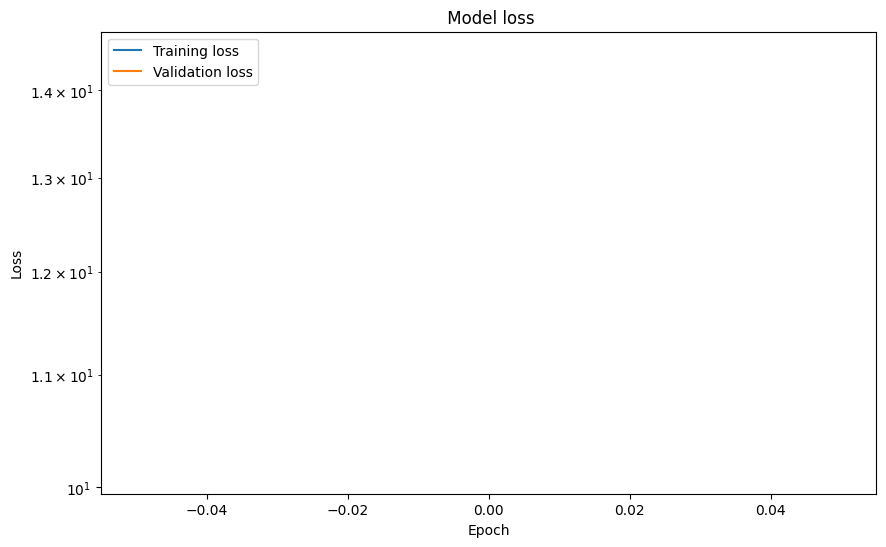

Fitted Weights Hash: fc4949b44cfcdb75262eaa7444b2bc84
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case TUFO3_202401_set_4
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

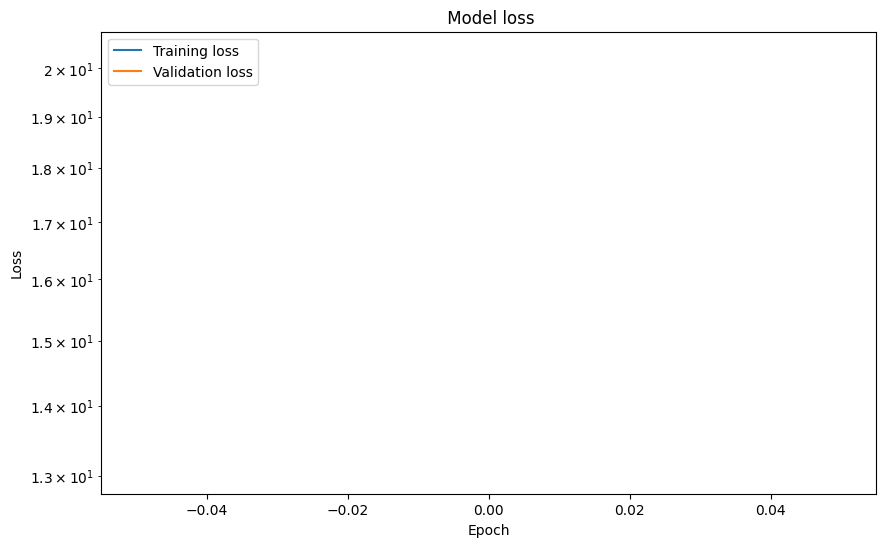

Fitted Weights Hash: 2cc082dac9072f719e6e08dd5a001af0
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case LEFW1_202401_set_4
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

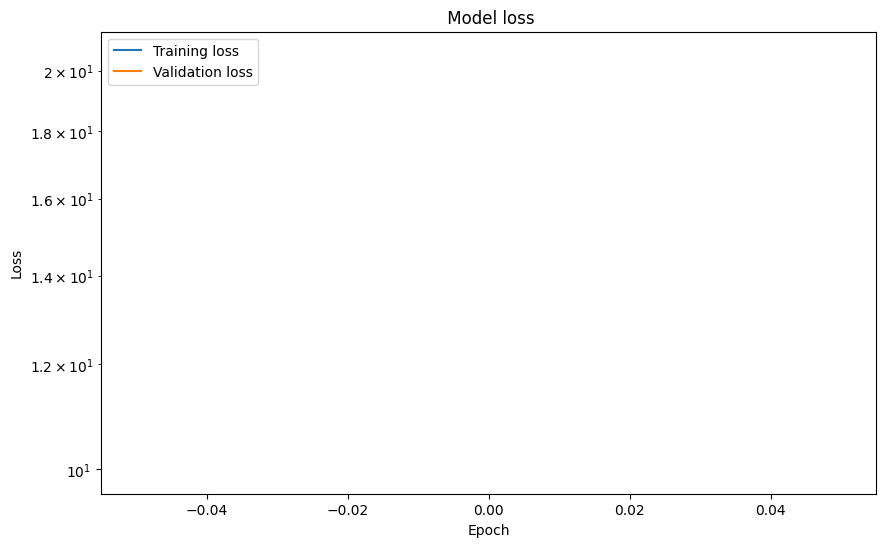

Fitted Weights Hash: 17bbed203719e269d5df0a4aa140d899
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case CGFO3_202401
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type': 'exp'

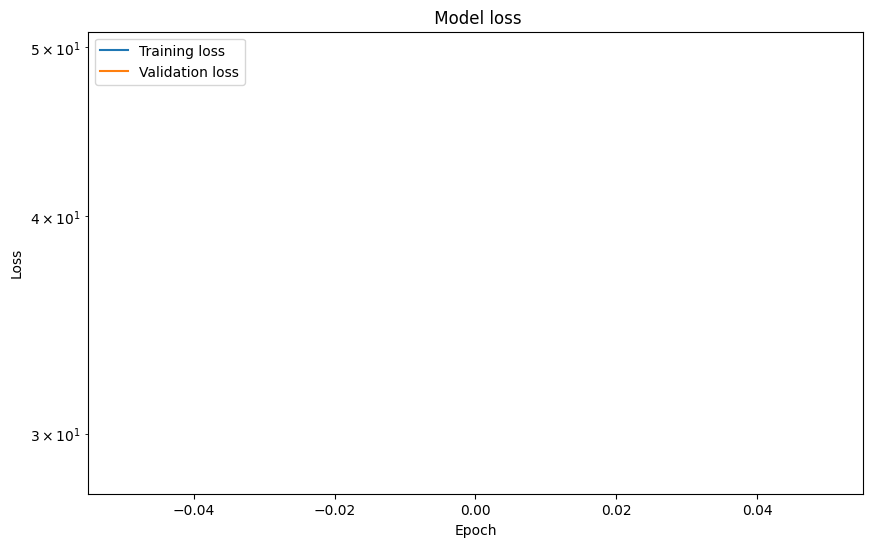

Fitted Weights Hash: f1f26b4f34f3246873cd47da462a430c
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case TPEO3_202401_set_5
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

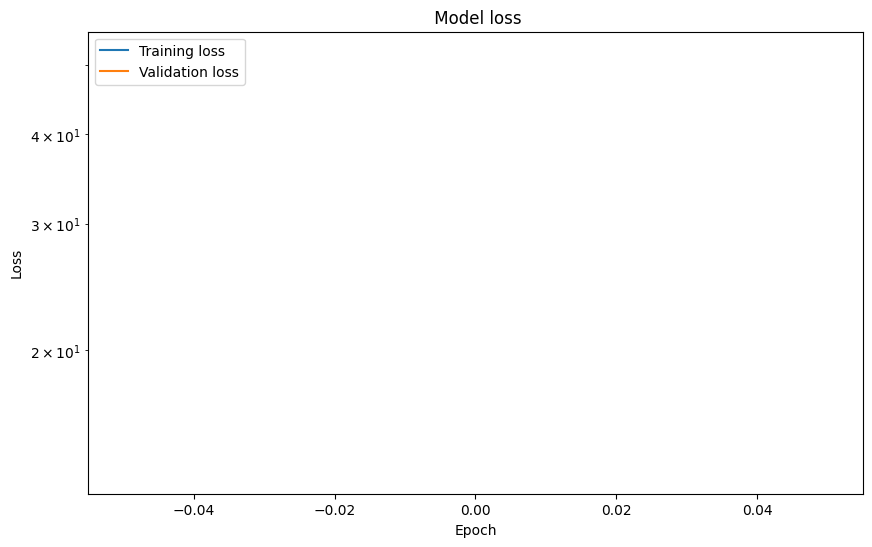

Fitted Weights Hash: f151f01b4554f4b1c902ea1b3fb693a5
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case CSFO3_202401_set_3
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

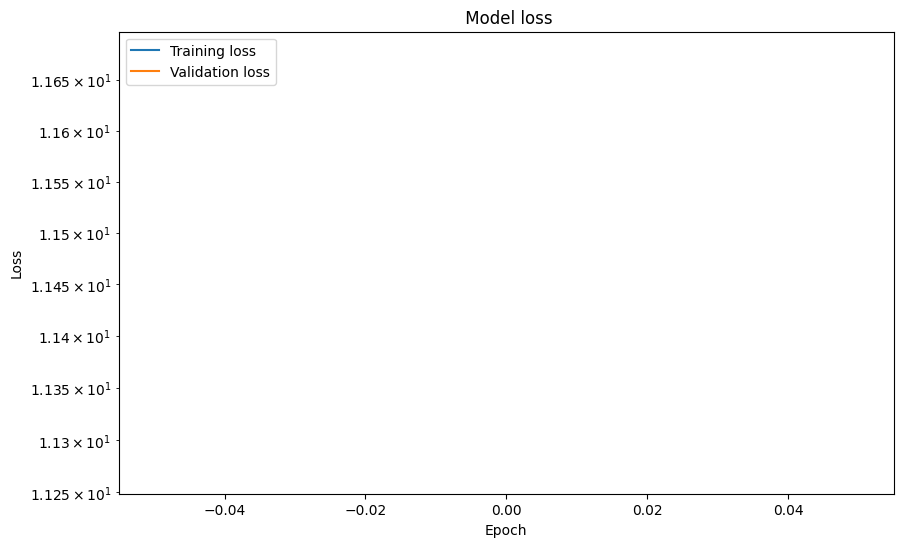

Fitted Weights Hash: c2fab0810718fc5d23b4efdc0302e14d
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case LCFW1_202401_set_5
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

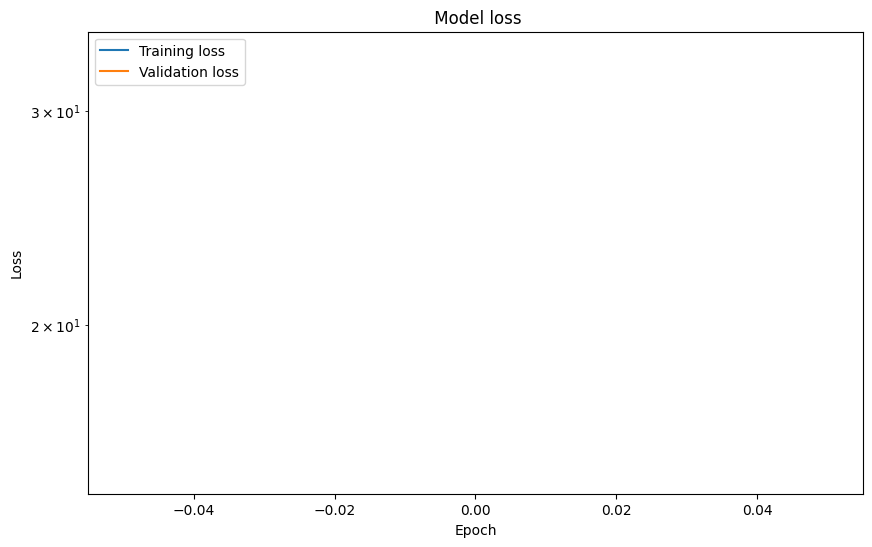

Fitted Weights Hash: 90ada8f1981a4303bb51e3445132ddc8
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case ALFO3_202401_set_5
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

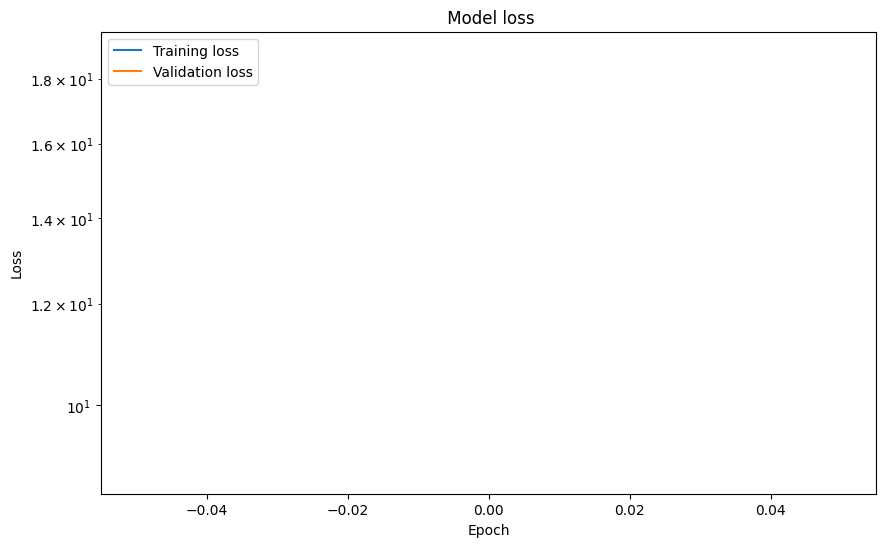

Fitted Weights Hash: c2e1d904154f8a31b1a7095925316cab
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case OMFW1_202401_set_5
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

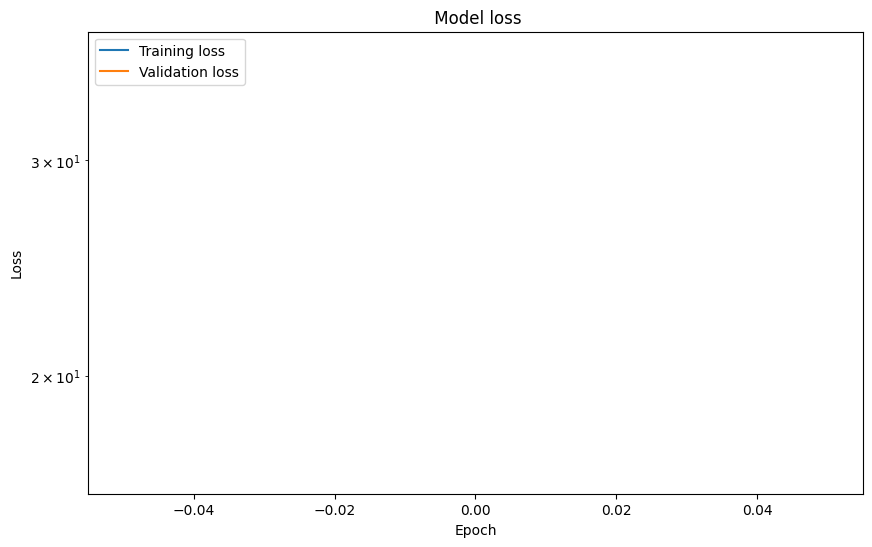

Fitted Weights Hash: 09a03935dbf851c647c49116bab2ab50
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case CGFO3_202401_set_3
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

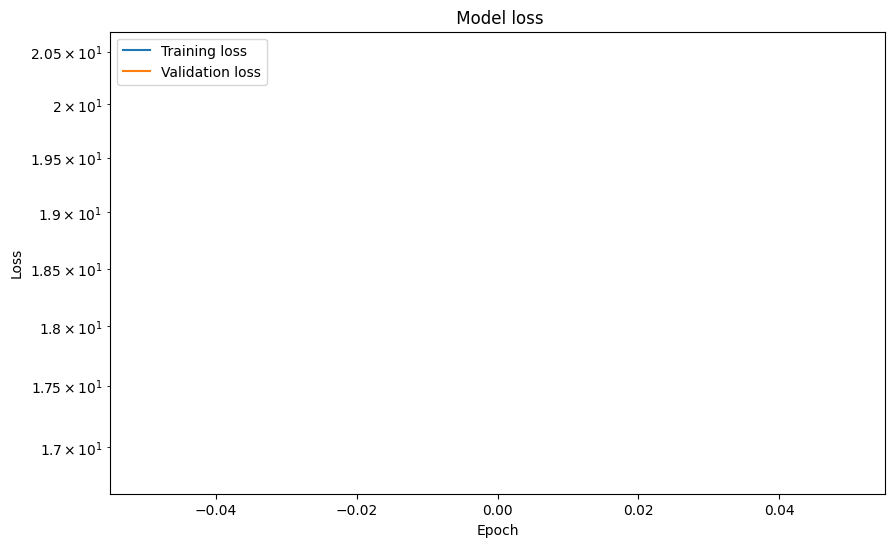

Fitted Weights Hash: c7d21ee72b23ec438b7e35a8ffb5fc1b
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case CWFO3_202401_set_4
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

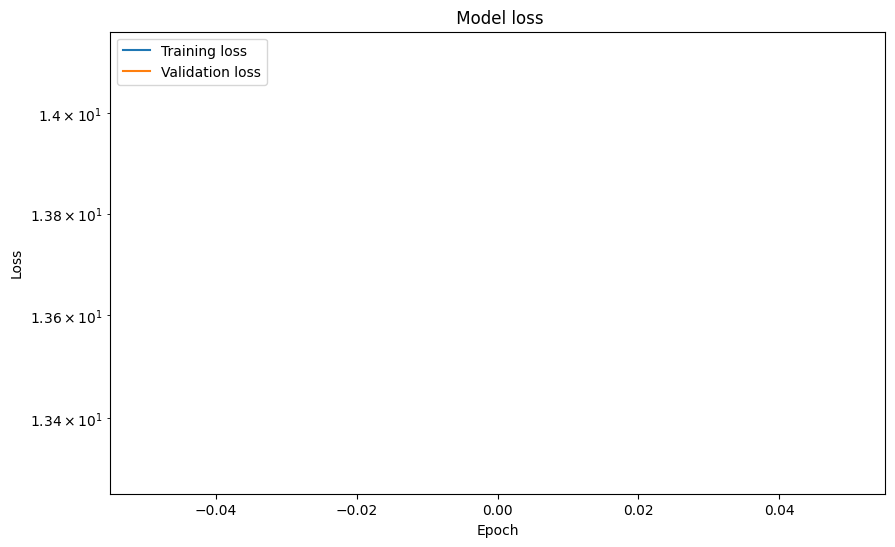

Fitted Weights Hash: 4530f63ab127d3fb19606f5aeccdee2a
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case TOFO3_202401_set_5
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

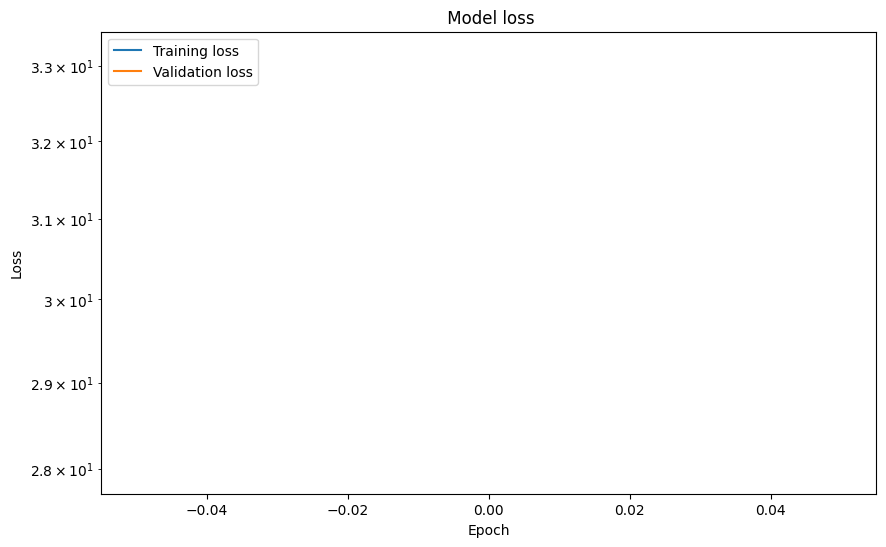

Fitted Weights Hash: d3fca7fc0db472db3ed82d554ff5a402
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case SQFO3_202401_set_4
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

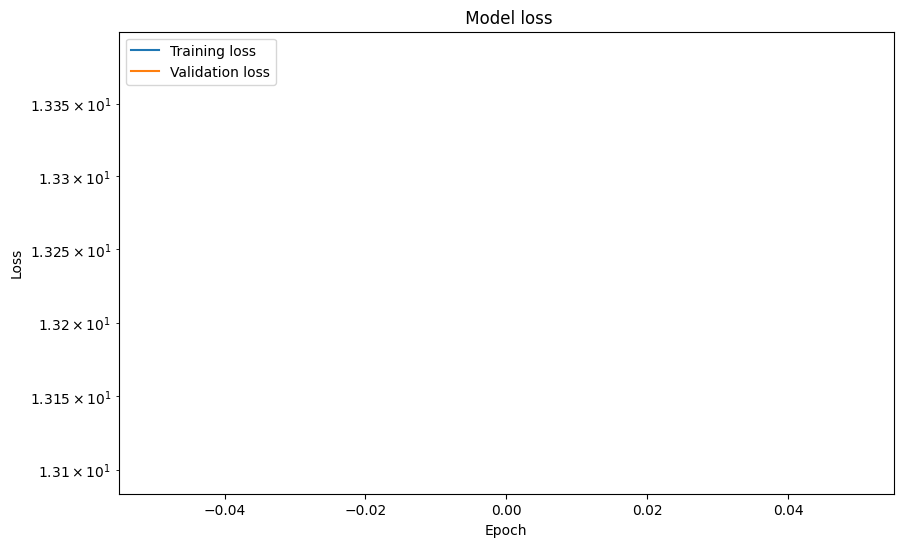

Fitted Weights Hash: dfb24879f6e032d858ad560bd634f395
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case WMFO3_202401_set_4
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

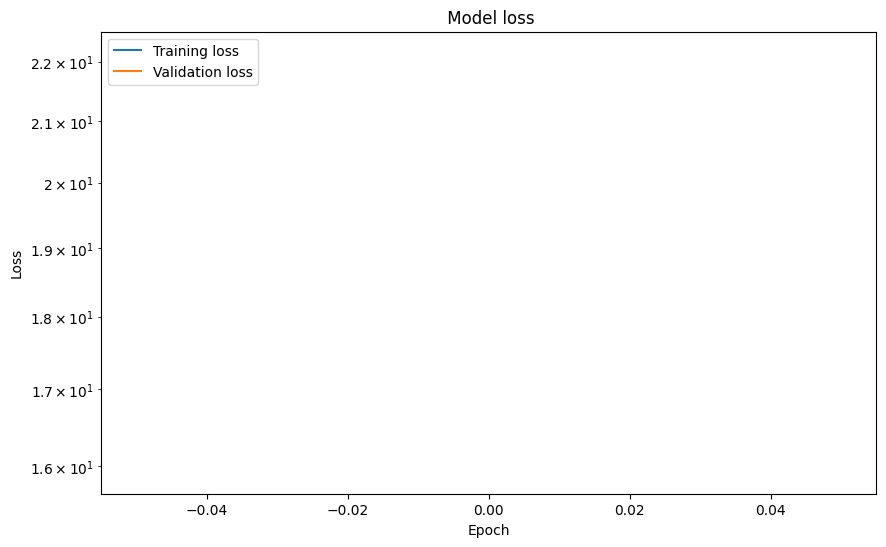

Fitted Weights Hash: 89dd96ed40155f41dcc402010dddc248
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case FWFW1_202401_set_4
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

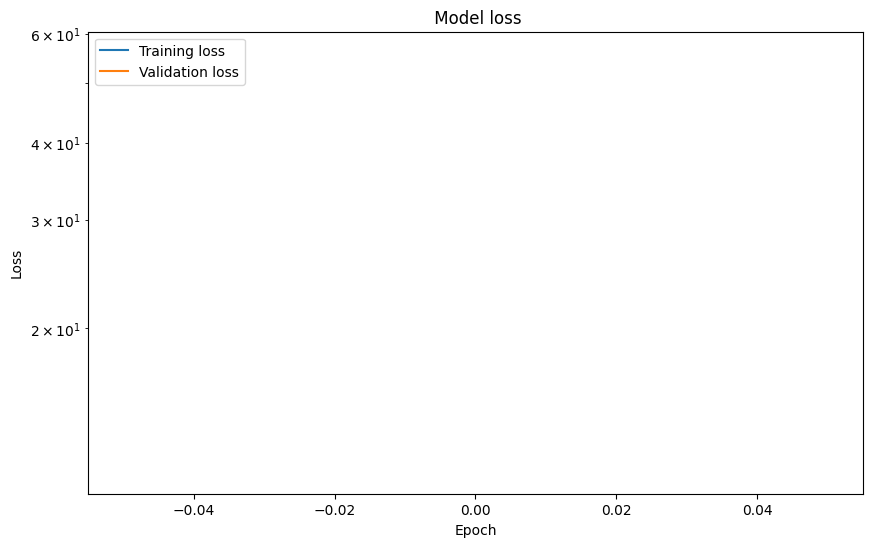

Fitted Weights Hash: 0bf46fd4f7dc22f74cd4627266f62a73
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case CGFO3_202401_set_5
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

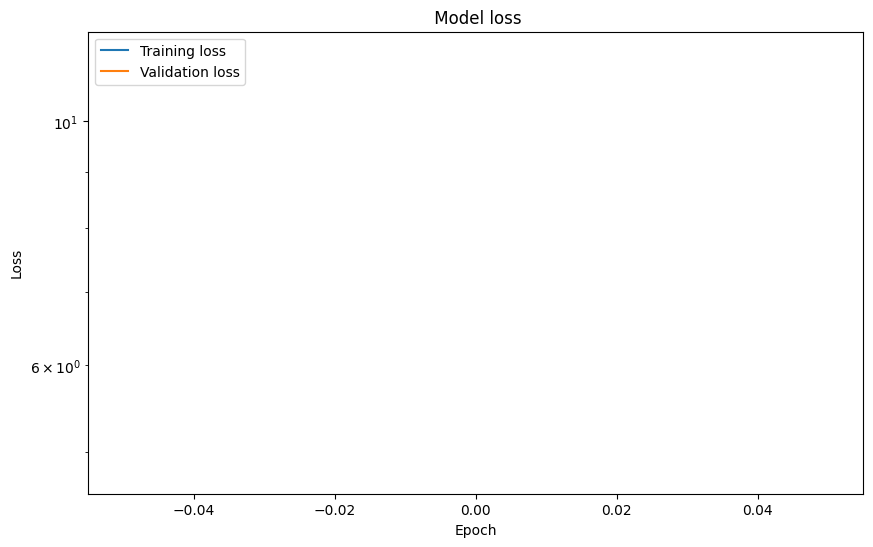

Fitted Weights Hash: c4e9d1314534b73351090c9d573bc334
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case LSFW1_202401_set_3
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

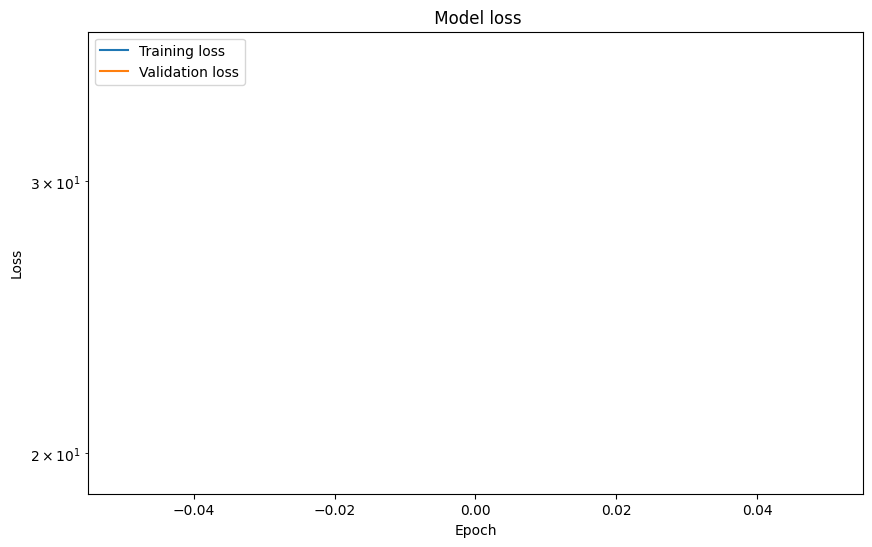

Fitted Weights Hash: 66e23b9bcee2b6b2505f1eb44486be1f
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case HYFO3_202401_set_2
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

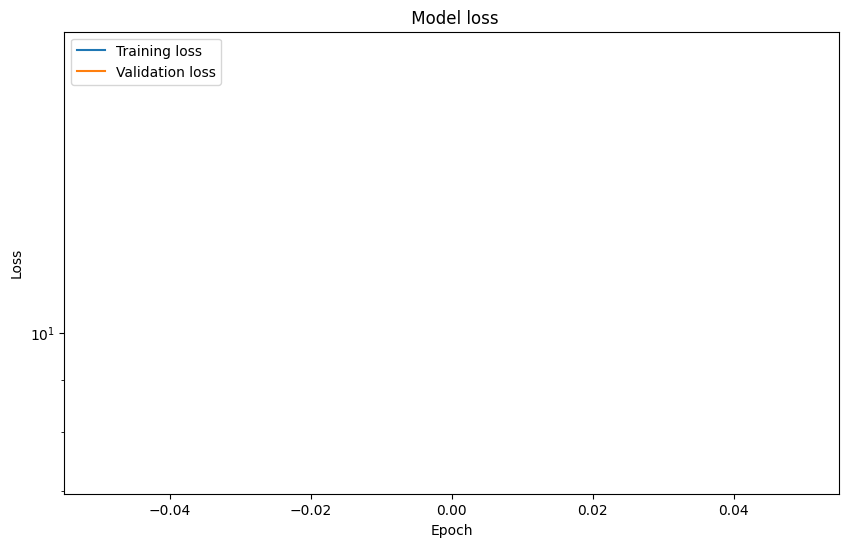

Fitted Weights Hash: fed03d86ec7a67682b93b19fa2ec5d7d
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case SRFI1_202401_set_3
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

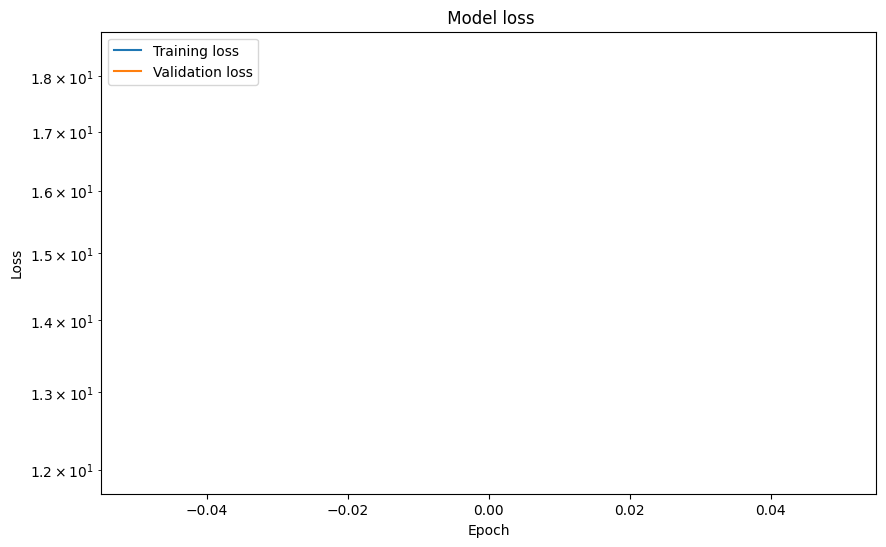

Fitted Weights Hash: 18be7038ae98637aad1e55a4779c4705
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case SLFO3_202401_set_4
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

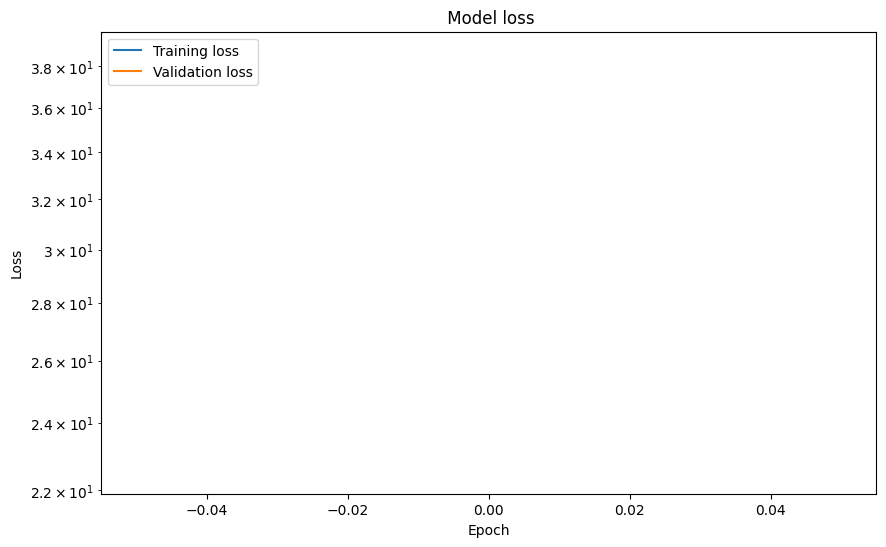

Fitted Weights Hash: 63172644e952710fbc003dcceee50bcc
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case MSFO3_202401_set_5
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

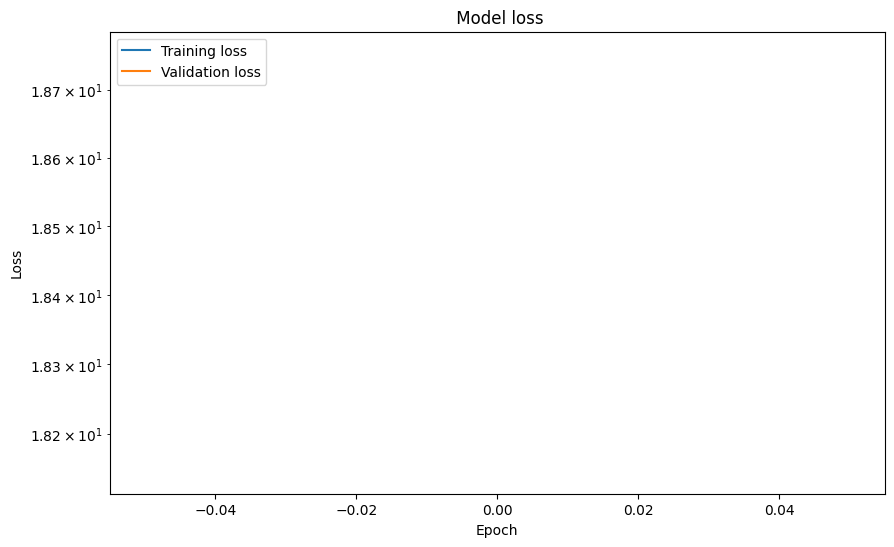

Fitted Weights Hash: 4c2cd5b991d429788bb415719fa39bff
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case CPFO3_202401_set_4
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

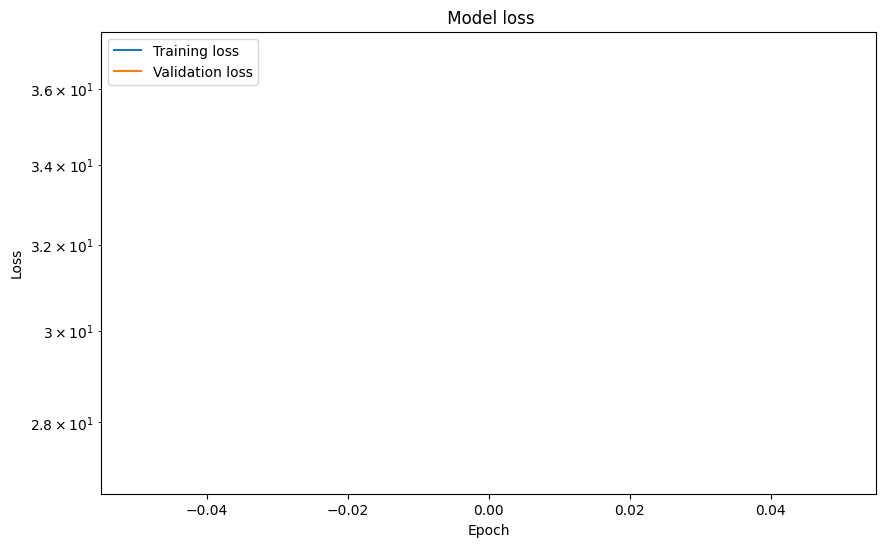

Fitted Weights Hash: aad234de24b248215613ce5ffa8573ee
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case TCFW1_202401_set_5
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

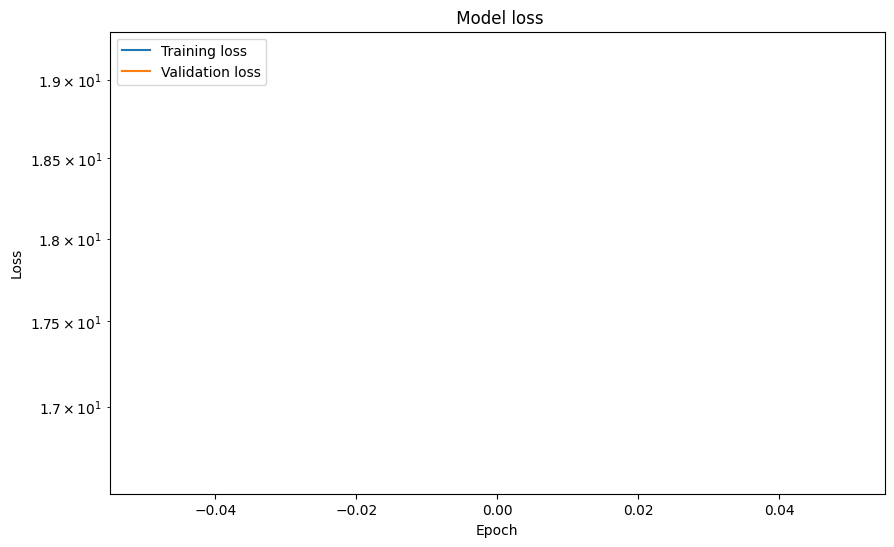

Fitted Weights Hash: 95de61200925df6d32e10ce26a04d340
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case CEFO3_202401_set_4
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

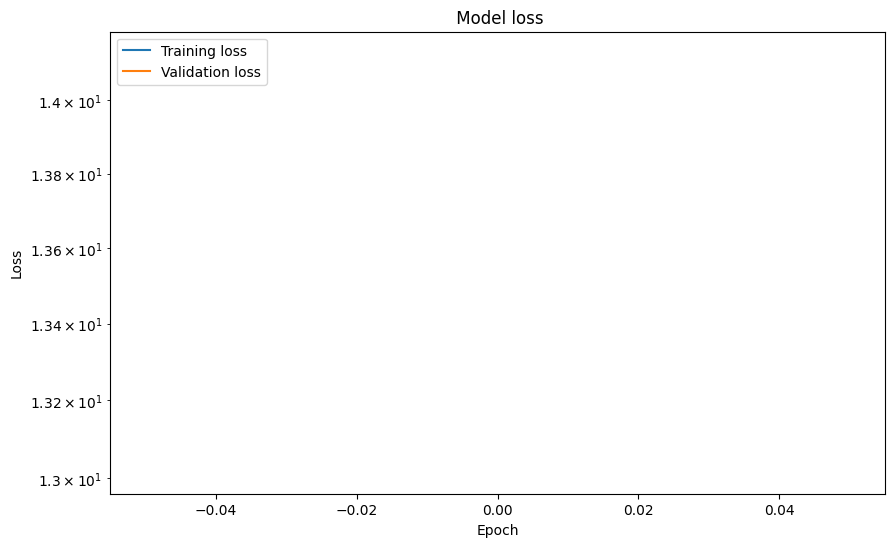

Fitted Weights Hash: 6f29519e3efbd625b7489a7407fdfe1e
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case OKFO3_202401_set_5
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

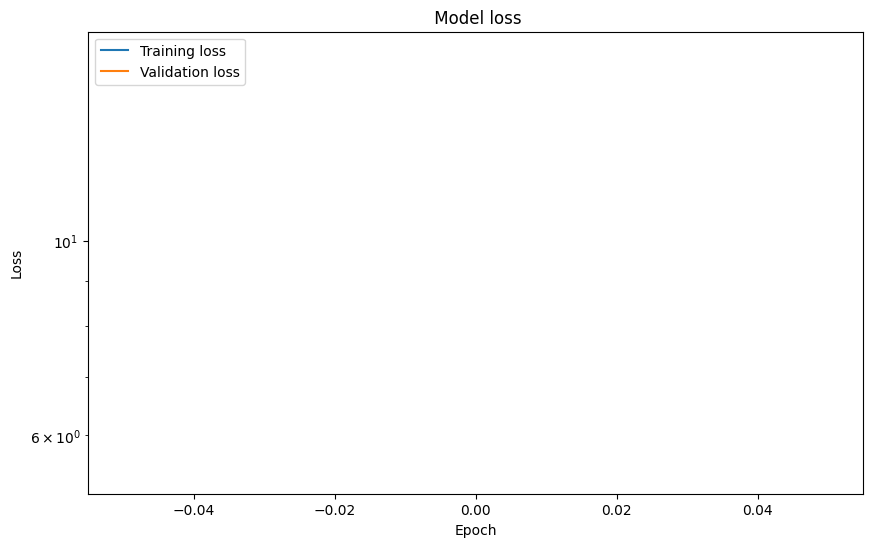

Fitted Weights Hash: 1d0be034573d282d6738d38cb55a8084
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case TPEO3_202401_set_2
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

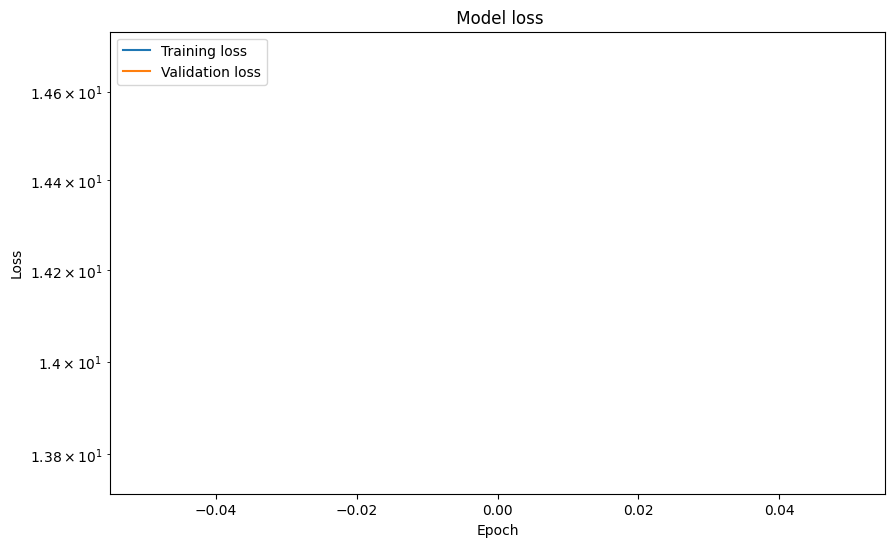

Fitted Weights Hash: 7e9706d10e4e19985cfa5e529a40e1ab
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case LLFW1_202401_set_4
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

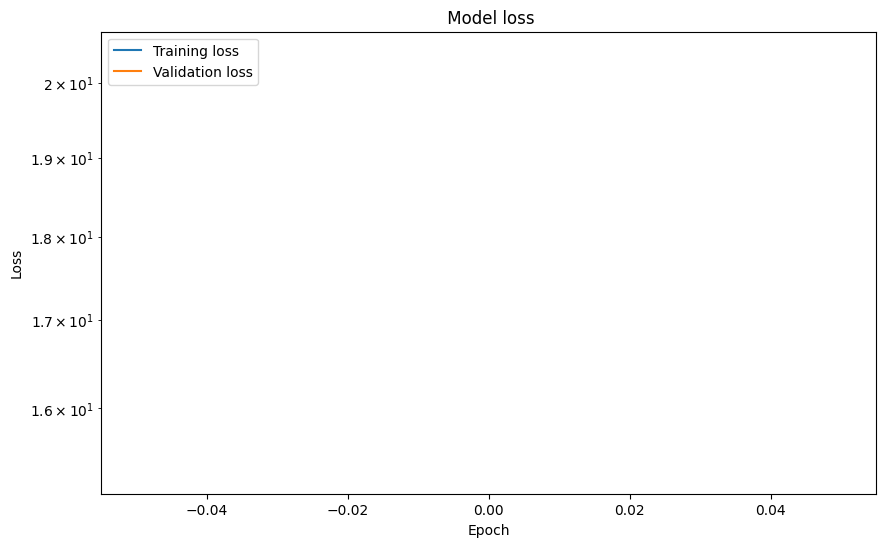

Fitted Weights Hash: 043a5c25e132db1aee41c7d8294168e7
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case NCSW1_202401_set_3
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

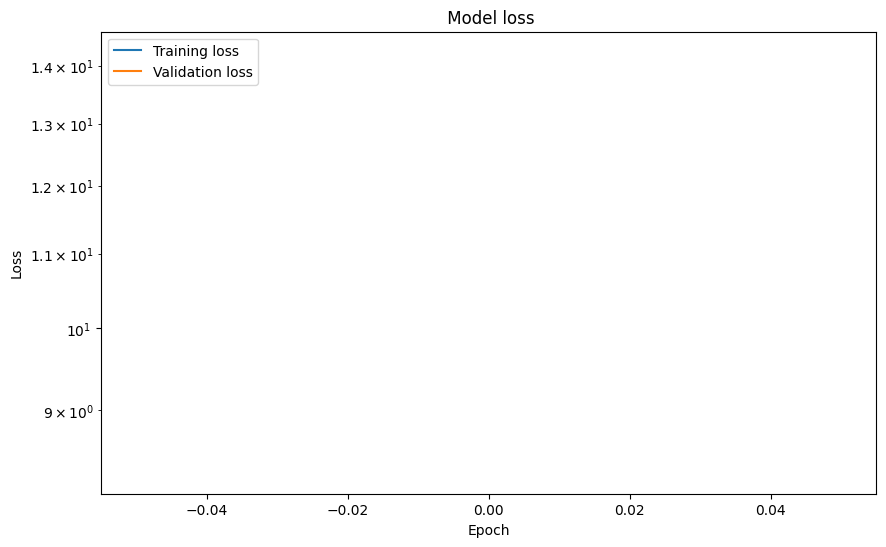

Fitted Weights Hash: 1b5d102a66fbd6157e716475d52f9332
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case DMFW1_202401_set_3
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

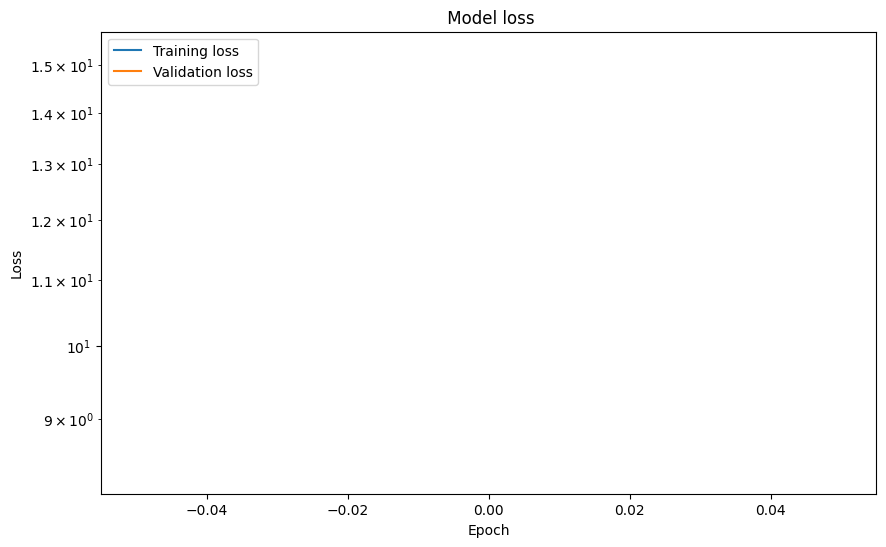

Fitted Weights Hash: bdbd273585bb2d6dd83984bc4f16a821
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case FTFW1_202401_set_4
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

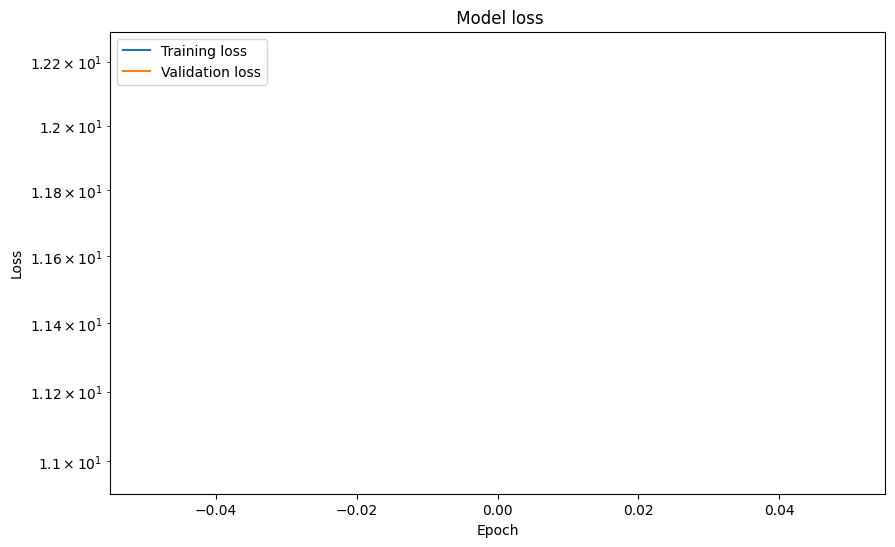

Fitted Weights Hash: 338ec99cba751321a1e268b936a30c28
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case SLFO3_202401_set_5
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

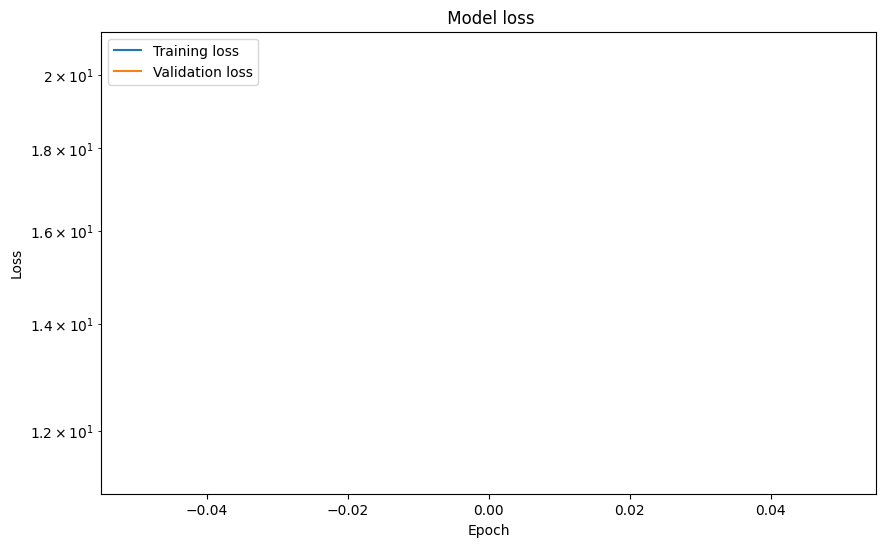

Fitted Weights Hash: 5a347c2674a36443c4ce0c59fbdd341a
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case LLFW1_202401
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type': 'exp'

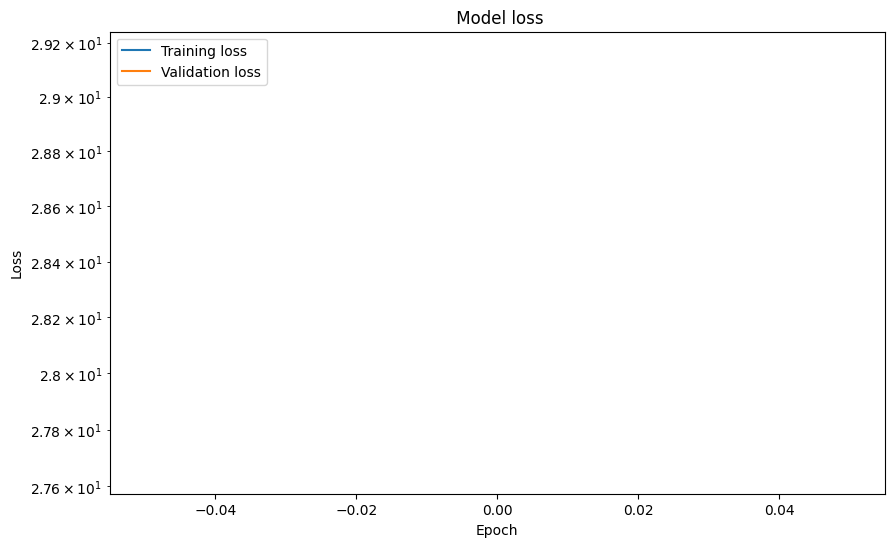

Fitted Weights Hash: 4df6b70c58945ff9b8a20a8c7d66b4af
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case EMFO3_202401_set_4
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

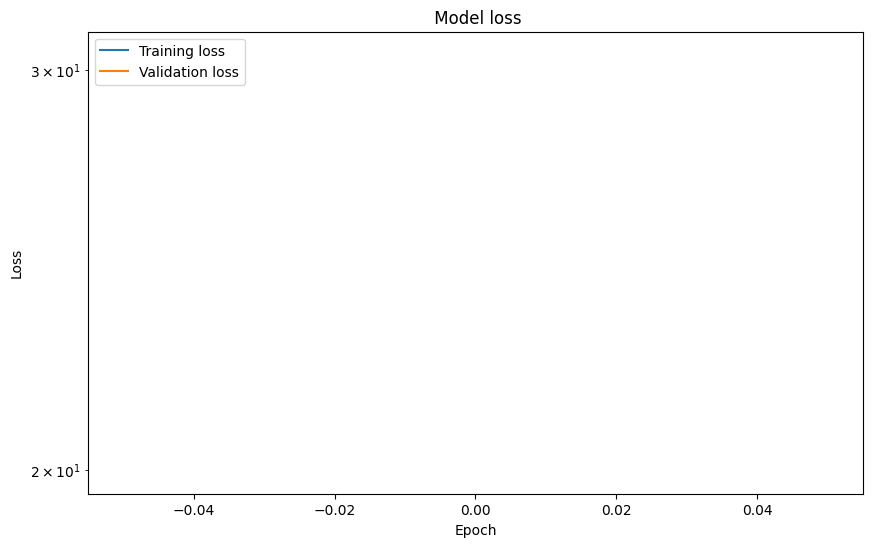

Fitted Weights Hash: 587aecba98ad7a63f51b362ed01e38ad
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case BGFO3_202401_set_3
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

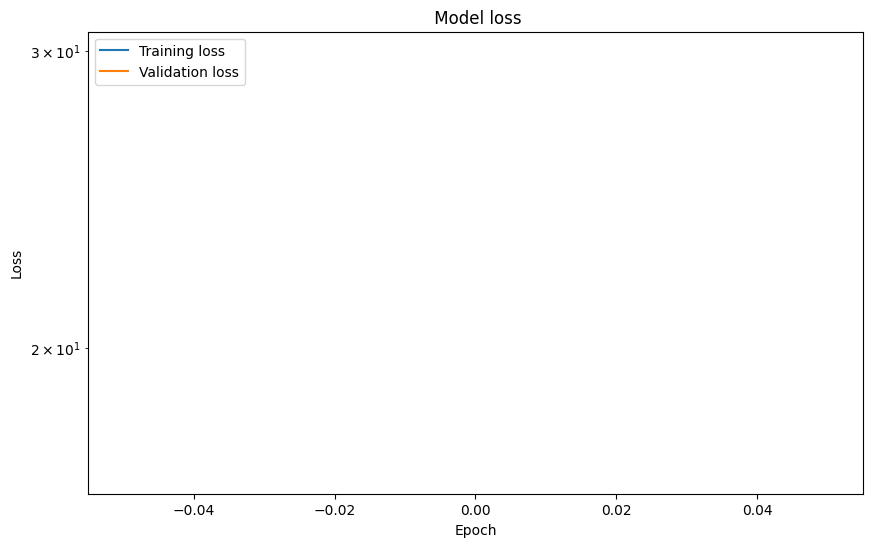

Fitted Weights Hash: 9aae5f030e28f05a1ce3dd549ef0e4de
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case PLFI1_202401_set_3
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

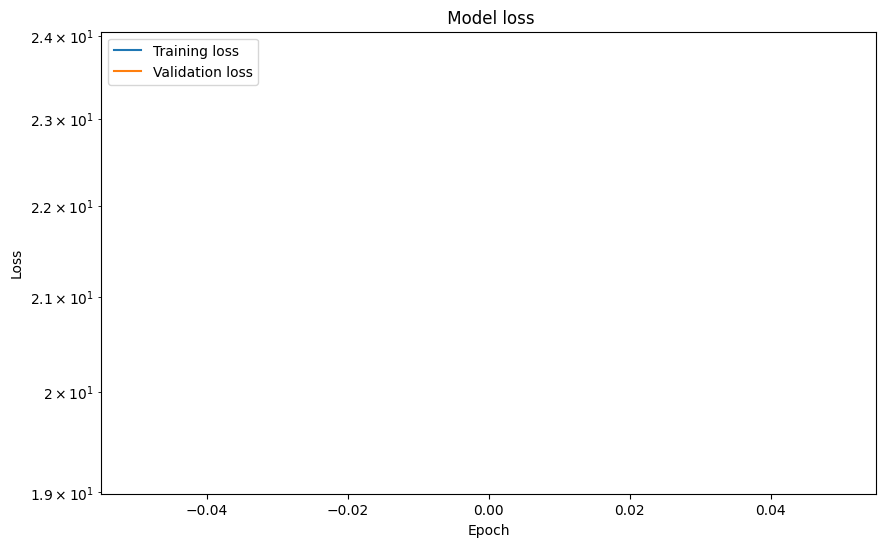

Fitted Weights Hash: c0536e4cac7ef1755b581bd24d5b818e
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case CGFW1_202401_set_3
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

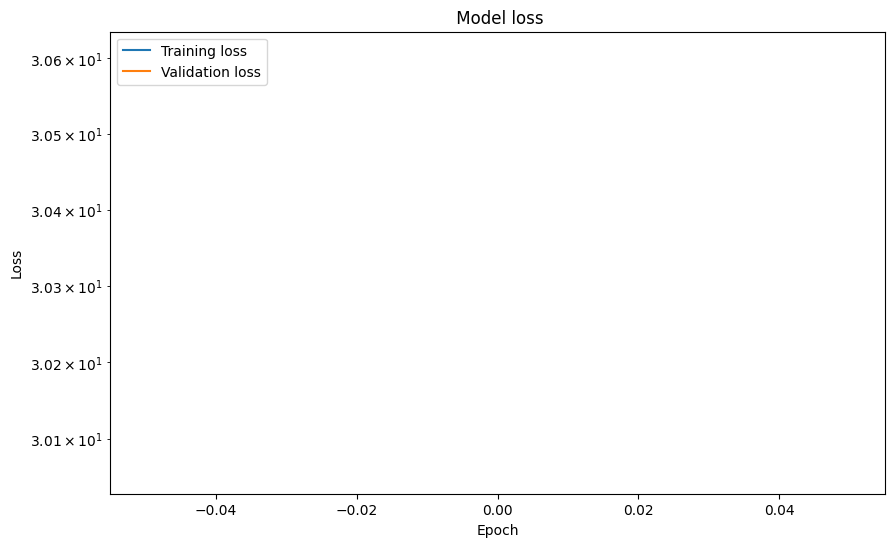

Fitted Weights Hash: a4c769c71b0e277a4ec019209eac6f28
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case BTFO3_202401_set_5
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

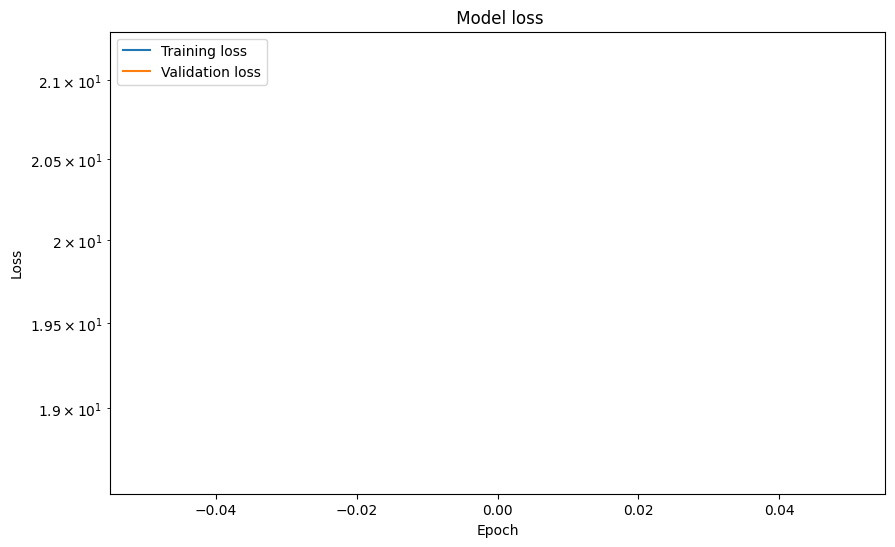

Fitted Weights Hash: 29bf8a9e681a63cb87de19409450b893
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case ENFO3_202401_set_5
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

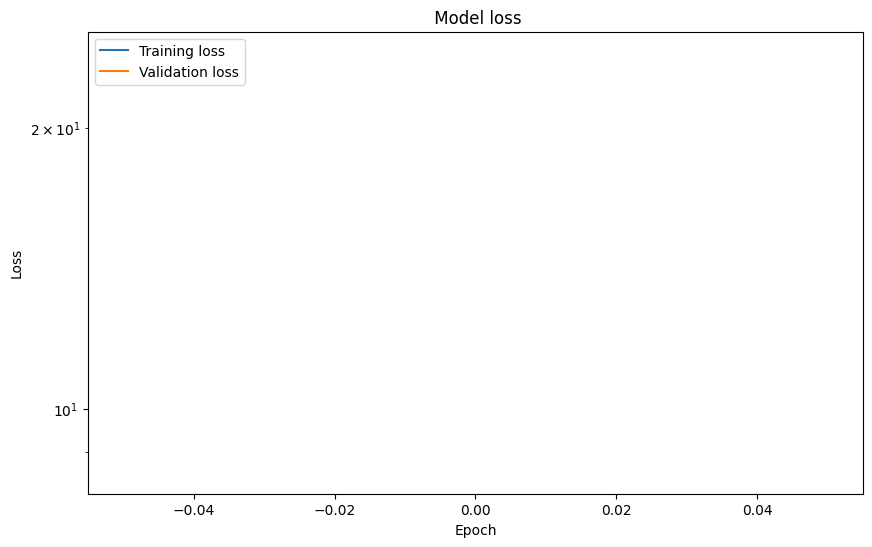

Fitted Weights Hash: 0fcf758dd18ff2ebe8717813996b3fa8
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case CEFO3_202401_set_2
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

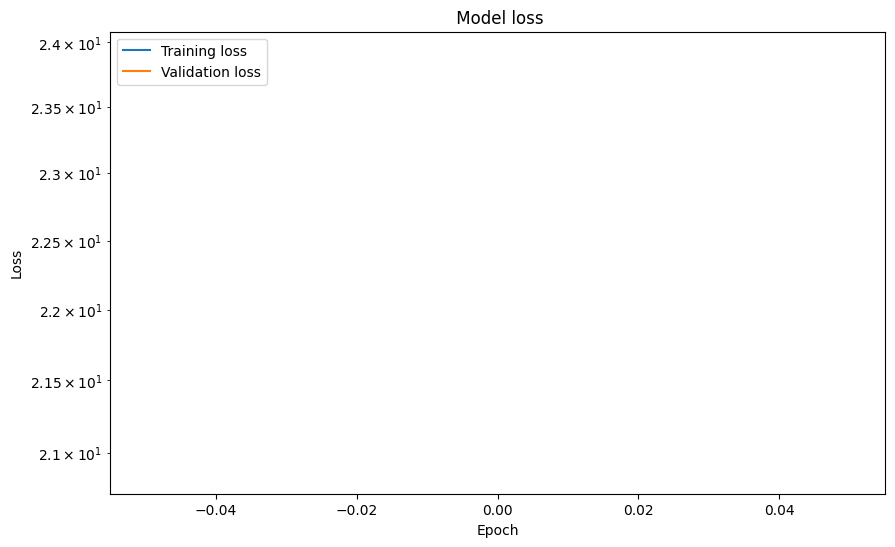

Fitted Weights Hash: 4188938c121c5b5c9b1b0885ae05f623
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case TUFO3_202401_set_5
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

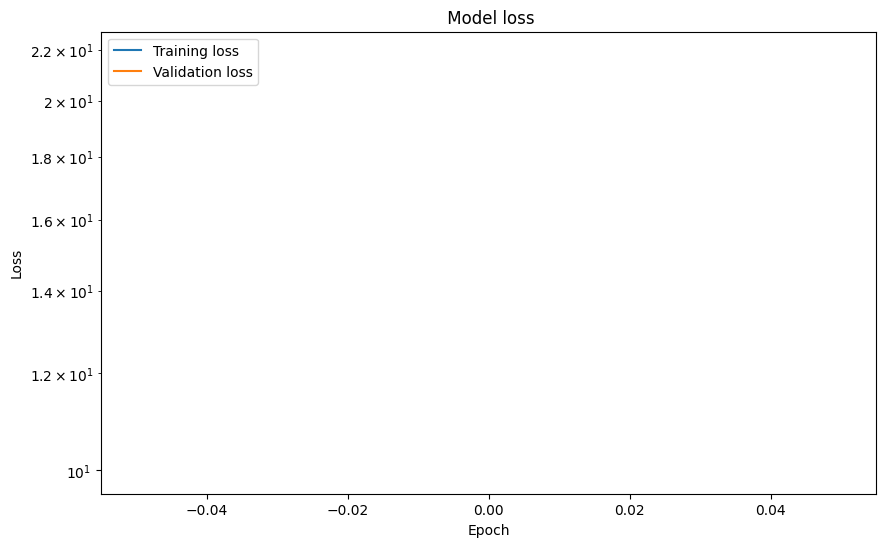

Fitted Weights Hash: 2d1f858d929c1d2edd9adda3cfe8fc6c
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case ALFO3_202401_set_4
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

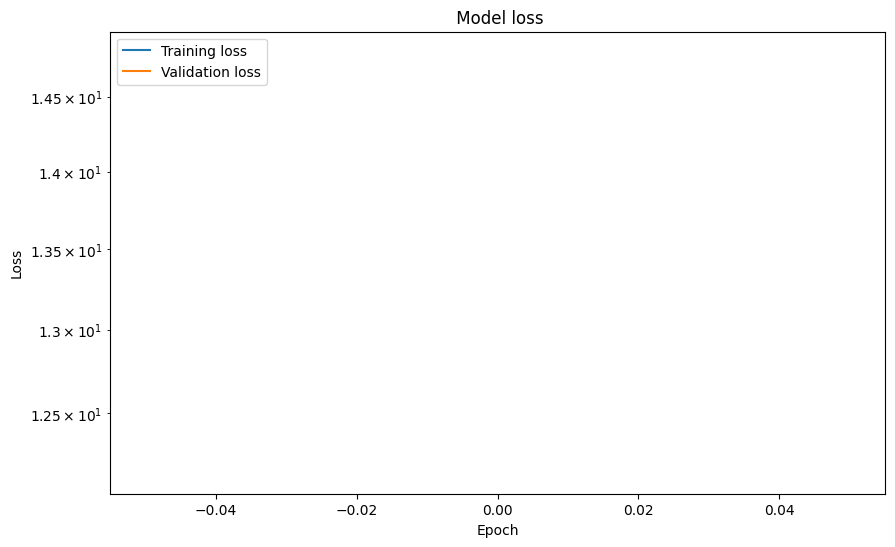

Fitted Weights Hash: c45d482d18f555a0d36e8b376cd6112a
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case RNFO3_202401_set_3
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

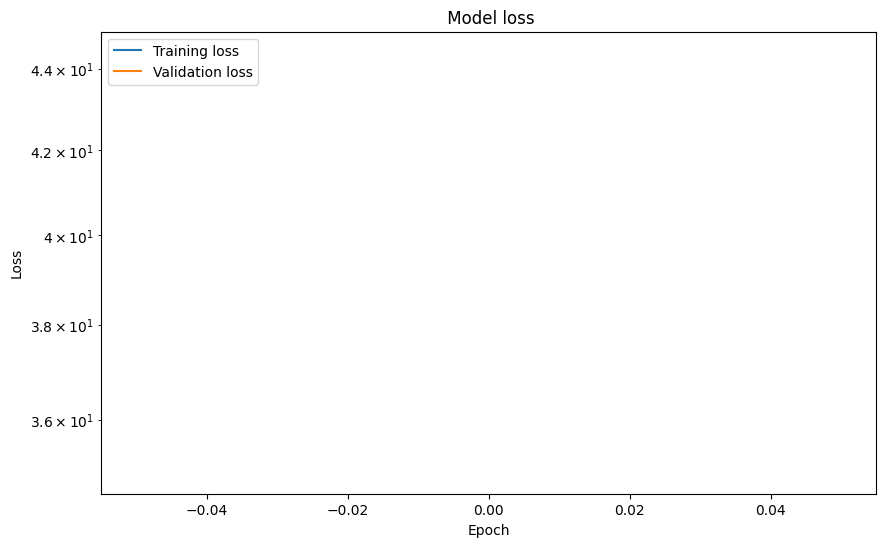

Fitted Weights Hash: 6c5c1a0b36e2e9557fc2848e29efa954
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case QCNW1_202401_set_2
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

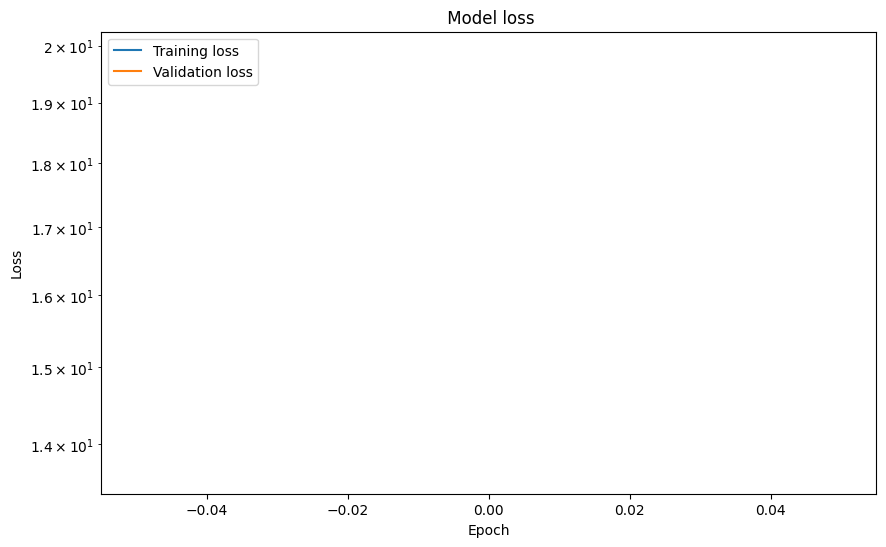

Fitted Weights Hash: 458b1545f2d5d8ef68555b33e4e92147
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case PEOW1_202401_set_5
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

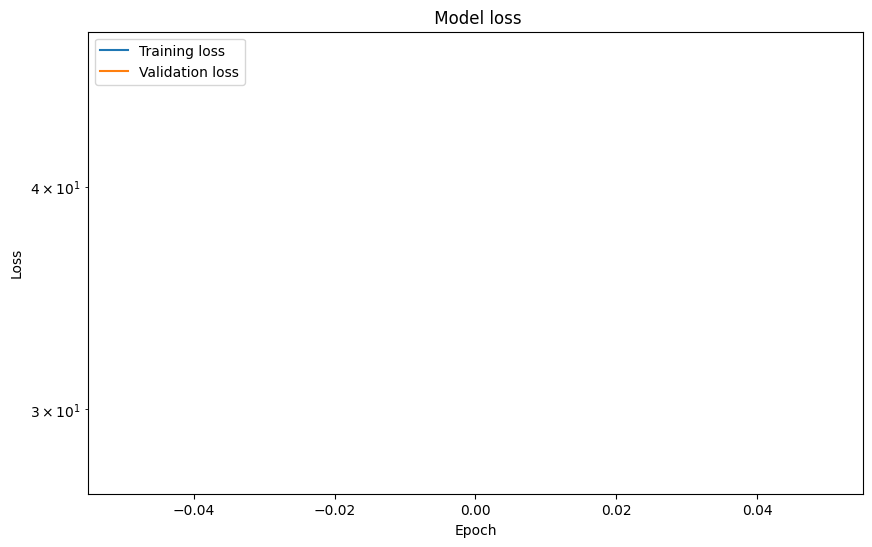

Fitted Weights Hash: 63d7384729f8318901e0f94481142886
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case CAFO3_202401_set_5
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

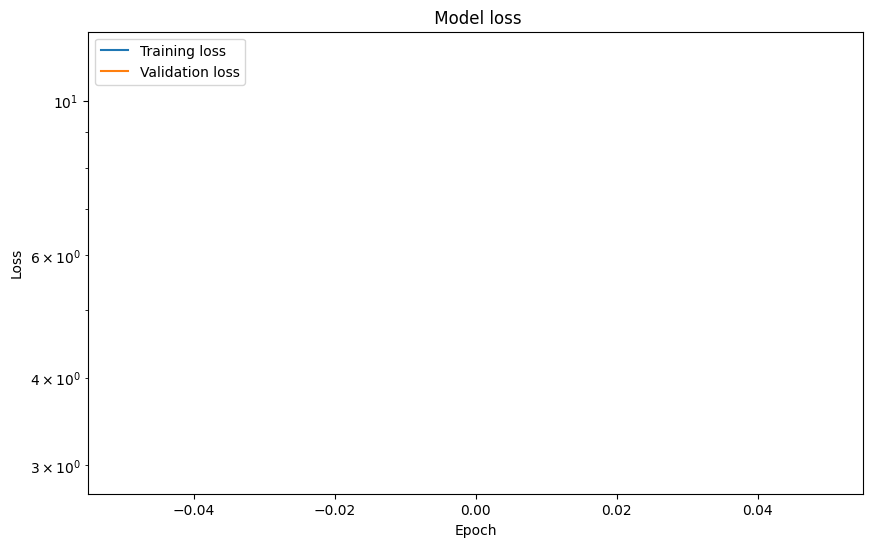

Fitted Weights Hash: a36172e2956e0fd56edb35ffed5417cc
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case KCFW1_202401_set_4
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

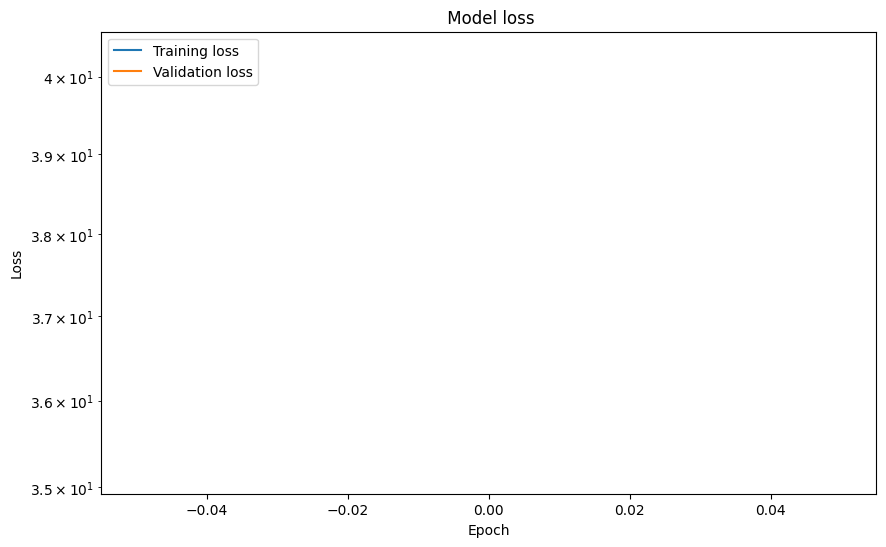

Fitted Weights Hash: 1516675e7570a63c159e3d69f685ca76
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case DRYW1_202401_set_4
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

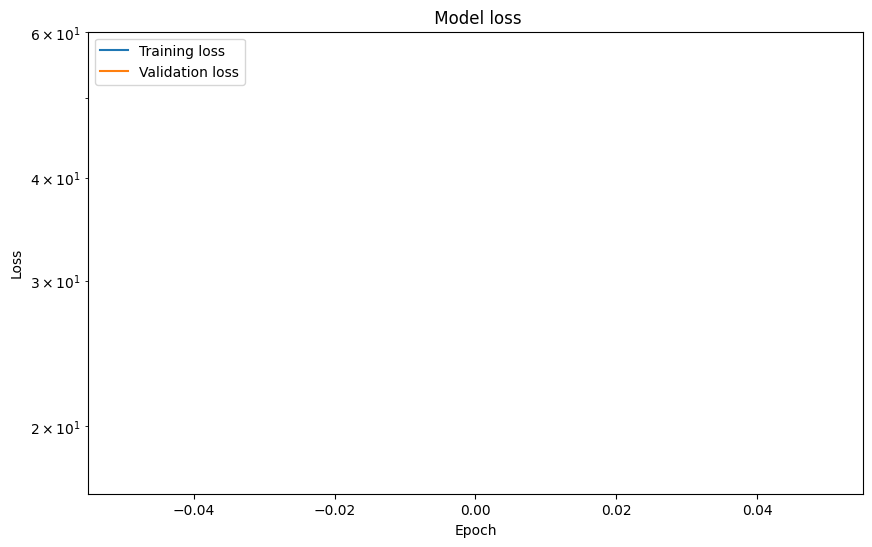

Fitted Weights Hash: 0a030ee29c9d56d4d68fe40c9ce93bd2
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case ATFO3_202401_set_5
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

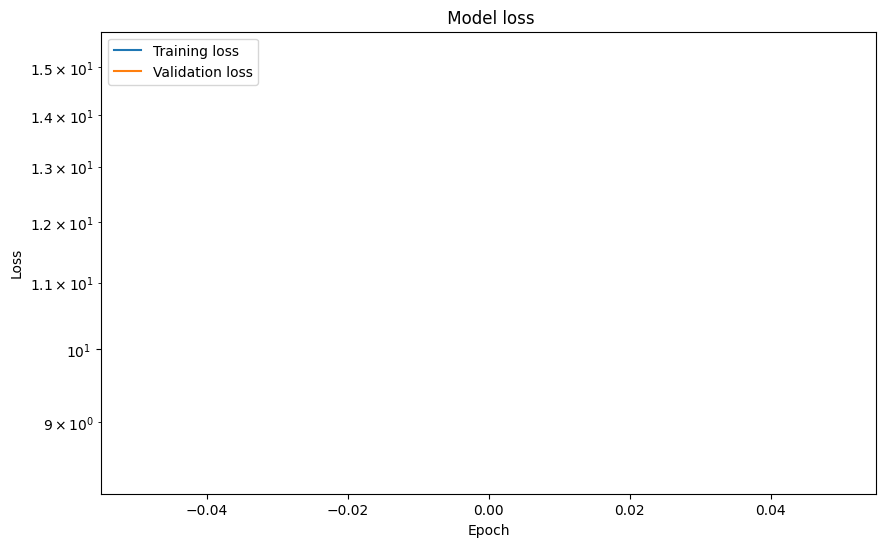

Fitted Weights Hash: 47a097f8f49924b3374f83e9063ea342
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case TPEO3_202401_set_3
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

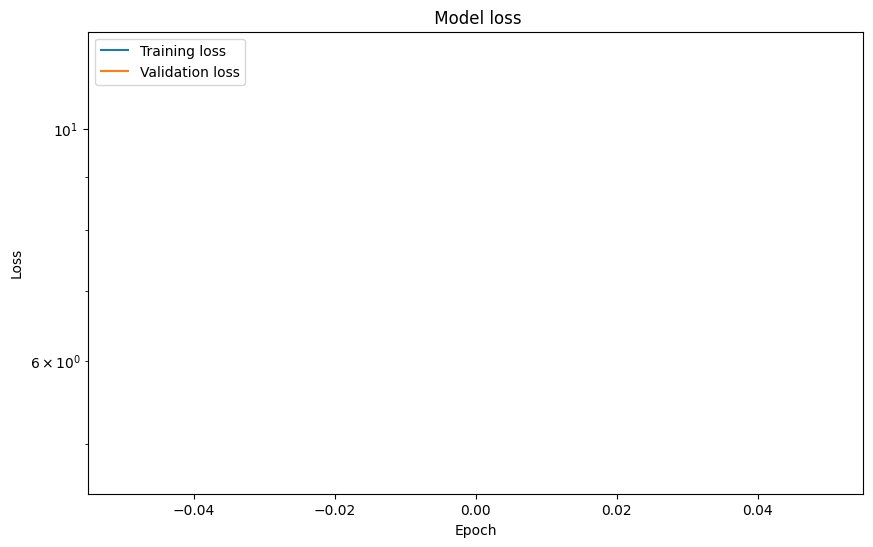

Fitted Weights Hash: e58c9d69de7b9301813c85c9c8664ac8
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case SRFI1_202401_set_4
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

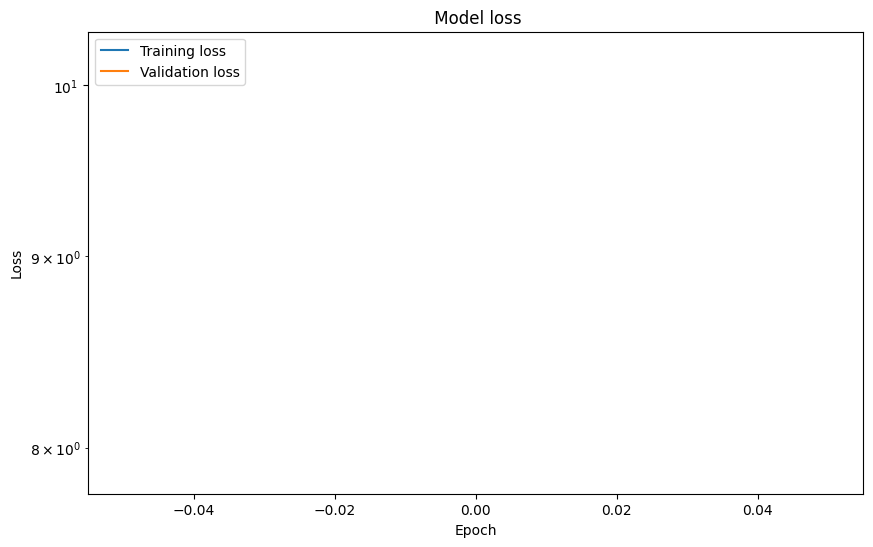

Fitted Weights Hash: 0344387da65b68c2aa877ae7f8aae397
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case CMFW1_202401_set_5
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

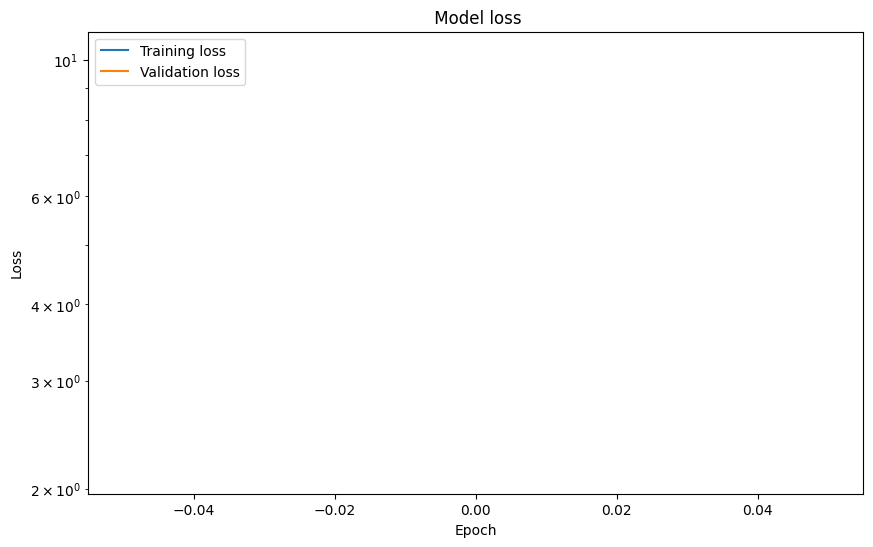

Fitted Weights Hash: 351296eb1f9717d07c9ed19bfce42ca2
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case PYFO3_202401_set_4
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

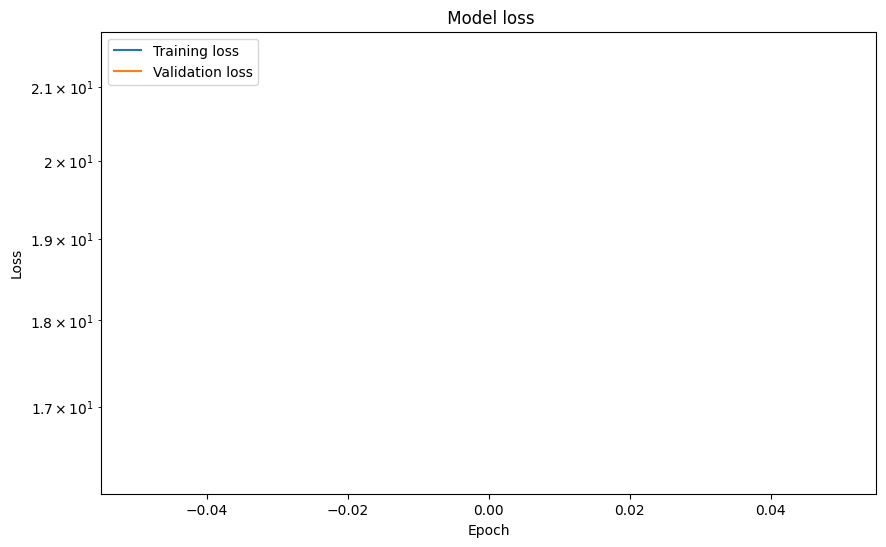

Fitted Weights Hash: a4970b3ab5fdcb647bec74e24f77575b
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case SQFO3_202401_set_2
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

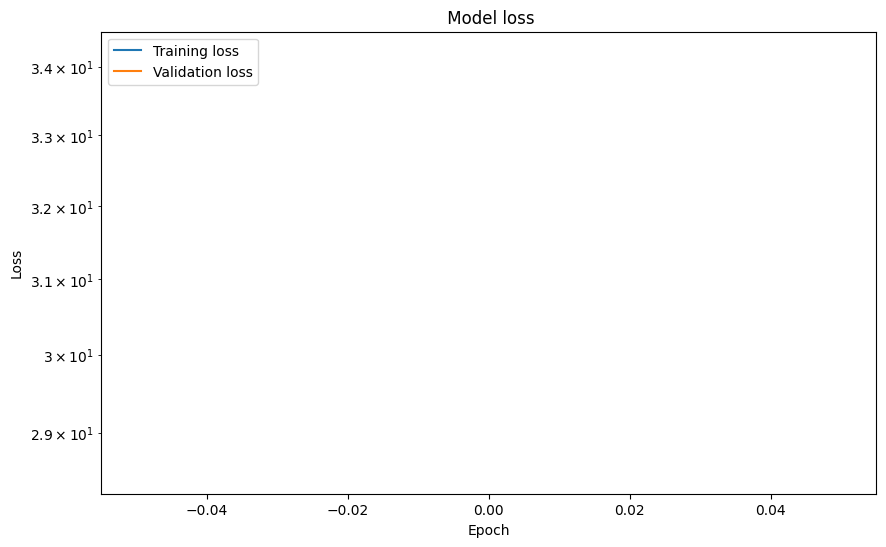

Fitted Weights Hash: 486b5de7a4523453c5ca9ba60a2085a4
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case SKKW1_202401_set_4
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

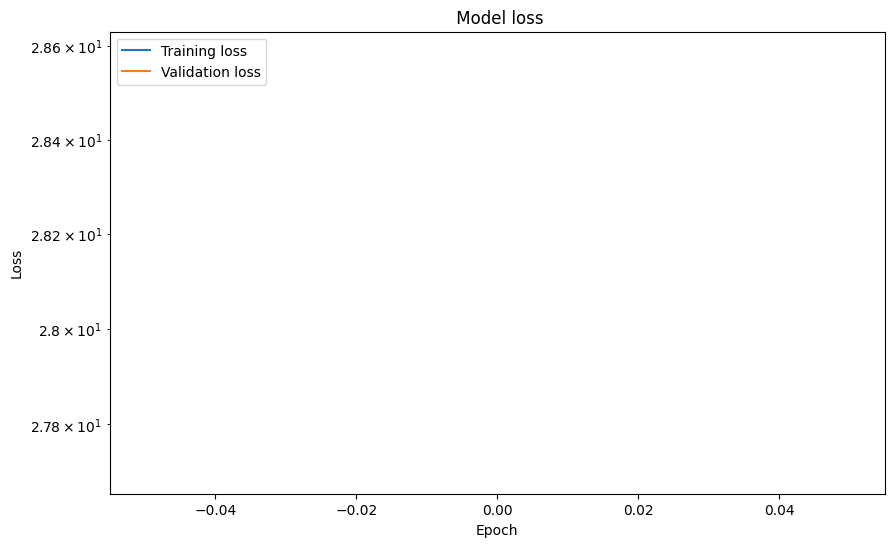

Fitted Weights Hash: 75d9600a4ce4c54a1c790d035cd4e28c
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case BBFO3_202401_set_5
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

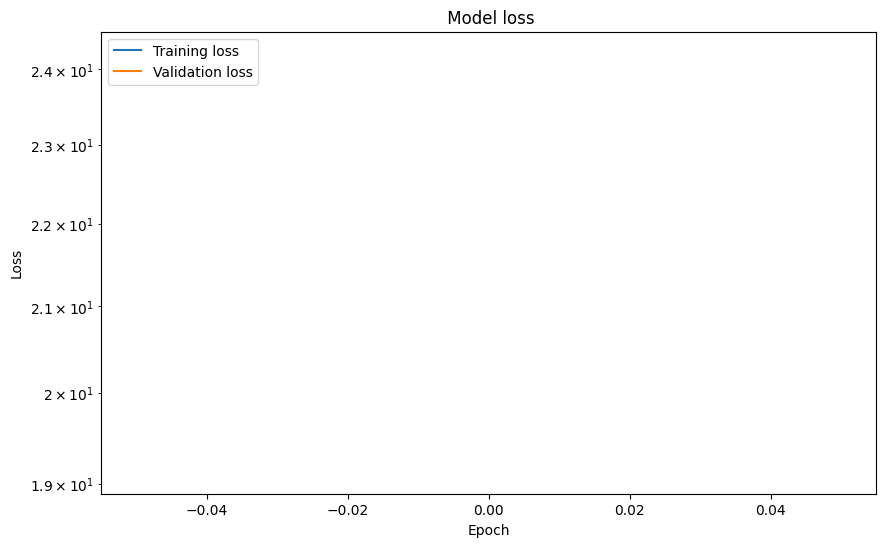

Fitted Weights Hash: 1f042a03b93f86986954add1d2d7c671
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case FWFW1_202401_set_3
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

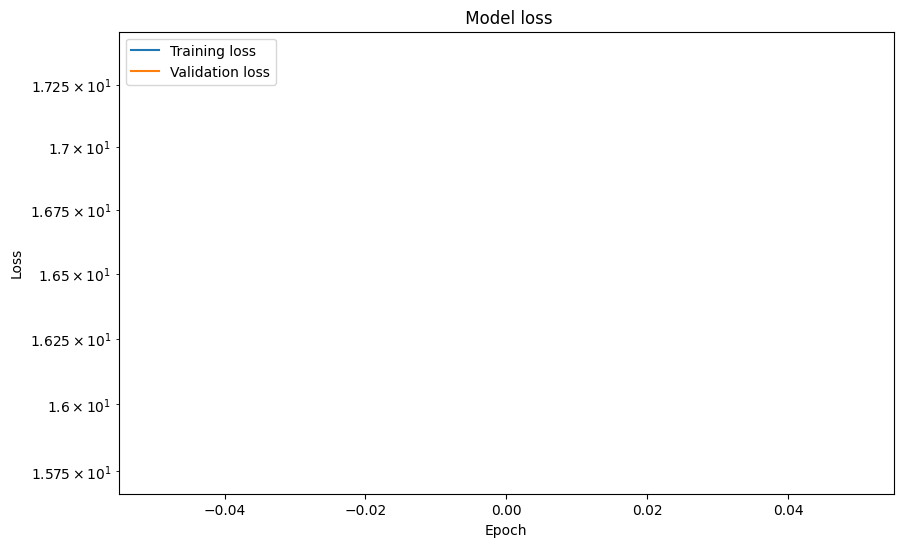

Fitted Weights Hash: 820a85ca8c314fbae63fac280a224b1d
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case PMFW1_202401_set_3
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

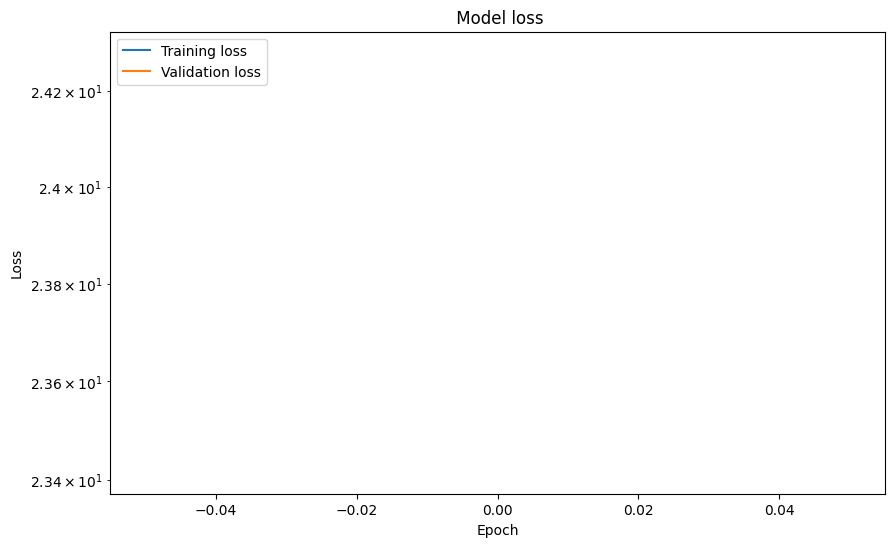

Fitted Weights Hash: addac6926b68ecad607404fac0b7c7ff
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case CGFW1_202401_set_2
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

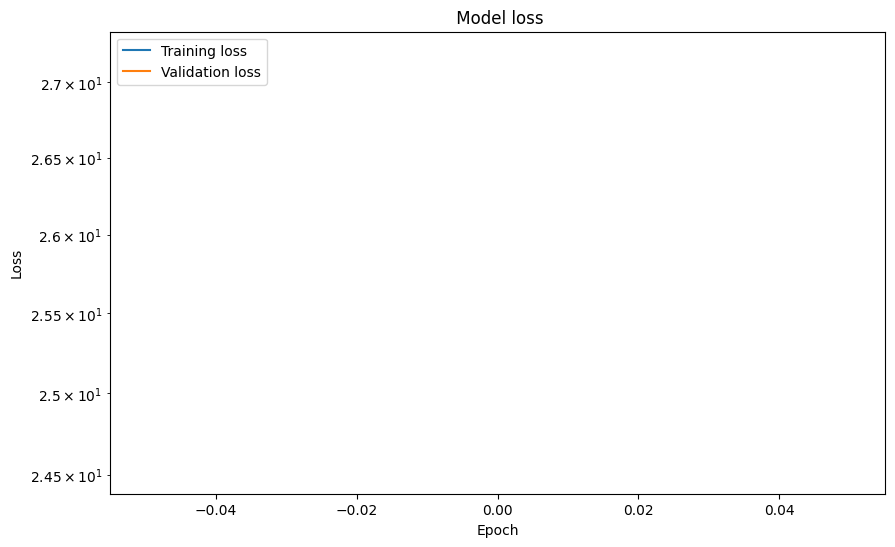

Fitted Weights Hash: 64183effa7a8b192c4ad85b6f3d44db8
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case RNFO3_202401_set_4
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

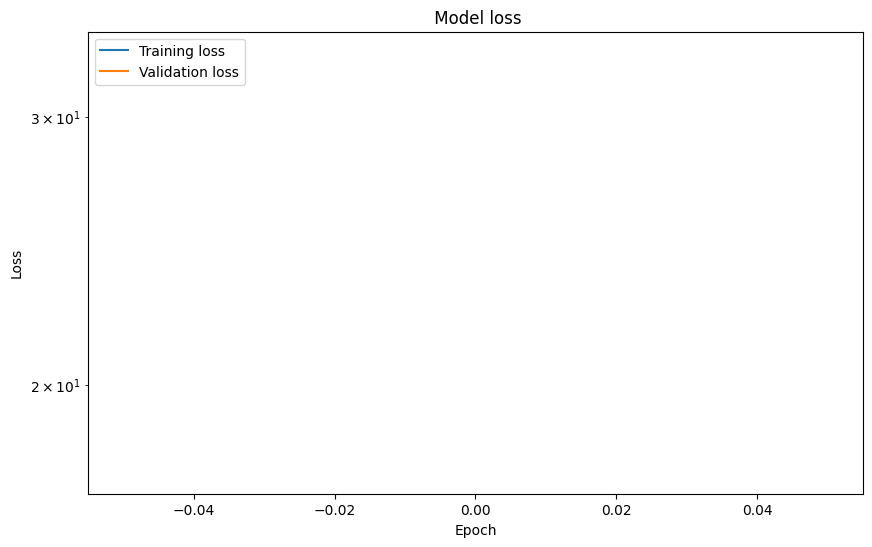

Fitted Weights Hash: 9ce5b57af9b920233ccfc5d389ae7350
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case PLFI1_202401_set_4
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

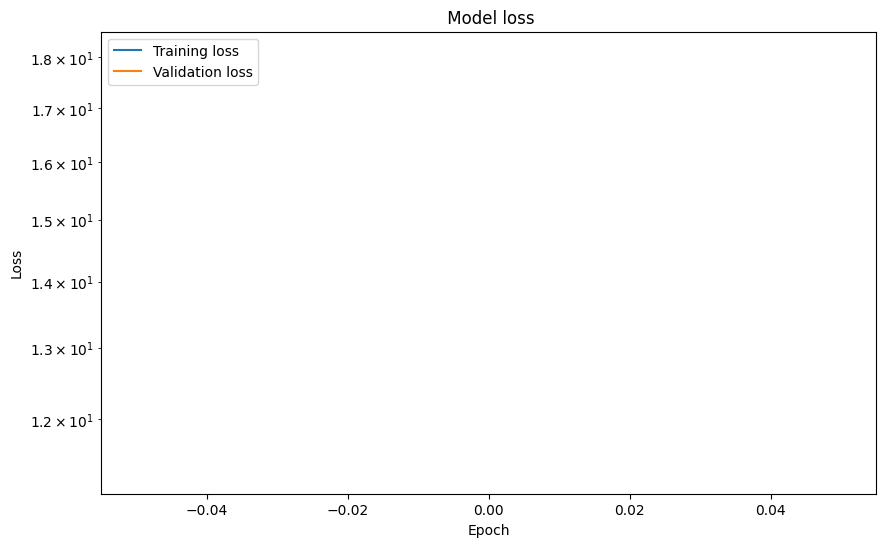

Fitted Weights Hash: 561cfb986b7c81516fd1b0cb19e5242e
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case LLFW1_202401_set_5
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

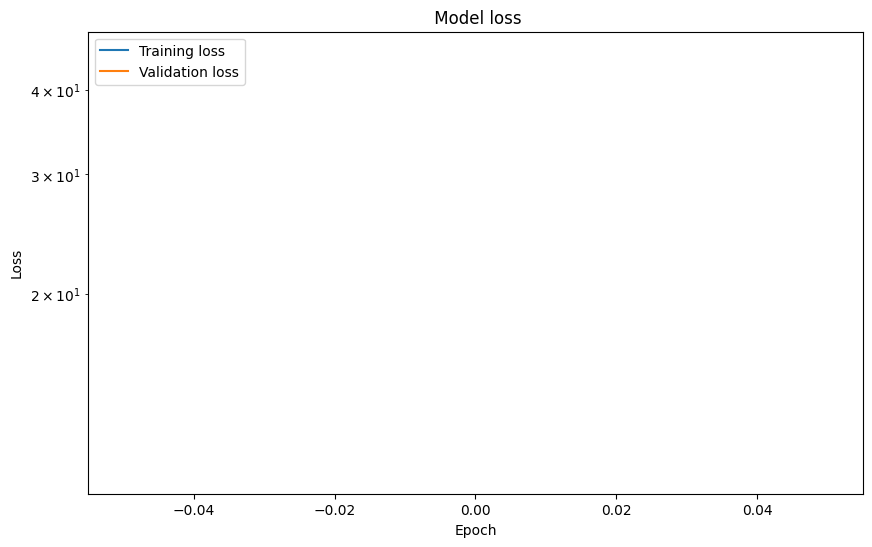

Fitted Weights Hash: f051c6b6326eda2951c89d86e5b1d4aa
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case FBFW1_202401_set_3
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

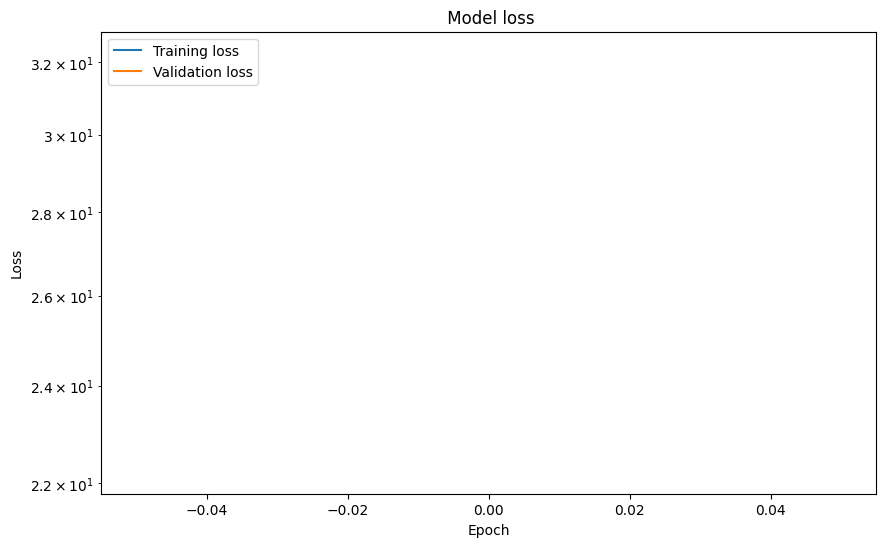

Fitted Weights Hash: 26a1bbbfd0a8422e70c2cb488ff71da4
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case CGFW1_202401_set_5
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

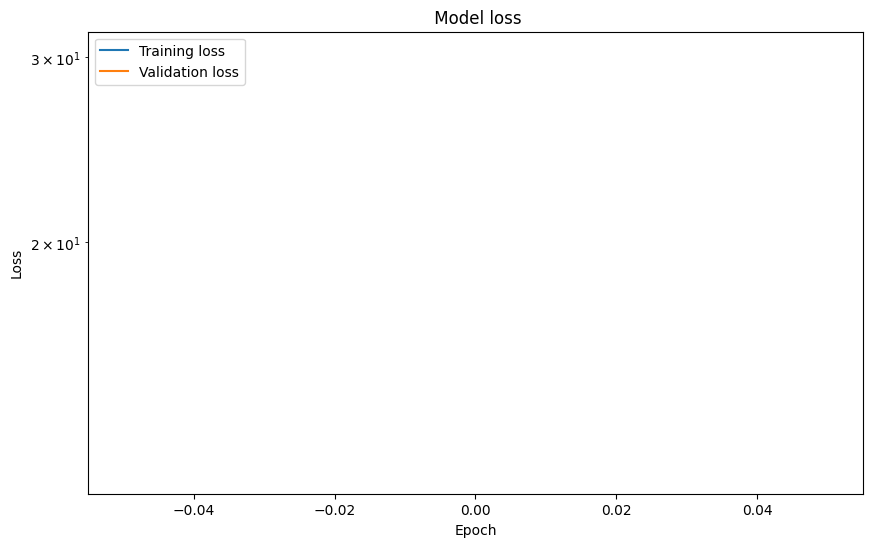

Fitted Weights Hash: 7595f8d3a4f571586f99eee7d4c83a08
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case CEFO3_202401_set_5
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

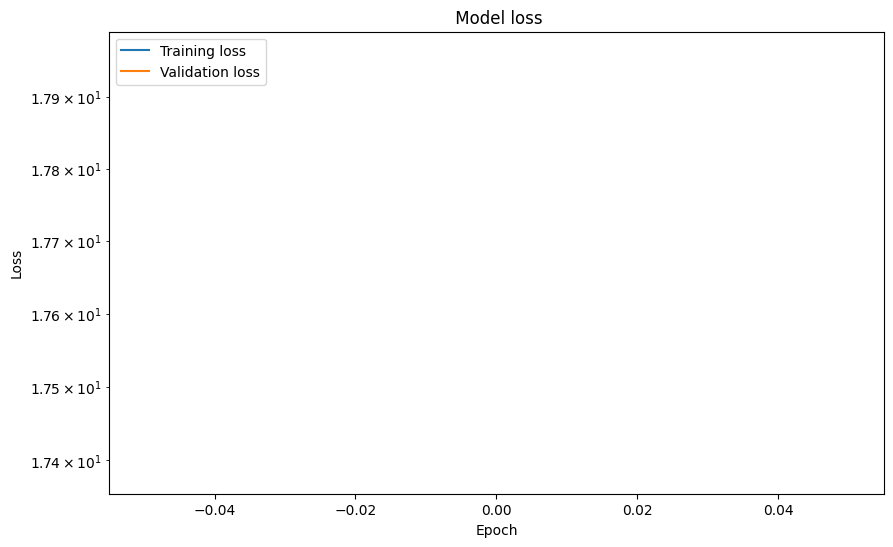

Fitted Weights Hash: 6d75079992004f9b5e39ce8dacb67679
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case BBFO3_202401_set_4
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

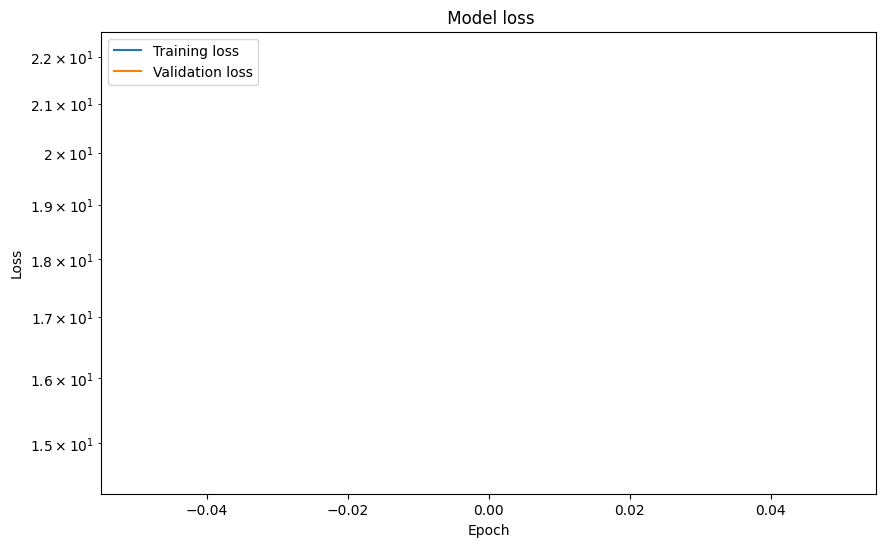

Fitted Weights Hash: 036d02f09ae4781351ab7002a28f01b2
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case CGFW1_202401_set_4
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

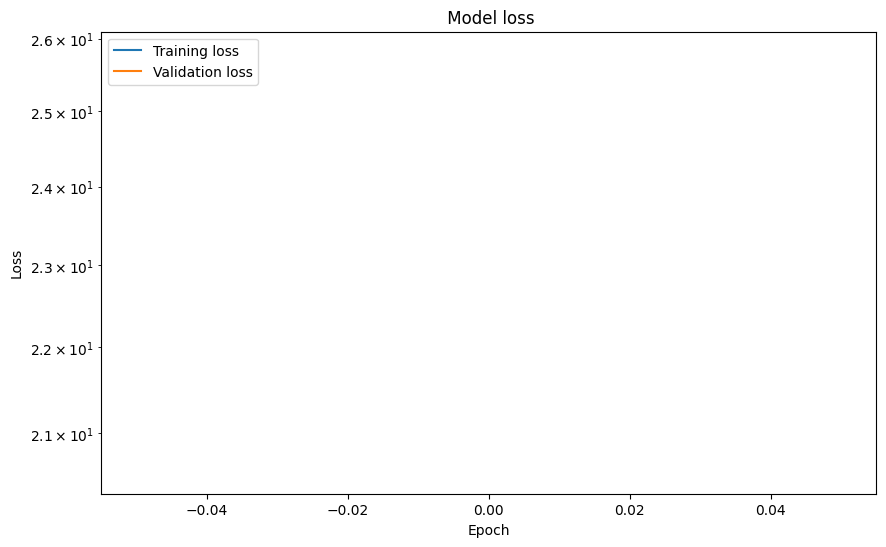

Fitted Weights Hash: 325bd913238ae628f1b7cd5e2ba8076a
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case MEFW1_202401_set_4
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

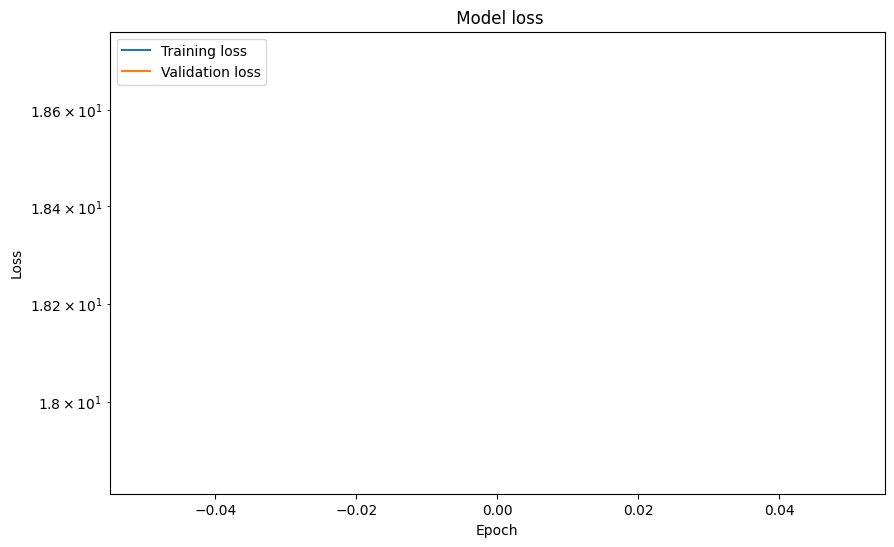

Fitted Weights Hash: 80136fbc8f71023a66b53576ee2bb713
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case FMFO3_202401_set_5
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

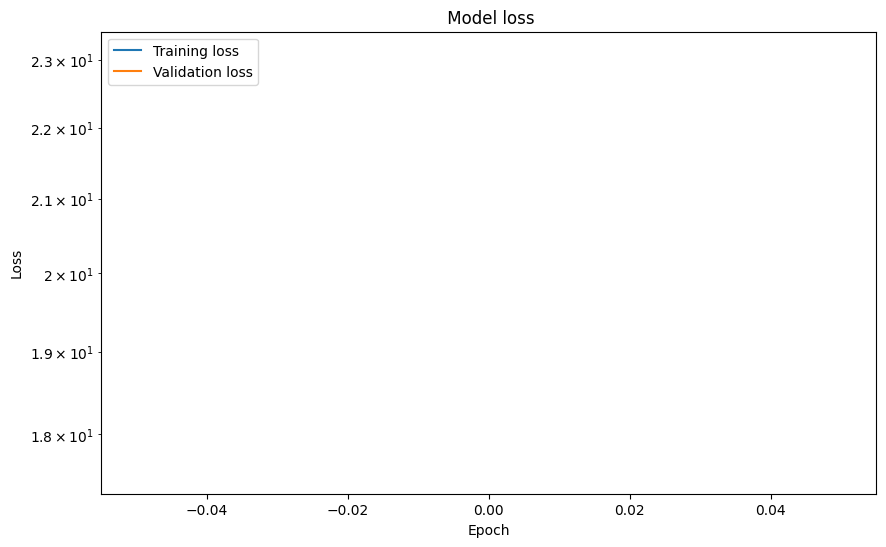

Fitted Weights Hash: 39deba198a450cb8a756597de1345e50
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case FWFW1_202401_set_5
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

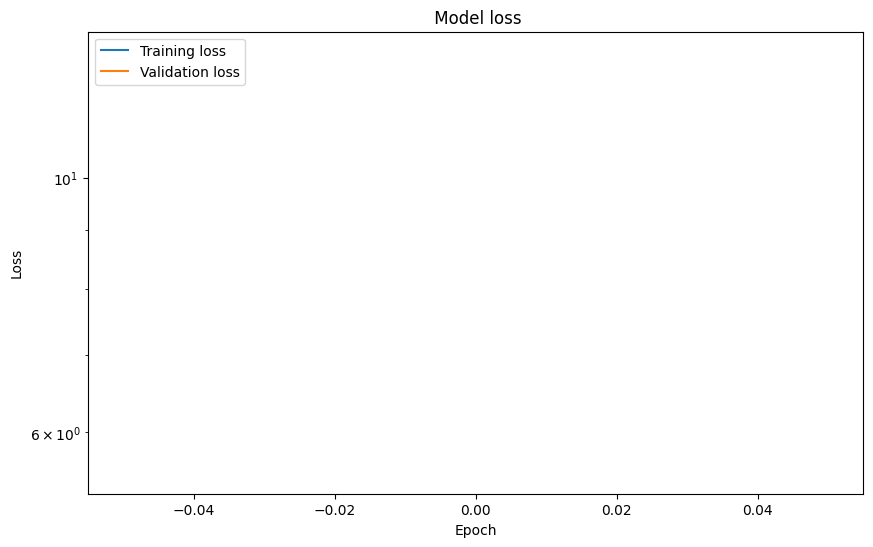

Fitted Weights Hash: ba8ef8e3716f01eeab37dbd67a99fb12
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case BBFO3_202401
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type': 'exp'

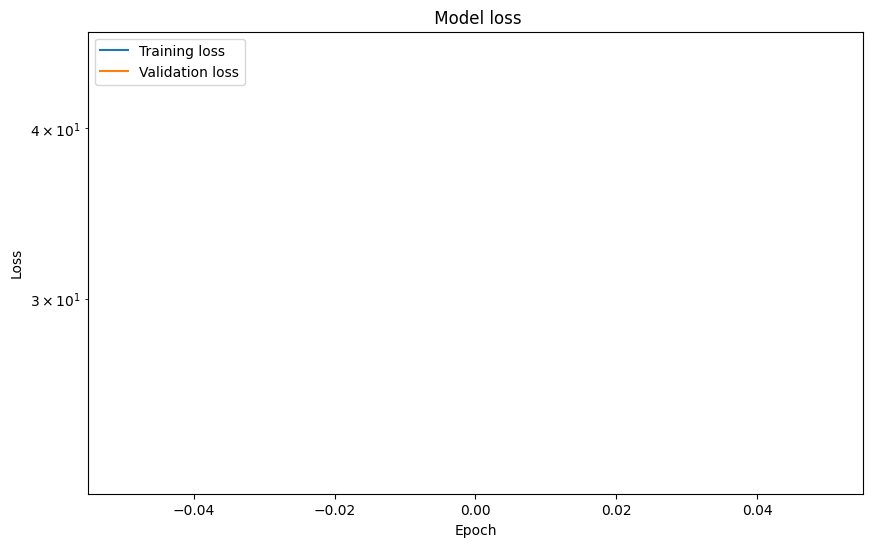

Fitted Weights Hash: 4220d9cea46ac68b6068bfdea899fc89
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case CWFO3_202401_set_2
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

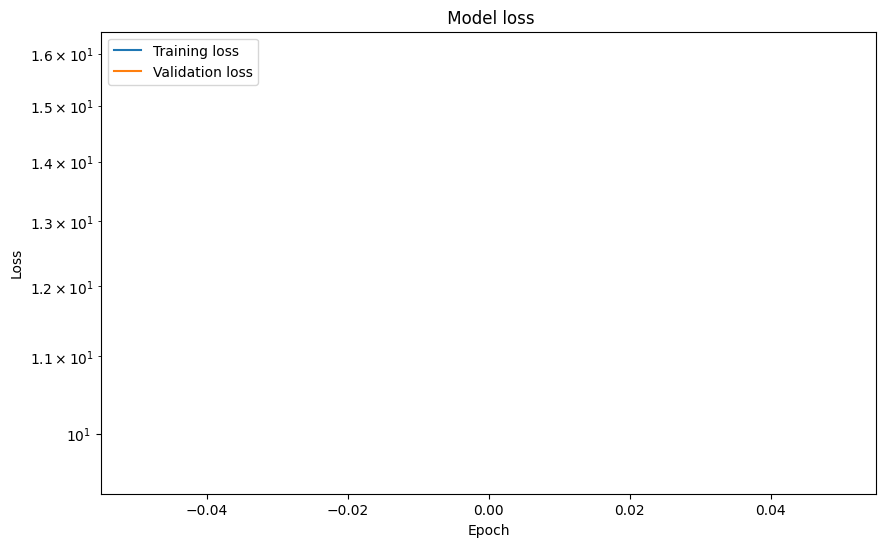

Fitted Weights Hash: c41149f91c40bed9b0f958614a8d29ba
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training with Case BBFO3_202401_set_3
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 2, 'dense_units': 30, 'activation': ['tanh', 'tanh'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type':

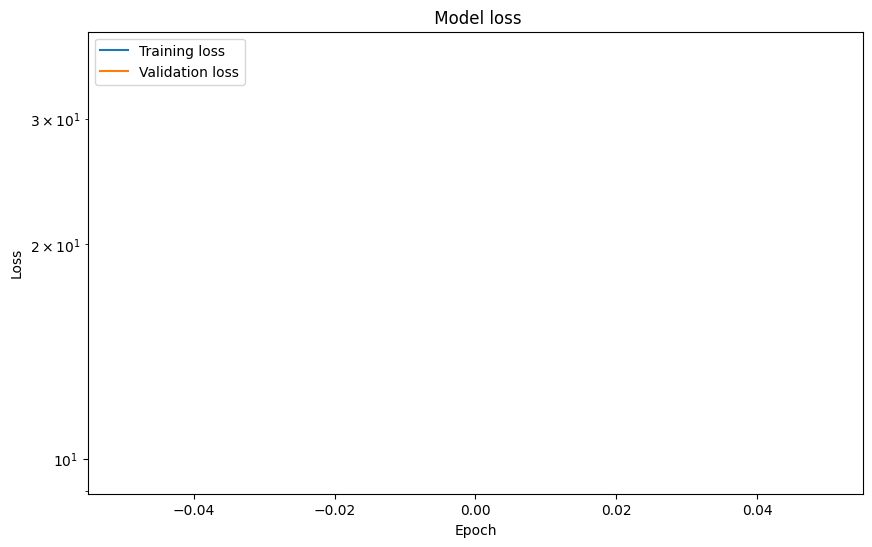

Fitted Weights Hash: fe57f569a2b2bdd617af457d9c69b3cd


In [29]:
# Train
for case in train_cases:
    print("~"*50)
    print(f"Training with Case {case}")
    rnn_dat_temp = RNNData(train[case], params['scaler'], params['features_list'])
    rnn_dat_temp.train_test_split(
        time_fracs = [.8, .1, .1]
    )
    rnn_dat_temp.scale_data()
    rnn_dat_temp.batch_reshape(timesteps = params['timesteps'], batch_size = params['batch_size'])
    rnn.fit(rnn_dat_temp['X_train'], rnn_dat_temp['y_train'],
           validation_data=(rnn_dat_temp['X_val'], rnn_dat_temp['y_val']))    

In [30]:
# Predict
outputs_rnn_serial = {}
test_ind = rnn_dat.test_ind
for i, case in enumerate(test_cases):
    print("~"*50)
    rnn_dat_temp = RNNData(train[case], params['scaler'], params['features_list'])
    rnn_dat_temp.train_test_split(
        time_fracs = [.8, .1, .1]
    )
    rnn_dat_temp.scale_data()
    rnn_dat_temp.batch_reshape(timesteps = params['timesteps'], batch_size = params['batch_size'])    
    X_temp = rnn_dat_temp.scale_all_X()
    m = rnn.predict(X_temp)
    outputs_rnn_serial[case] = {'case':case, 'errs': rmse(m[test_ind:], rnn_dat.y_test)}

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation index: 576 to 648
Test index: 648 to 720
X_train shape: (576, 8), y_train shape: (576, 1)
X_val shape: (72, 8), y_val shape: (72, 1)
X_test shape: (72, 8), y_test shape: (72, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5
Scaling all X data with scaler StandardScaler(), fitted on X_train
Predicting test data
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain', 'elev', 'lon', 'lat', 'solar', 'wind']
Train index: 0 to 576
Validation inde

In [31]:
df_rnn_serial = pd.DataFrame.from_dict(outputs_rnn_serial).transpose()
df_rnn_serial.head()

case       errs
PEOW1_202401_set_3  PEOW1_202401_set_3  10.117519
MEFW1_202401_set_5  MEFW1_202401_set_5    9.72891
FWFW1_202401_set_2  FWFW1_202401_set_2  11.109733
KEEO3_202401_set_5  KEEO3_202401_set_5   5.219171
IRFO3_202401_set_4  IRFO3_202401_set_4   8.909429

In [32]:
df_rnn_serial.errs.mean()

8.935900221519159

In [33]:
# End Timer
end_time = time.time()

# Calculate Code Runtime
elapsed_time_ser = end_time - start_time
print(f"Serial Training Elapsed time: {elapsed_time_ser:.4f} seconds")

Serial Training Elapsed time: 113.0016 seconds


## Compare

In [34]:
print(f"Total Test Cases: {len(test_cases)}")
print(f"Total Test Hours: {rnn_dat_temp.y_test.shape[0]}")

Total Test Cases: 20
Total Test Hours: 72


In [35]:
print(f"Spatial Training RMSE: {errs.mean()}")
print(f"Serial Training RMSE: {df_rnn_serial.errs.mean()}")
print(f"Augmented KF RMSE: {df_kf.errs.mean()}")

Spatial Training RMSE: 3.976586029870589
Serial Training RMSE: 8.935900221519159
Augmented KF RMSE: 4.271973638021123


In [36]:
print(f"Spatial Training Elapsed time: {elapsed_time_sp:.4f} seconds")
print(f"Serial Training Elapsed time: {elapsed_time_ser:.4f} seconds")

Spatial Training Elapsed time: 63.2867 seconds
Serial Training Elapsed time: 113.0016 seconds
